# Trend Analysis
This was a failed attempt at trying to predict results based on scored attempts. I took the 10 best attempts at predicting the actual PoU in order. I  calculated the mean, median, and a linear extrapolation of the trend to predict new values to test.

Although this was not in the spirit of the contest I am leaving it here as it was something I did to try to improve my score. That it failed so spectacularly was interesting in itself.

## Initialise the styles for the workbooks

In [1]:
# Initialise styles and packages we need
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

## Imports and classes used

In [2]:
import pandas as pd
# conventional way to import seaborn
import seaborn as sns; sns.set(style="ticks", color_codes=True)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import warnings

# allow plots to appear within the notebook
%matplotlib inline

print("Pandas version:  {}".format(pd.__version__))
print("Seaborn version: {}".format(sns.__version__))
print("Numpy version:   {}".format(np.__version__))
#print("Matplotlib version:  {}".format(matplotlib.__version__))

# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

Pandas version:  0.23.4
Seaborn version: 0.9.0
Numpy version:   1.15.2


## Import the best last 10 predictions and merge them into a DataFrame

In [3]:
fname01 = '10_10_6615'
fname02 = '09_10_6513'
fname03 = '08_10_5019'
fname04 = '07_10_2599'
fname05 = '06_10_1228'
fname06 = '05_09_9060'
fname07 = '04_09_9039'
fname08 = '03_09_8233'
fname09 = '02_09_5073'
fname10 = '01_07_7688'

f01 = pd.read_csv("data/1st/{}.csv".format(fname01))
f02 = pd.read_csv("data/1st/{}.csv".format(fname02))
f03 = pd.read_csv("data/1st/{}.csv".format(fname03))
f04 = pd.read_csv("data/1st/{}.csv".format(fname04))
f05 = pd.read_csv("data/1st/{}.csv".format(fname05))
f06 = pd.read_csv("data/1st/{}.csv".format(fname06))
f07 = pd.read_csv("data/1st/{}.csv".format(fname07))
f08 = pd.read_csv("data/1st/{}.csv".format(fname08))
f09 = pd.read_csv("data/1st/{}.csv".format(fname09))
f10 = pd.read_csv("data/1st/{}.csv".format(fname10))

f01.rename(columns = {'prevalence_of_undernourishment':fname01}, inplace=True)
f02.rename(columns = {'prevalence_of_undernourishment':fname02}, inplace=True)
f03.rename(columns = {'prevalence_of_undernourishment':fname03}, inplace=True)
f04.rename(columns = {'prevalence_of_undernourishment':fname04}, inplace=True)
f05.rename(columns = {'prevalence_of_undernourishment':fname05}, inplace=True)
f06.rename(columns = {'prevalence_of_undernourishment':fname06}, inplace=True)
f07.rename(columns = {'prevalence_of_undernourishment':fname07}, inplace=True)
f08.rename(columns = {'prevalence_of_undernourishment':fname08}, inplace=True)
f09.rename(columns = {'prevalence_of_undernourishment':fname09}, inplace=True)
f10.rename(columns = {'prevalence_of_undernourishment':fname10}, inplace=True)

df = pd.merge(f01, f02, on='row_id', how='inner')
df = pd.merge(df, f03, on='row_id', how='inner')
df = pd.merge(df, f04, on='row_id', how='inner')
df = pd.merge(df, f05, on='row_id', how='inner')
df = pd.merge(df, f06, on='row_id', how='inner')
df = pd.merge(df, f07, on='row_id', how='inner')
df = pd.merge(df, f08, on='row_id', how='inner')
df = pd.merge(df, f09, on='row_id', how='inner')
df = pd.merge(df, f10, on='row_id', how='inner')

print(df.head())

   row_id  10_10_6615  09_10_6513  08_10_5019  07_10_2599  06_10_1228  \
0       0    4.175255    3.866755    4.885678    1.892225    5.754860   
1       1    7.194215   10.765890    7.194671    5.967312    8.937474   
2       2    8.869090    8.217411    9.185610    9.693758   11.947035   
3       3   20.795643   22.099010   19.648315   25.946926   22.374083   
4       4   18.112755   21.714508   17.365273   22.246952   19.589627   

   05_09_9060  04_09_9039  03_09_8233  02_09_5073  01_07_7688  
0    4.547325    5.634233    6.044384    4.127490    5.063972  
1    7.361398    8.793577    9.118193    5.037117    3.356327  
2    7.438008    8.497033   10.134302   10.632344    7.231678  
3   25.921427   27.141376   24.255393   24.719456   33.174477  
4   20.473459   19.256905   17.720343   13.313832   13.191649  


## Calculate the mean

In [4]:
df['mean'] = df.mean(axis=1)
print(df.head())


   row_id  10_10_6615  09_10_6513  08_10_5019  07_10_2599  06_10_1228  \
0       0    4.175255    3.866755    4.885678    1.892225    5.754860   
1       1    7.194215   10.765890    7.194671    5.967312    8.937474   
2       2    8.869090    8.217411    9.185610    9.693758   11.947035   
3       3   20.795643   22.099010   19.648315   25.946926   22.374083   
4       4   18.112755   21.714508   17.365273   22.246952   19.589627   

   05_09_9060  04_09_9039  03_09_8233  02_09_5073  01_07_7688       mean  
0    4.547325    5.634233    6.044384    4.127490    5.063972   4.181107  
1    7.361398    8.793577    9.118193    5.037117    3.356327   6.793288  
2    7.438008    8.497033   10.134302   10.632344    7.231678   8.531479  
3   25.921427   27.141376   24.255393   24.719456   33.174477  22.643282  
4   20.473459   19.256905   17.720343   13.313832   13.191649  16.998664  


## Calculate the median

In [5]:
df['median'] = df.median(axis=1)
print(df.head())

   row_id  10_10_6615  09_10_6513  08_10_5019  07_10_2599  06_10_1228  \
0       0    4.175255    3.866755    4.885678    1.892225    5.754860   
1       1    7.194215   10.765890    7.194671    5.967312    8.937474   
2       2    8.869090    8.217411    9.185610    9.693758   11.947035   
3       3   20.795643   22.099010   19.648315   25.946926   22.374083   
4       4   18.112755   21.714508   17.365273   22.246952   19.589627   

   05_09_9060  04_09_9039  03_09_8233  02_09_5073  01_07_7688       mean  \
0    4.547325    5.634233    6.044384    4.127490    5.063972   4.181107   
1    7.361398    8.793577    9.118193    5.037117    3.356327   6.793288   
2    7.438008    8.497033   10.134302   10.632344    7.231678   8.531479   
3   25.921427   27.141376   24.255393   24.719456   33.174477  22.643282   
4   20.473459   19.256905   17.720343   13.313832   13.191649  16.998664   

      median  
0   4.364216  
1   7.194443  
2   8.700285  
3  23.449338  
4  17.916549  


## Calculate the linear regression value
For a change used the SciKit Learn LinearRegression predictor, rather than Pandas' interpolate .

In [ ]:
lr = LinearRegression()
x = np.asarray(range(10))[np.newaxis].T
# Loop through values and predict using linear regression
result = []
for i in range(len(df.index)):
    y = np.asarray(df.iloc[i:i+1,1:11]).T
    lr.fit(x, y)
    xPred = np.asarray([10]).reshape(-1,1)
    yPred=lr.predict(xPred)[0, 0]
    result.append(yPred)

#Convert Result into DatFrame and append to existing one
lin = pd.DataFrame(result, columns=['linear'])
df['linear'] = lin['linear']
print(df.head())    

   row_id  10_10_6615  09_10_6513  08_10_5019  07_10_2599  06_10_1228  \
0       0    4.175255    3.866755    4.885678    1.892225    5.754860   
1       1    7.194215   10.765890    7.194671    5.967312    8.937474   
2       2    8.869090    8.217411    9.185610    9.693758   11.947035   
3       3   20.795643   22.099010   19.648315   25.946926   22.374083   
4       4   18.112755   21.714508   17.365273   22.246952   19.589627   

   05_09_9060  04_09_9039  03_09_8233  02_09_5073  01_07_7688       mean  \
0    4.547325    5.634233    6.044384    4.127490    5.063972   4.181107   
1    7.361398    8.793577    9.118193    5.037117    3.356327   6.793288   
2    7.438008    8.497033   10.134302   10.632344    7.231678   8.531479   
3   25.921427   27.141376   24.255393   24.719456   33.174477  22.643282   
4   20.473459   19.256905   17.720343   13.313832   13.191649  16.998664   

      median     linear  
0   4.364216   5.453738  
1   7.194443   5.435215  
2   8.700285   9.145030  


## Plot each of the 616 predictions over time to see result.

C:\Users\leon\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


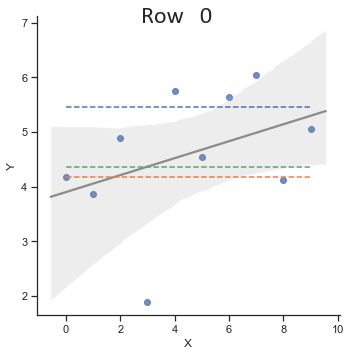

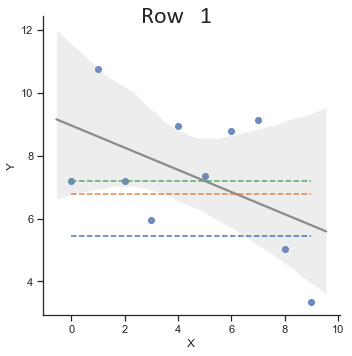

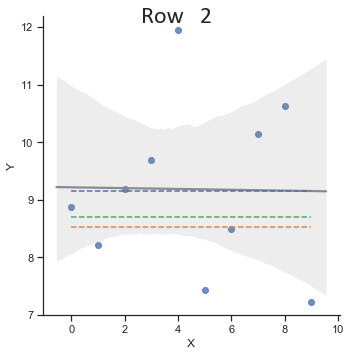

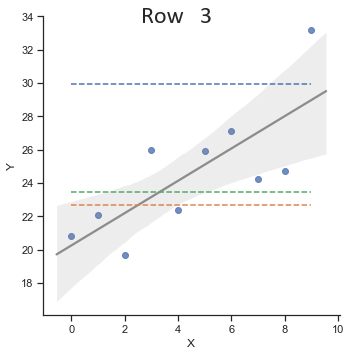

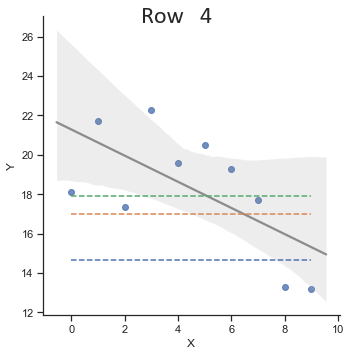

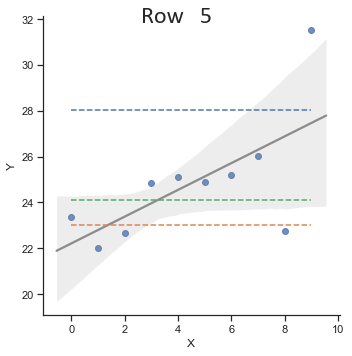

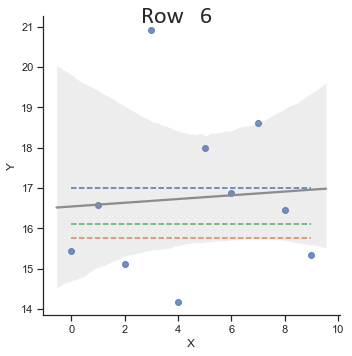

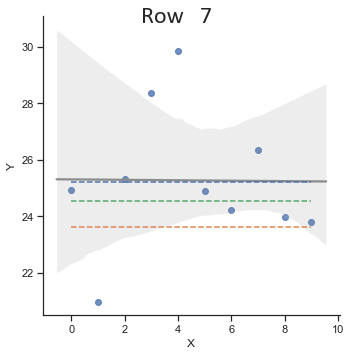

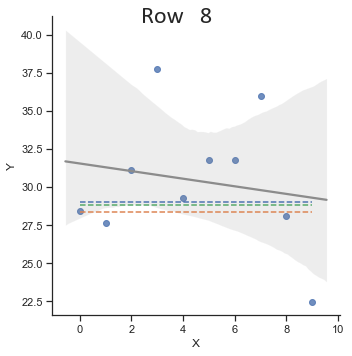

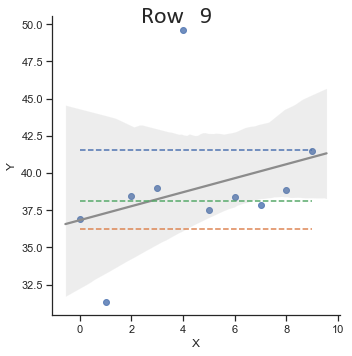

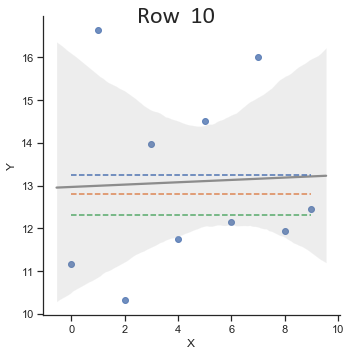

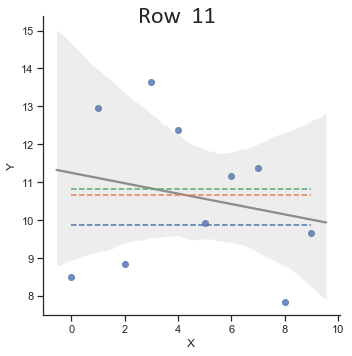

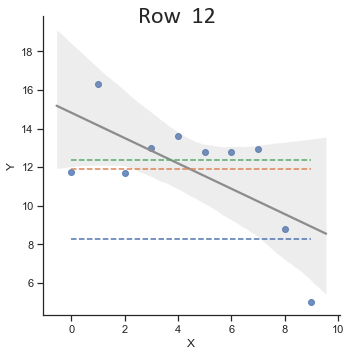

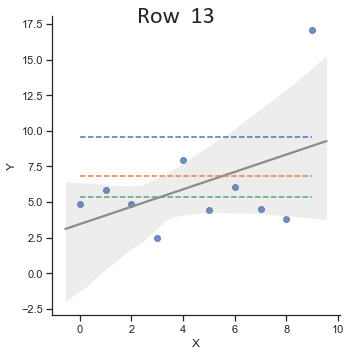

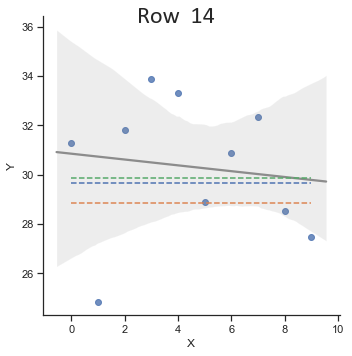

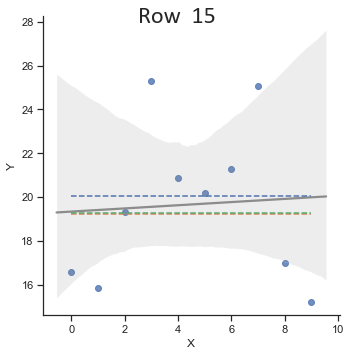

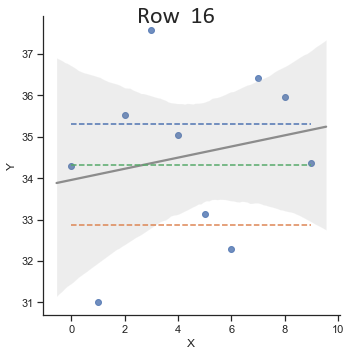

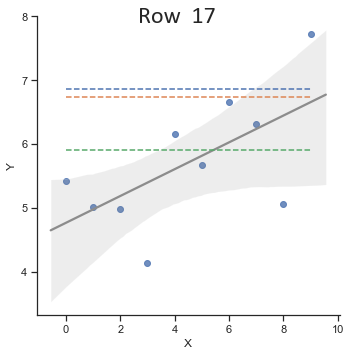

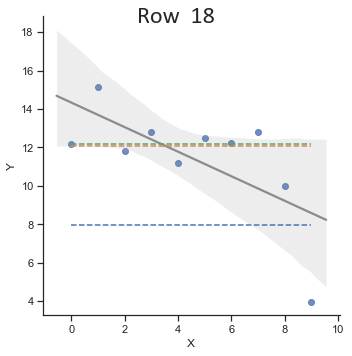

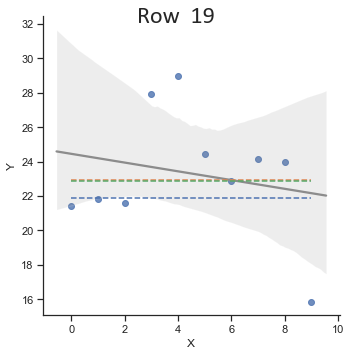

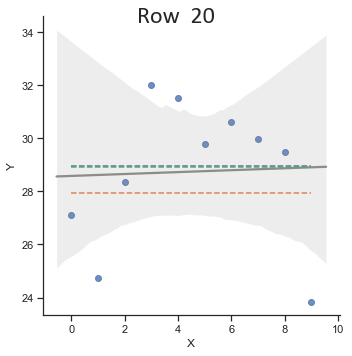

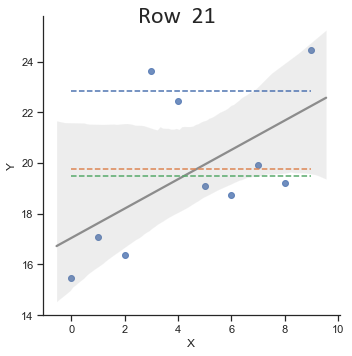

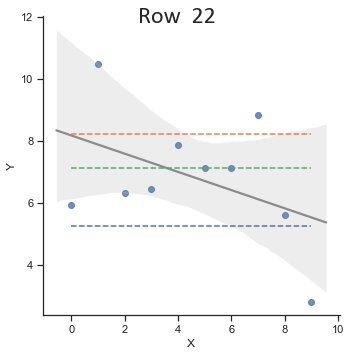

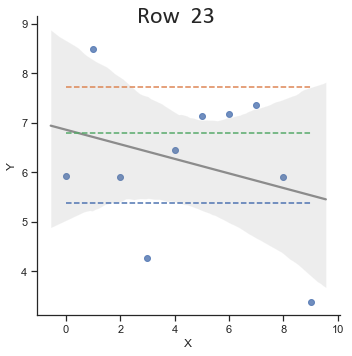

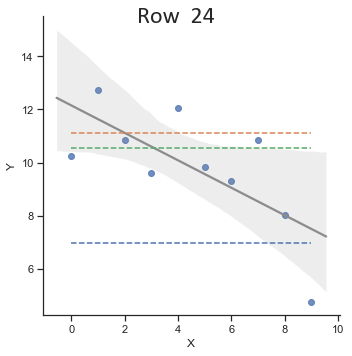

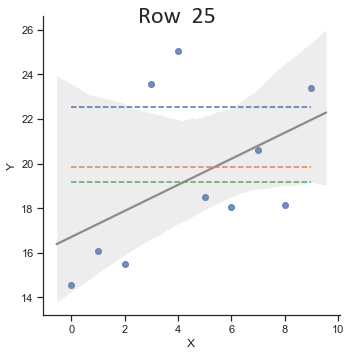

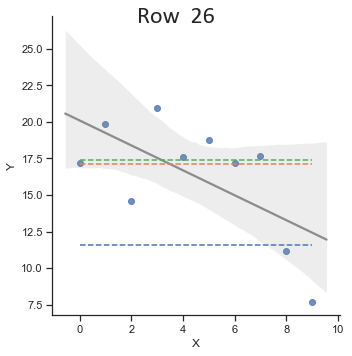

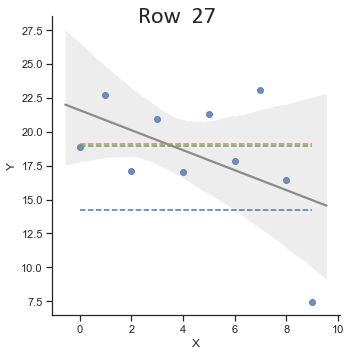

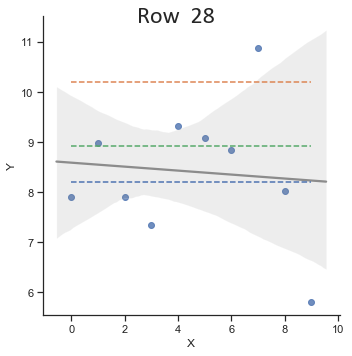

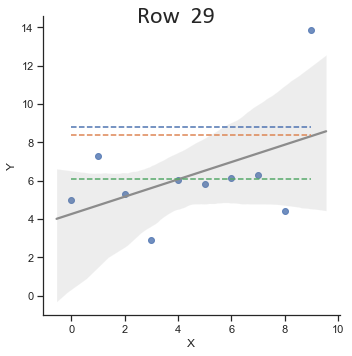

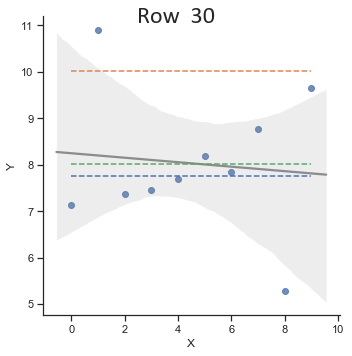

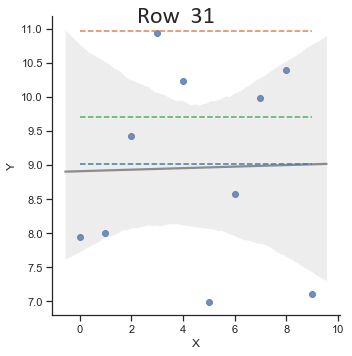

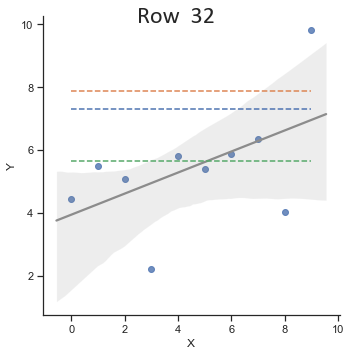

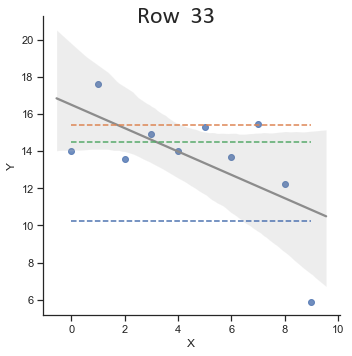

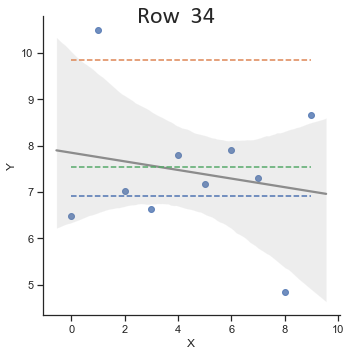

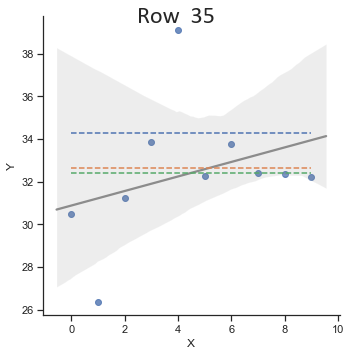

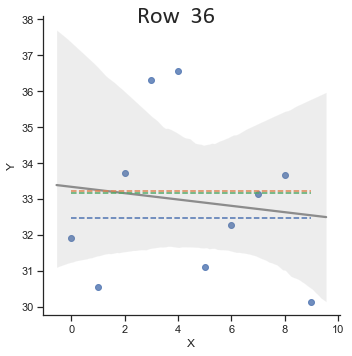

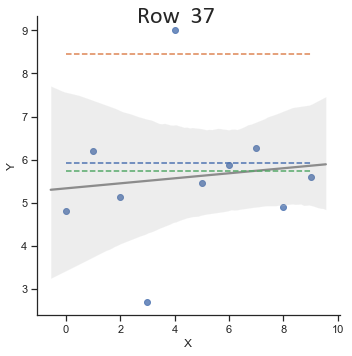

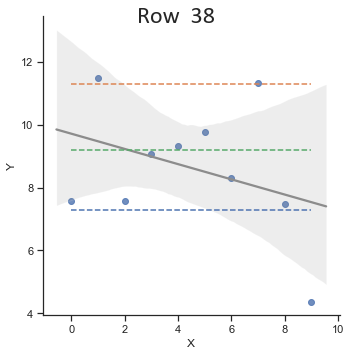

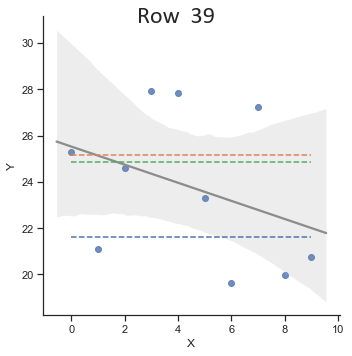

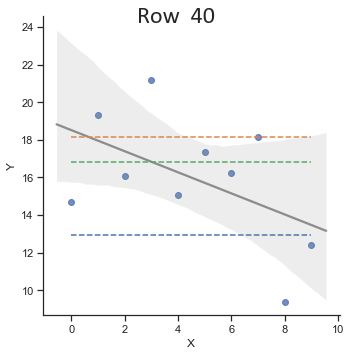

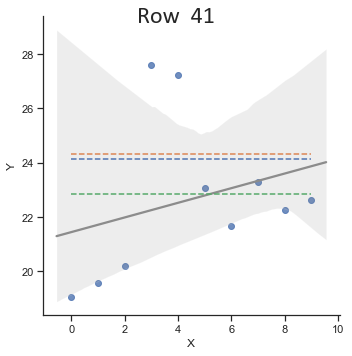

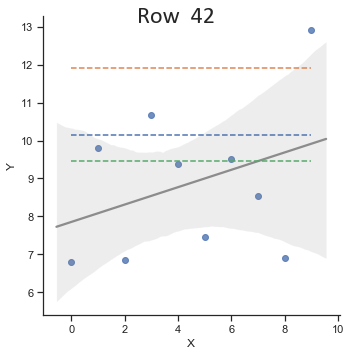

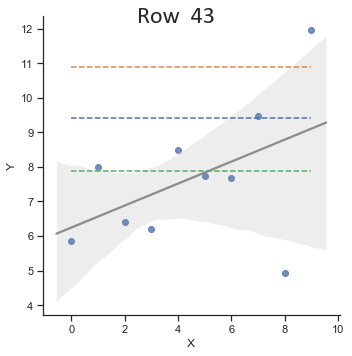

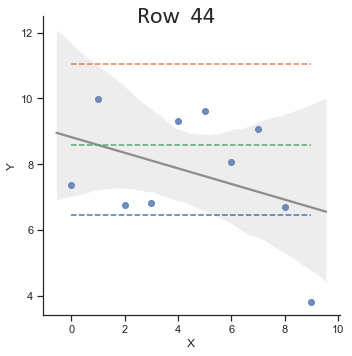

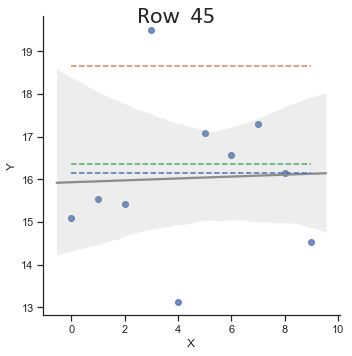

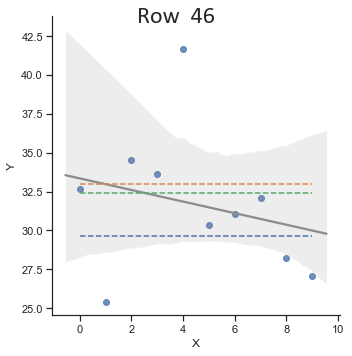

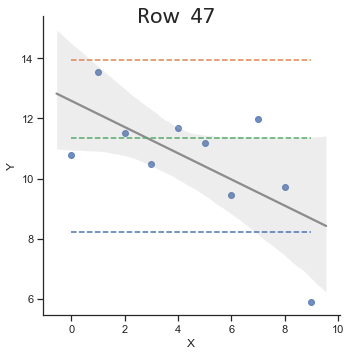

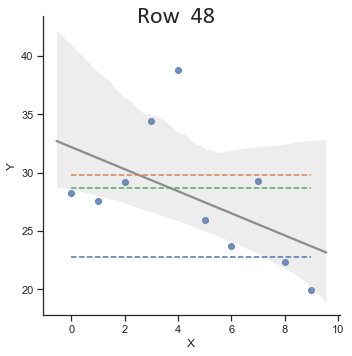

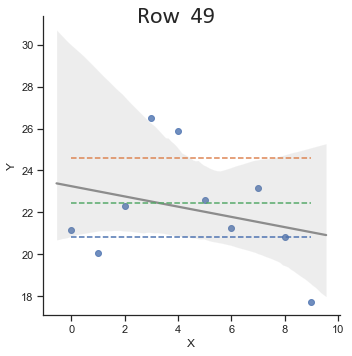

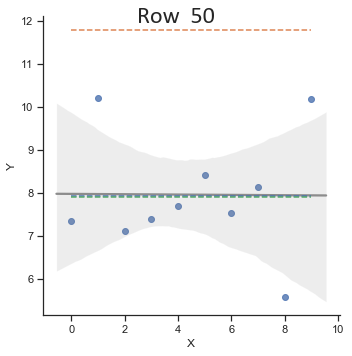

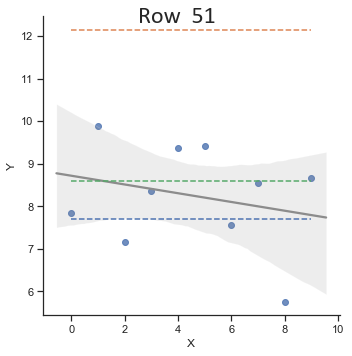

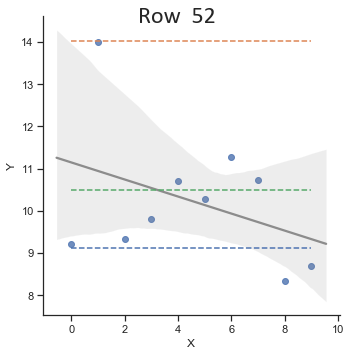

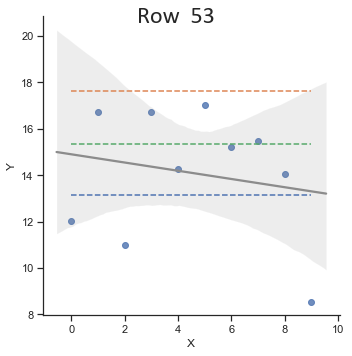

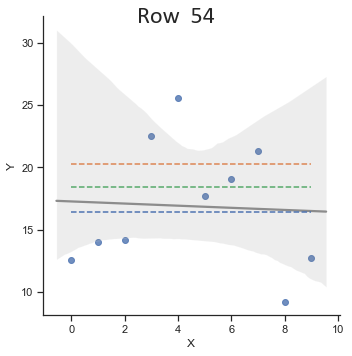

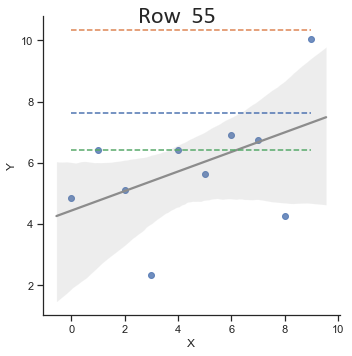

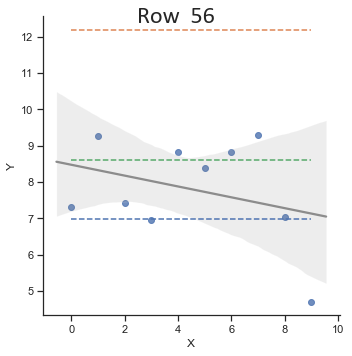

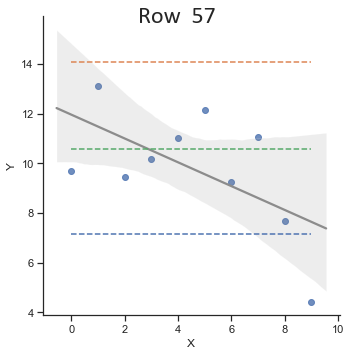

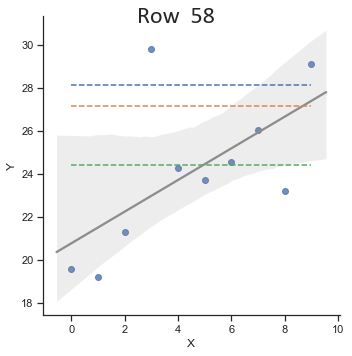

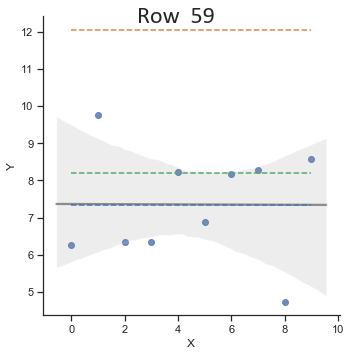

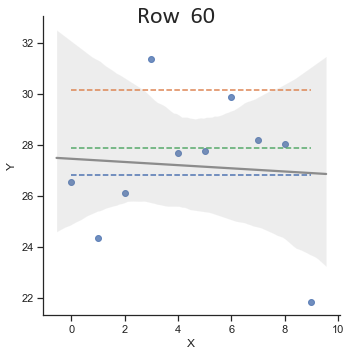

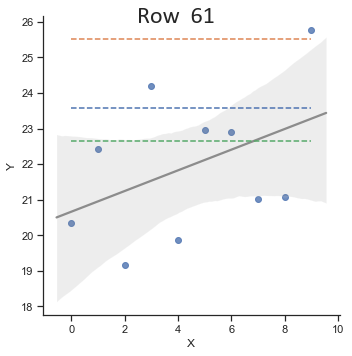

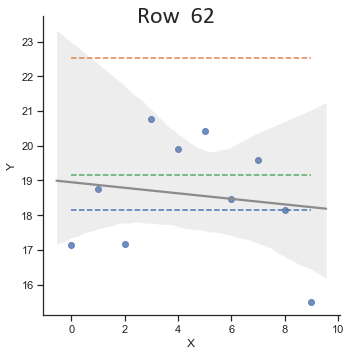

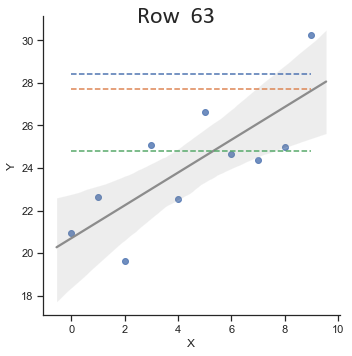

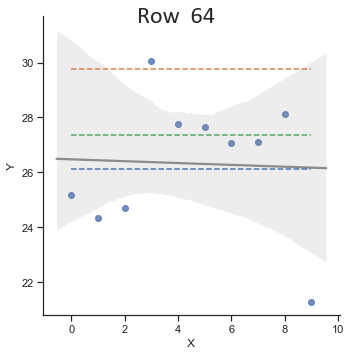

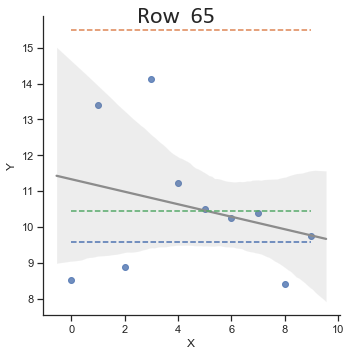

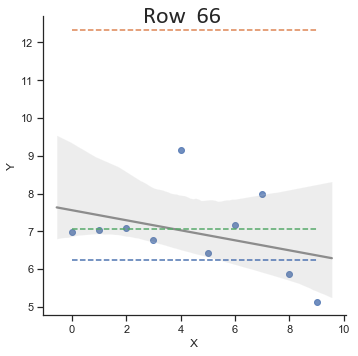

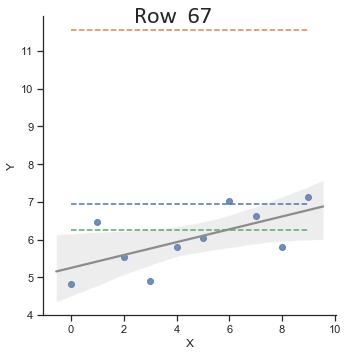

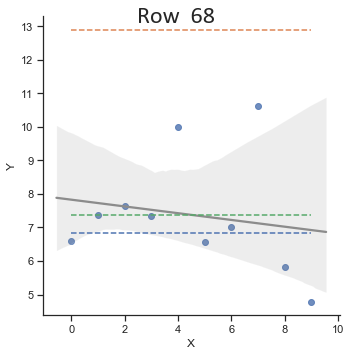

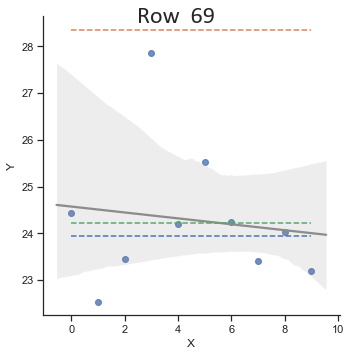

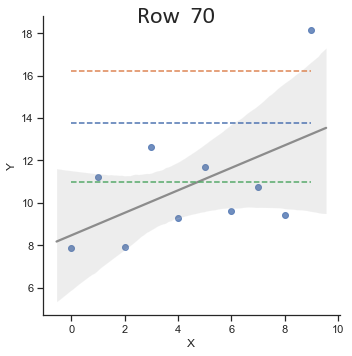

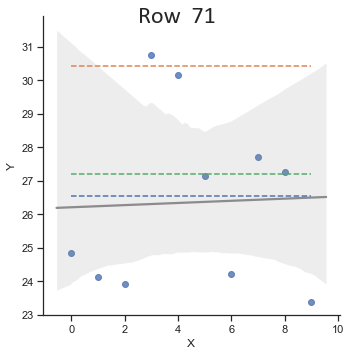

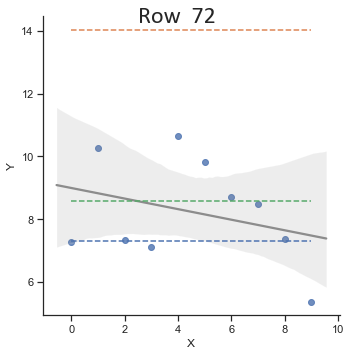

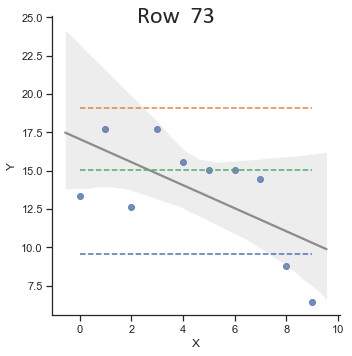

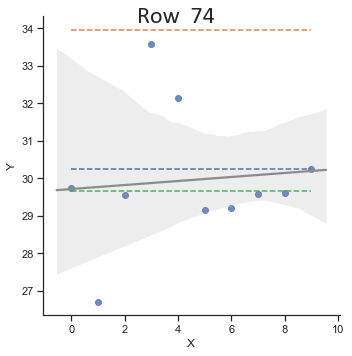

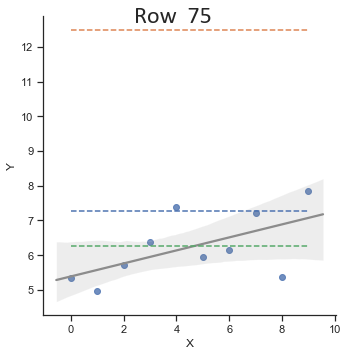

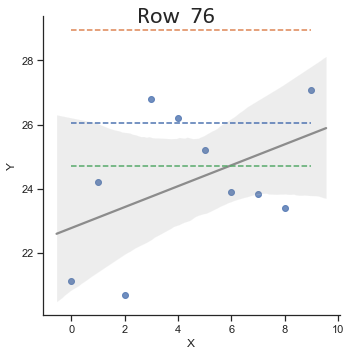

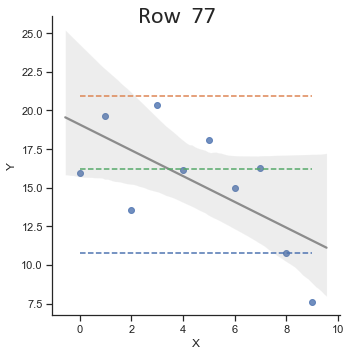

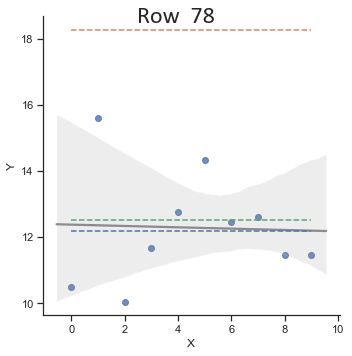

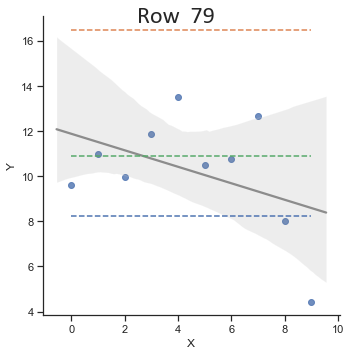

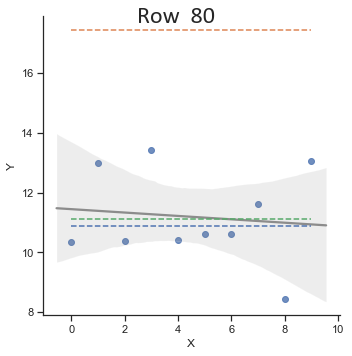

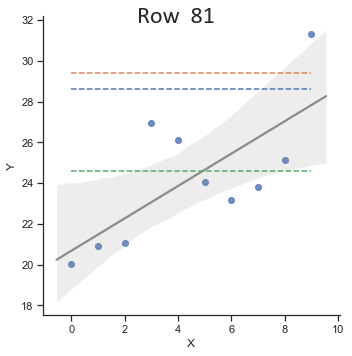

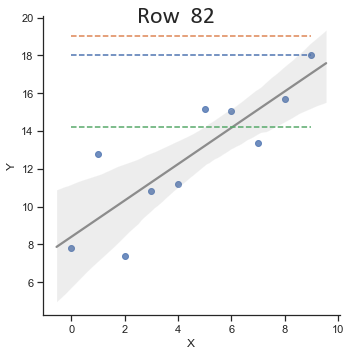

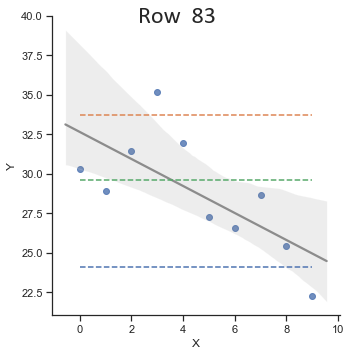

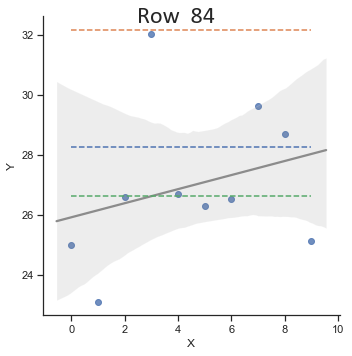

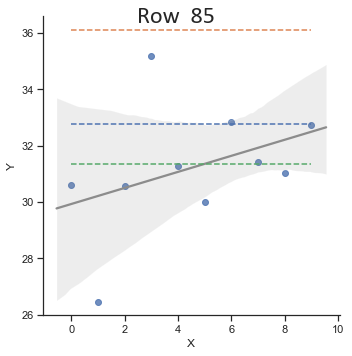

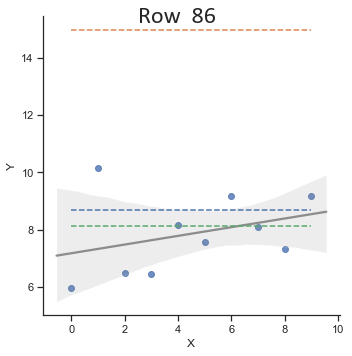

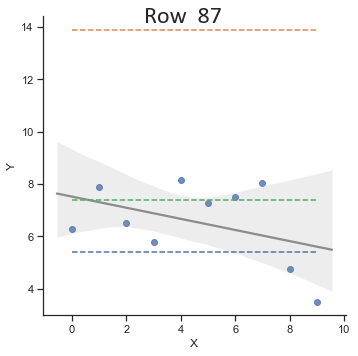

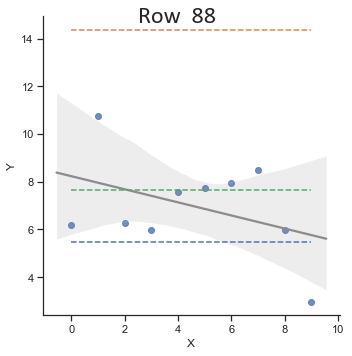

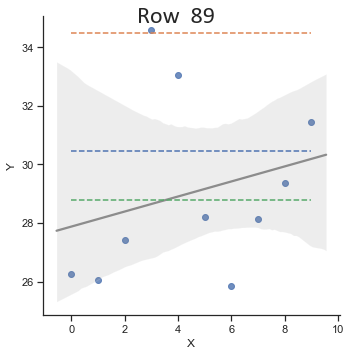

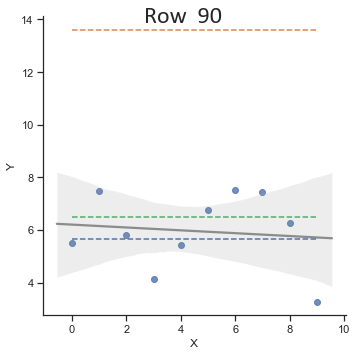

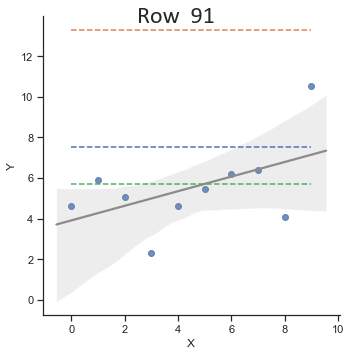

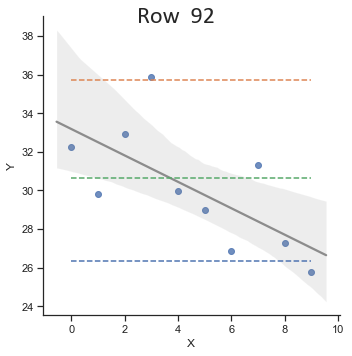

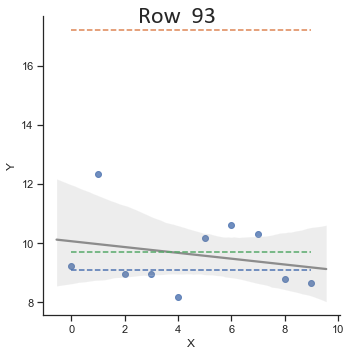

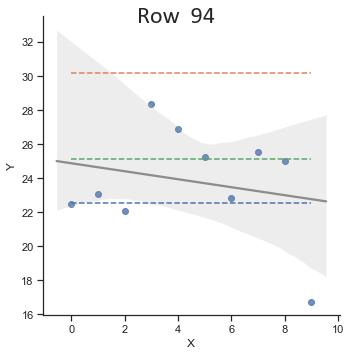

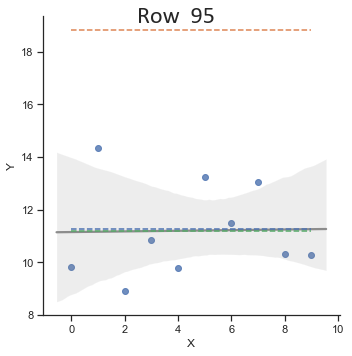

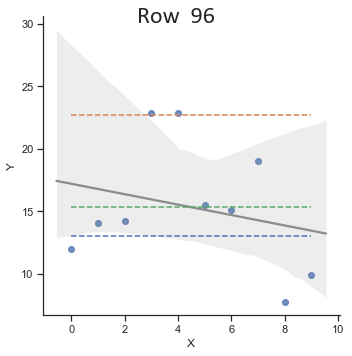

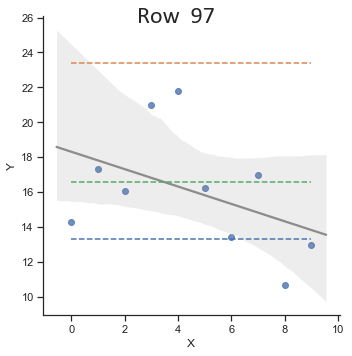

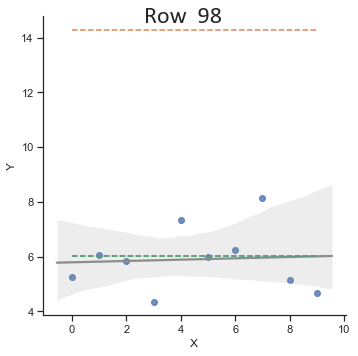

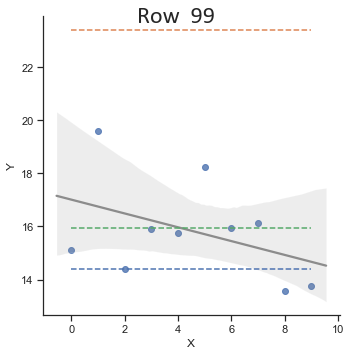

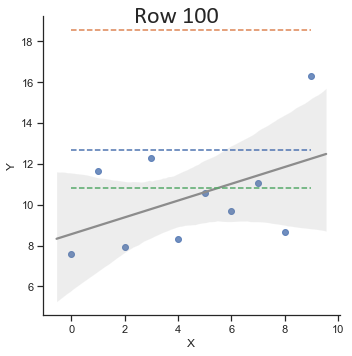

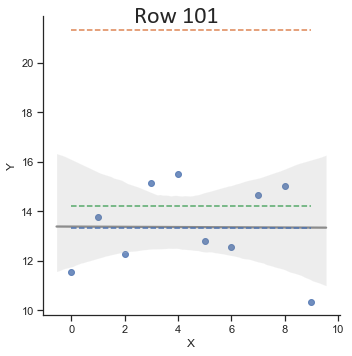

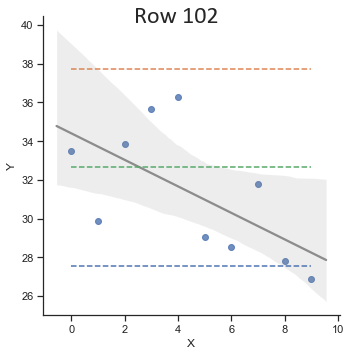

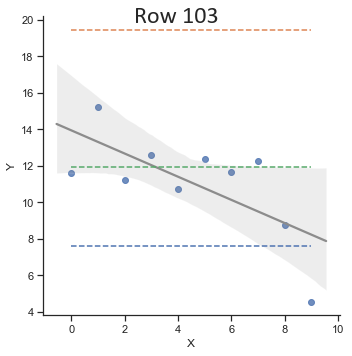

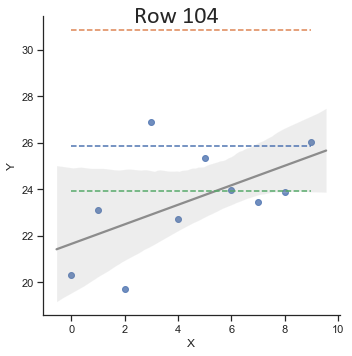

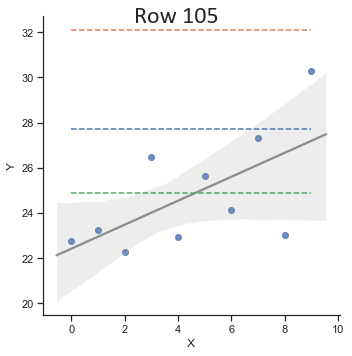

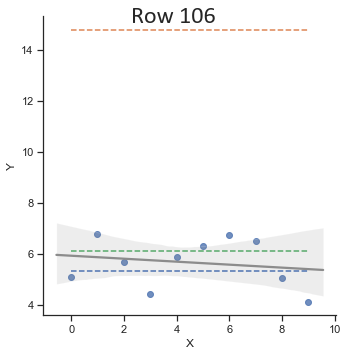

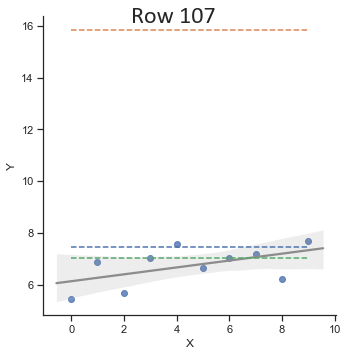

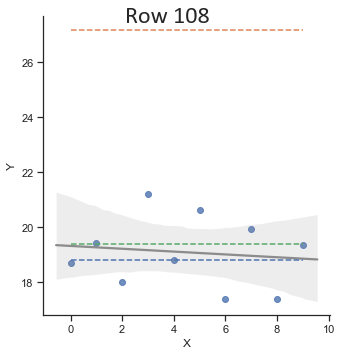

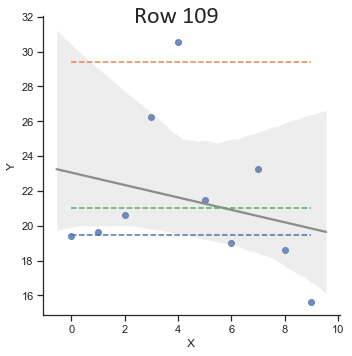

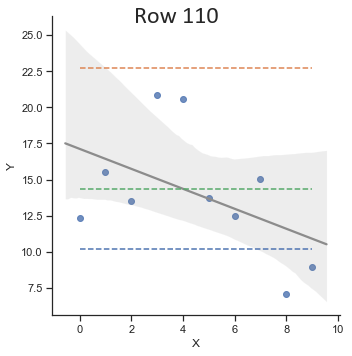

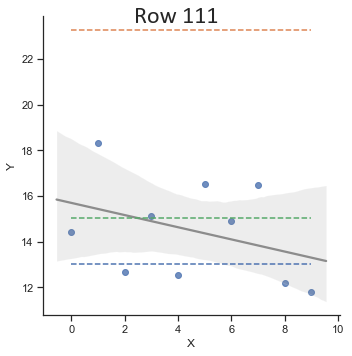

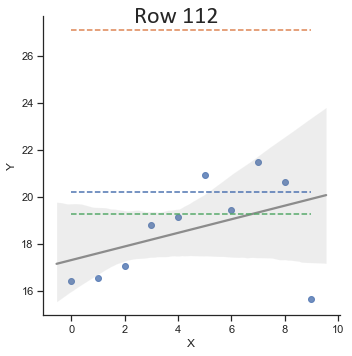

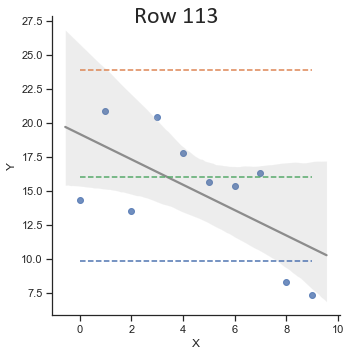

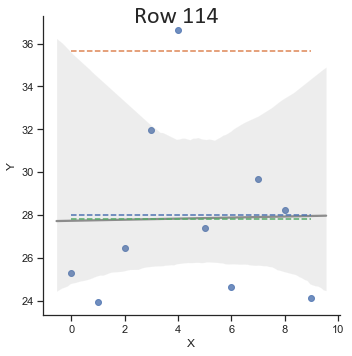

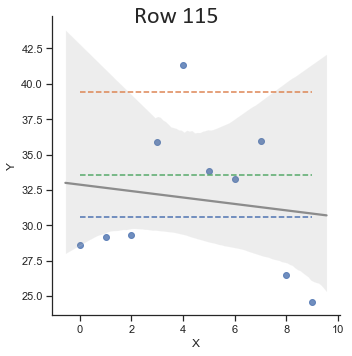

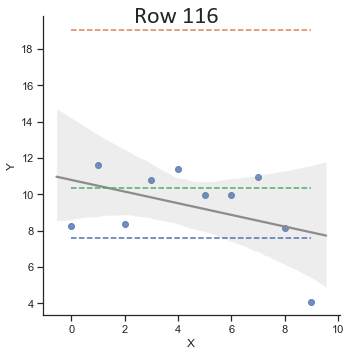

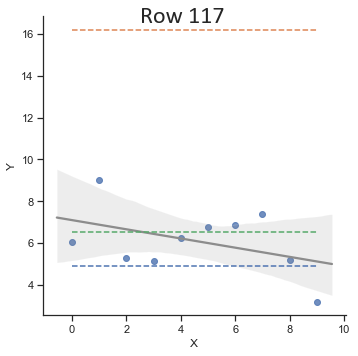

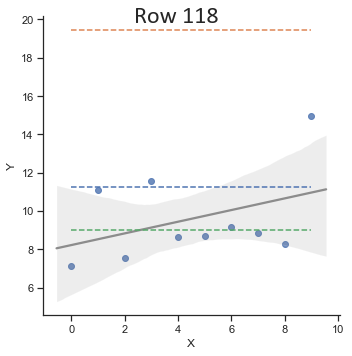

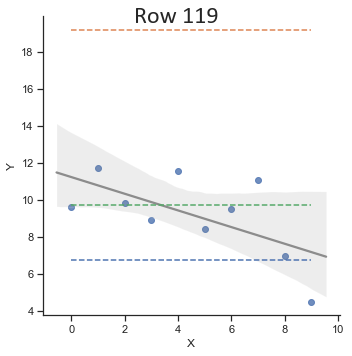

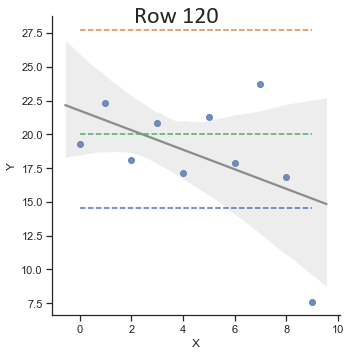

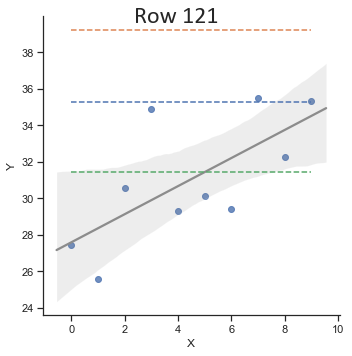

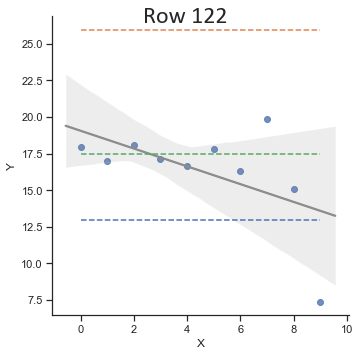

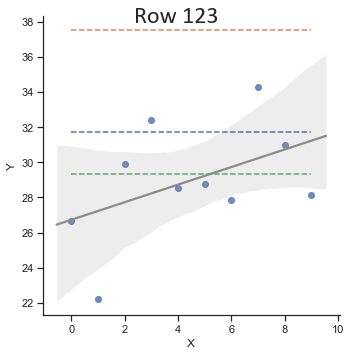

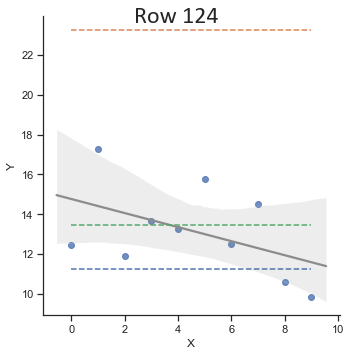

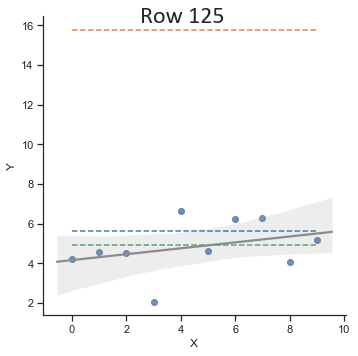

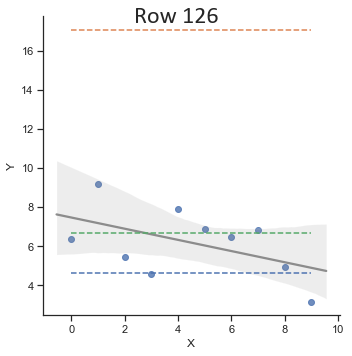

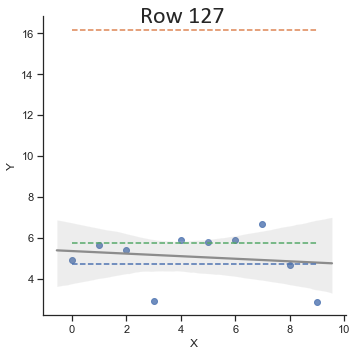

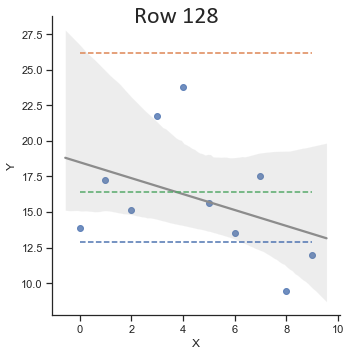

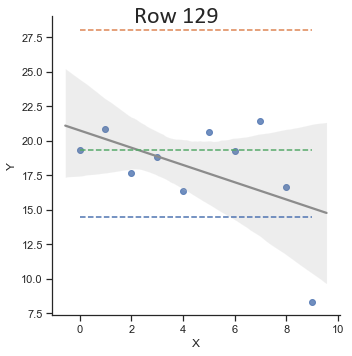

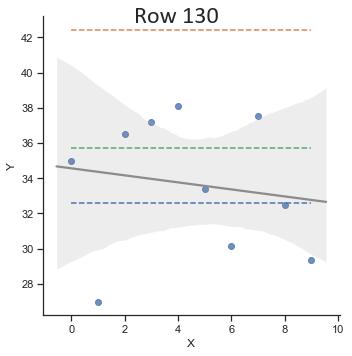

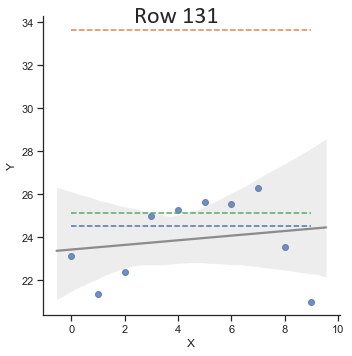

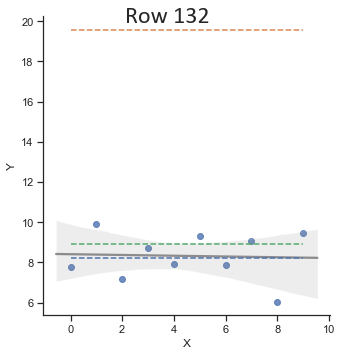

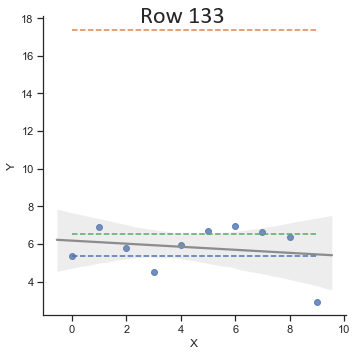

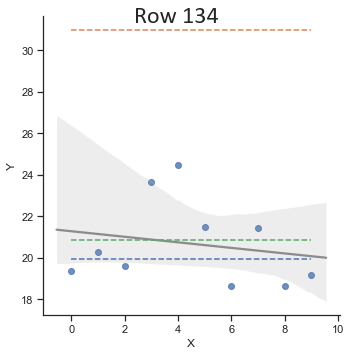

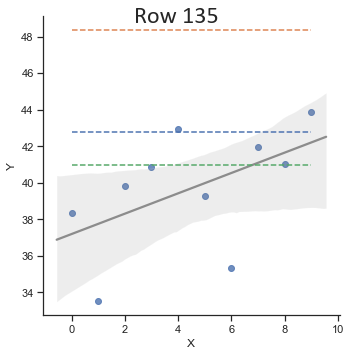

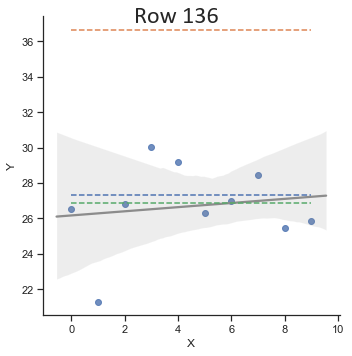

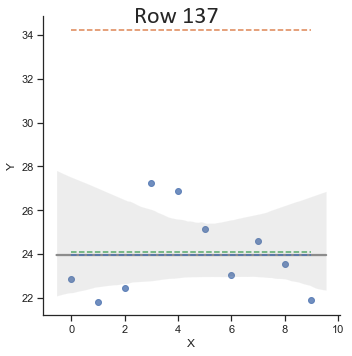

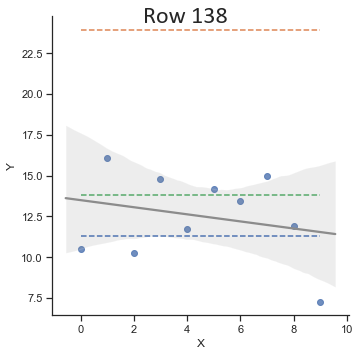

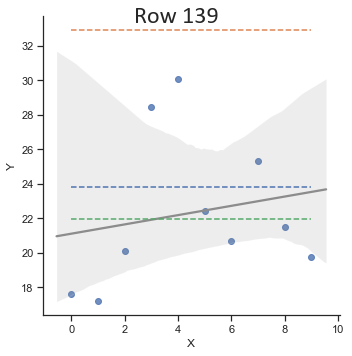

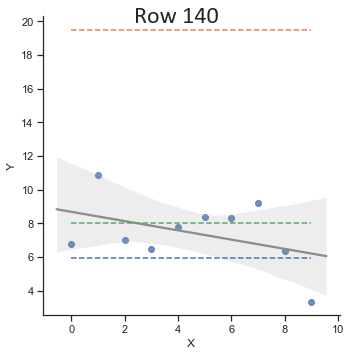

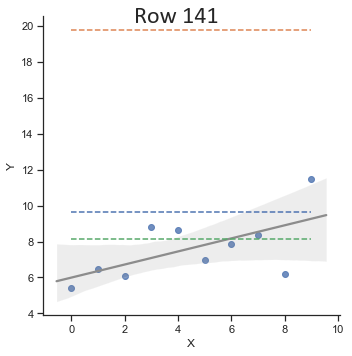

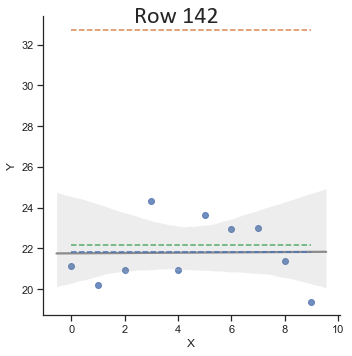

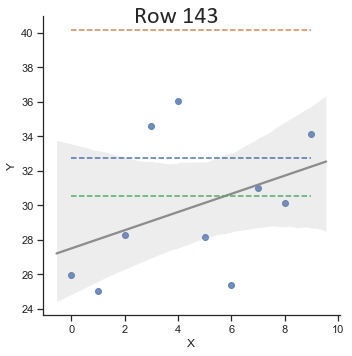

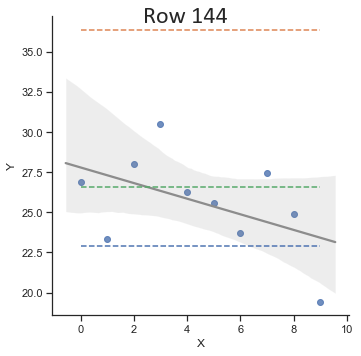

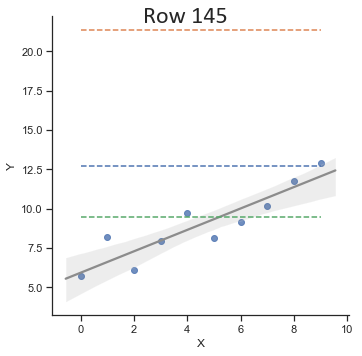

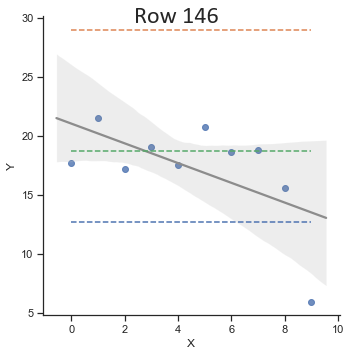

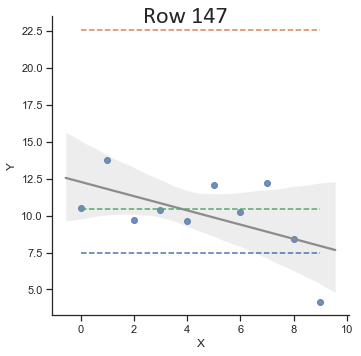

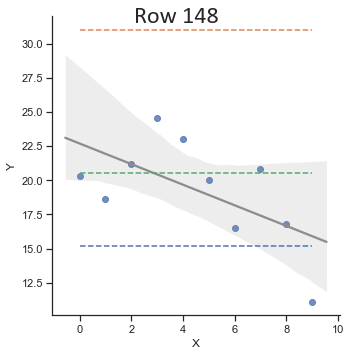

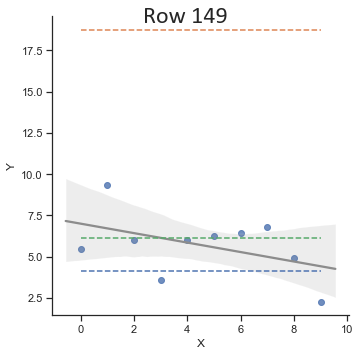

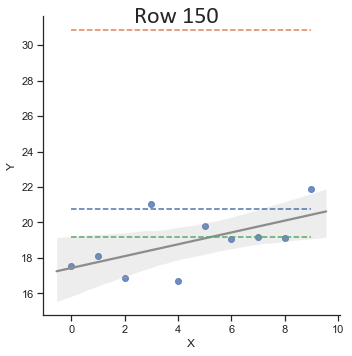

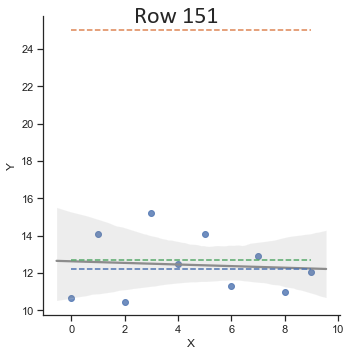

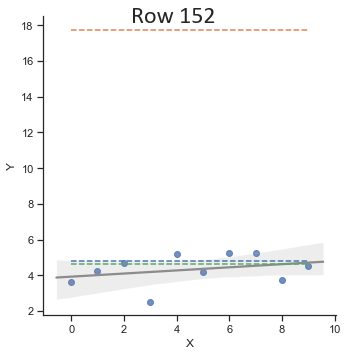

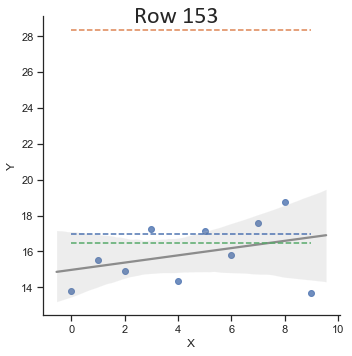

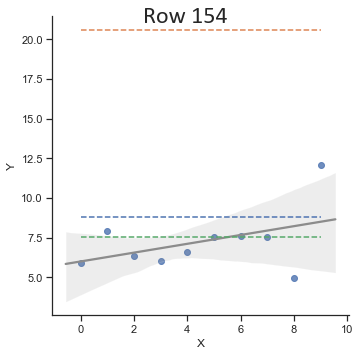

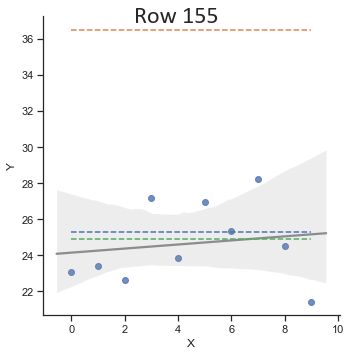

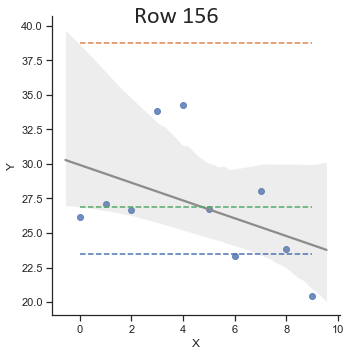

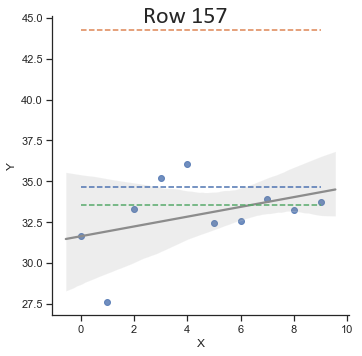

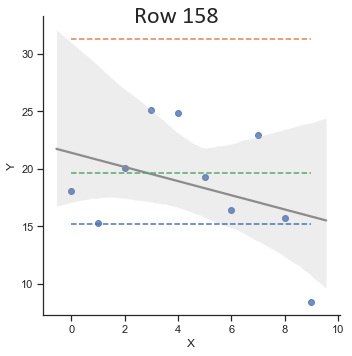

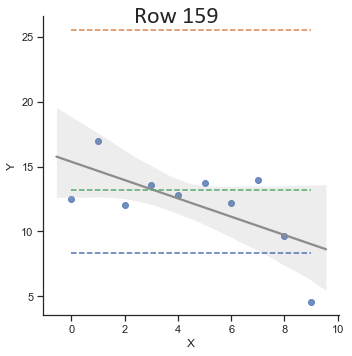

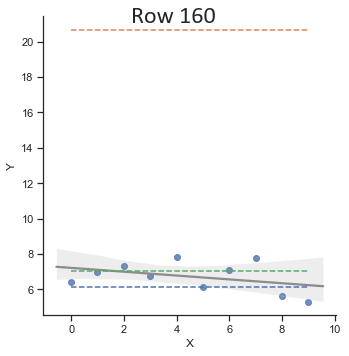

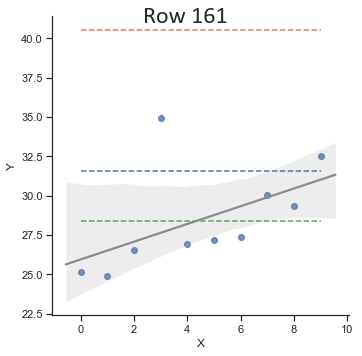

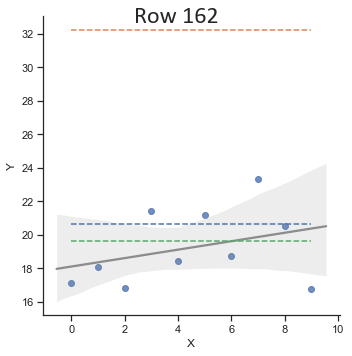

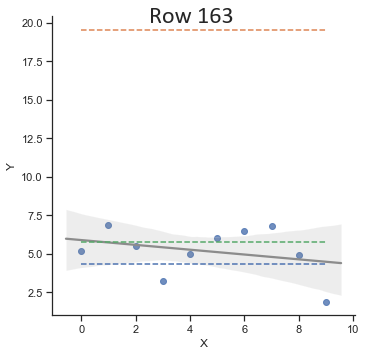

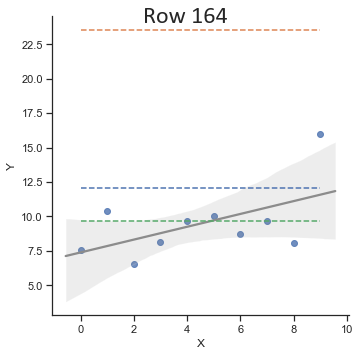

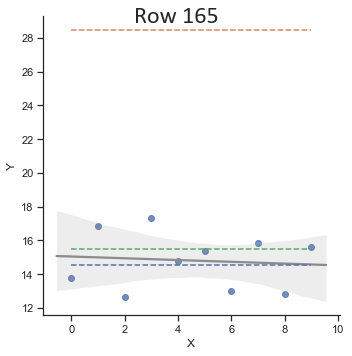

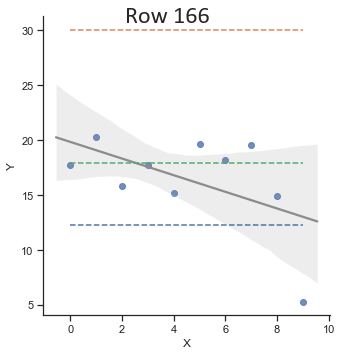

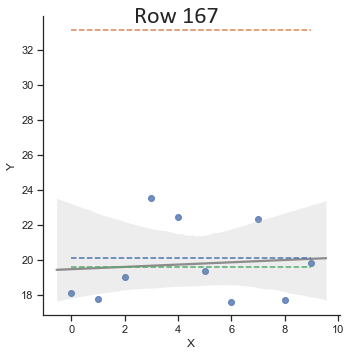

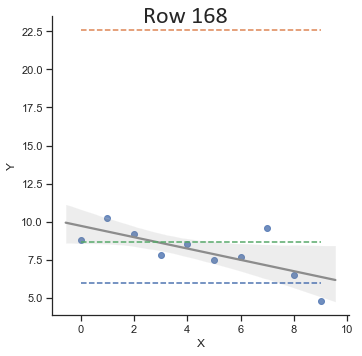

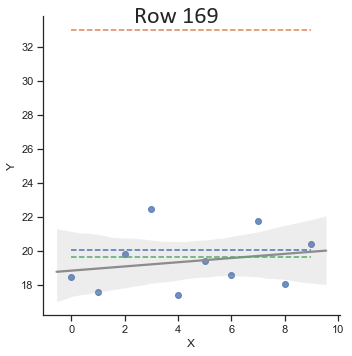

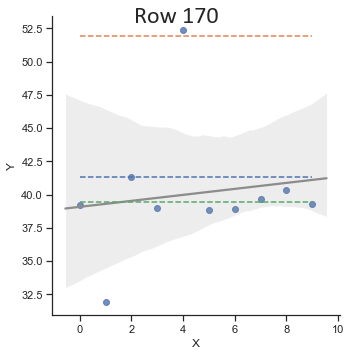

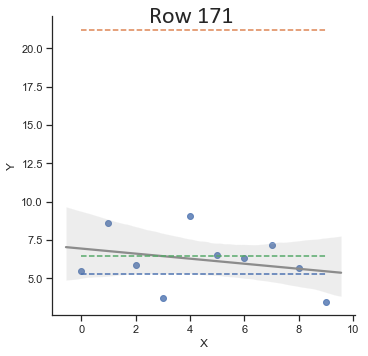

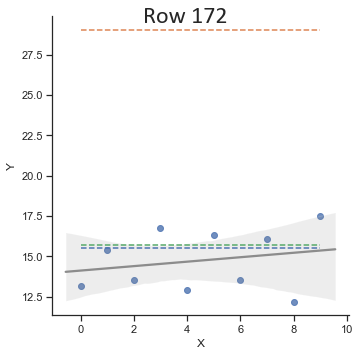

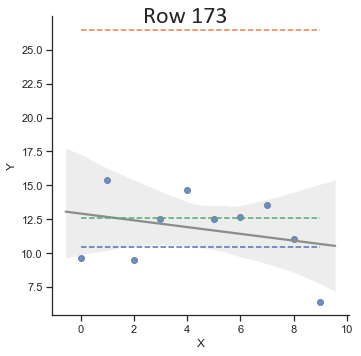

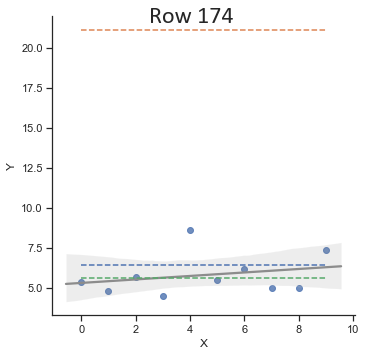

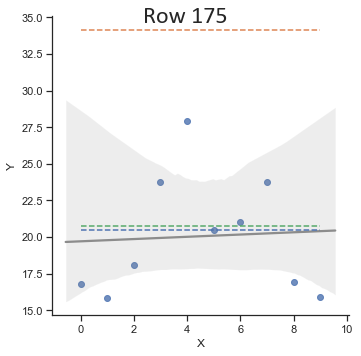

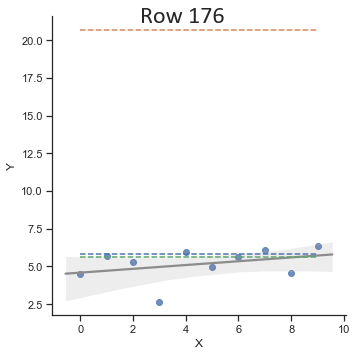

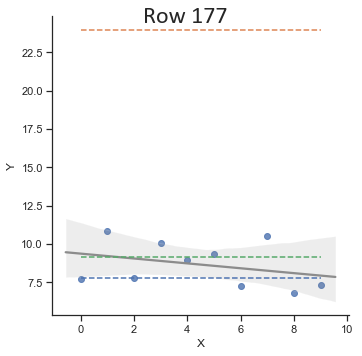

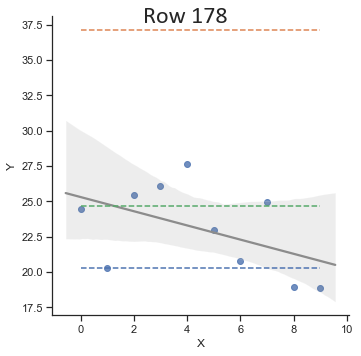

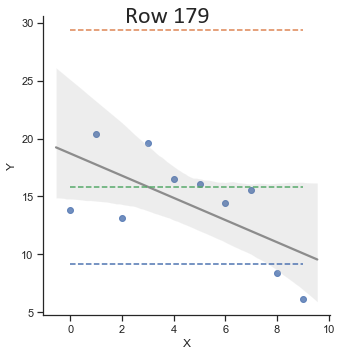

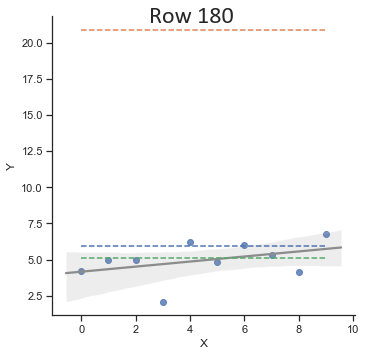

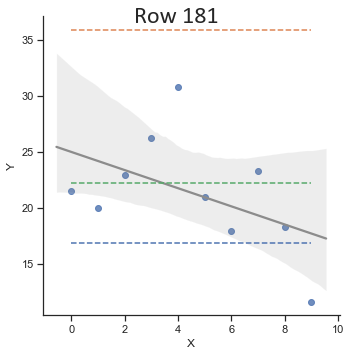

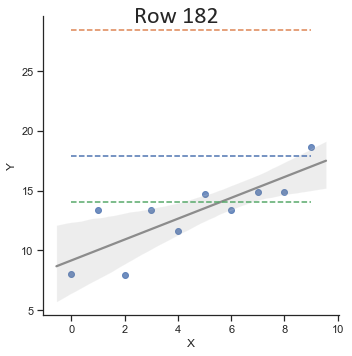

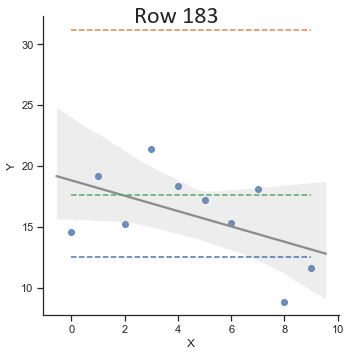

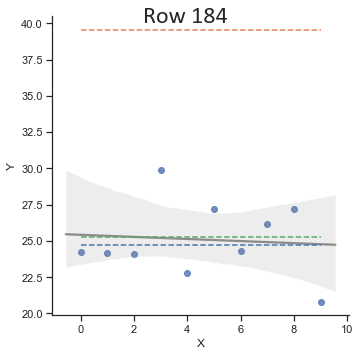

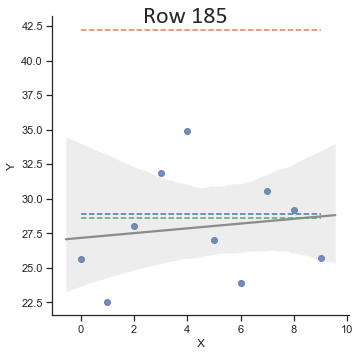

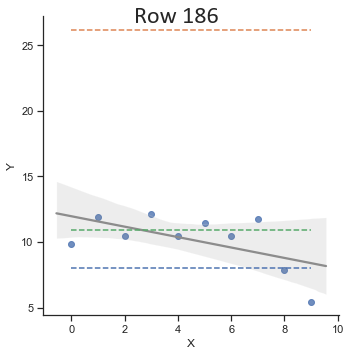

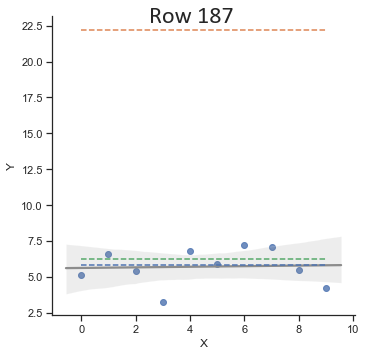

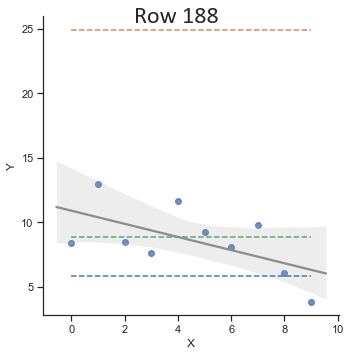

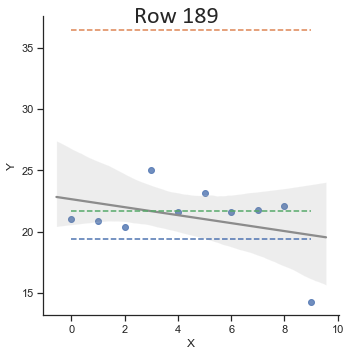

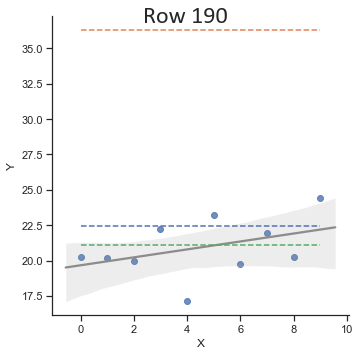

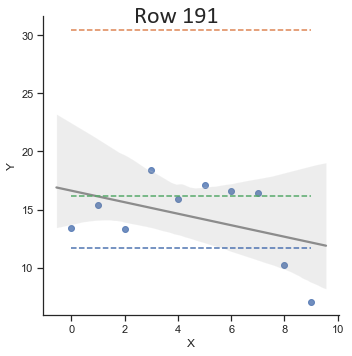

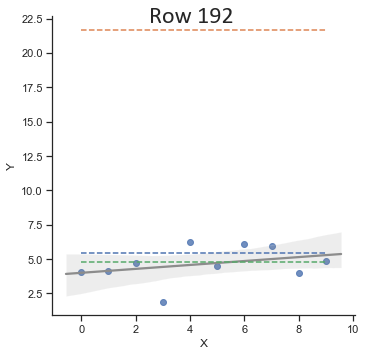

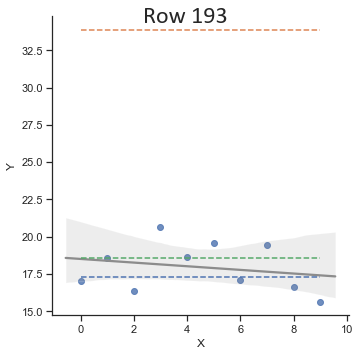

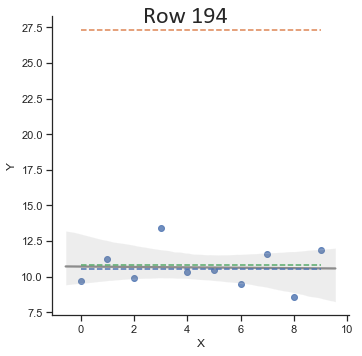

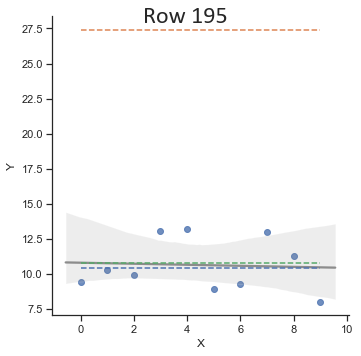

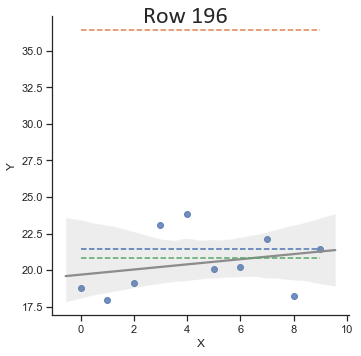

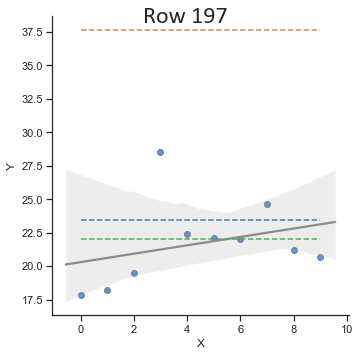

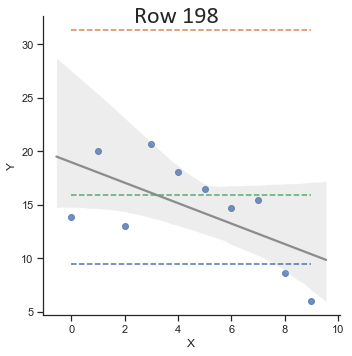

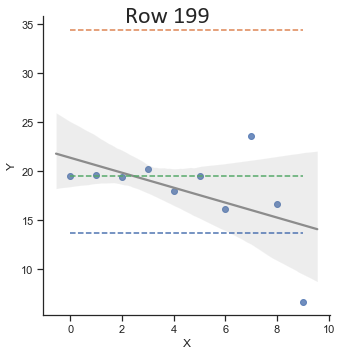

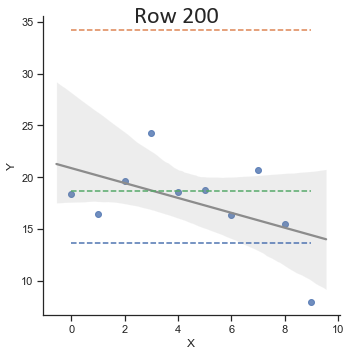

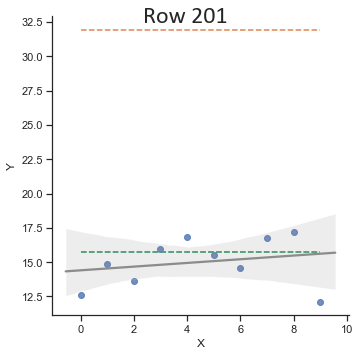

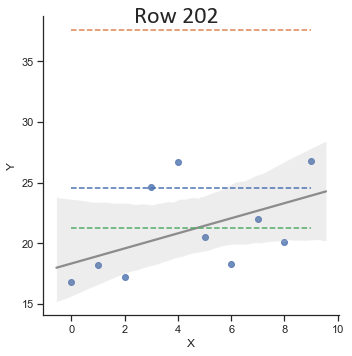

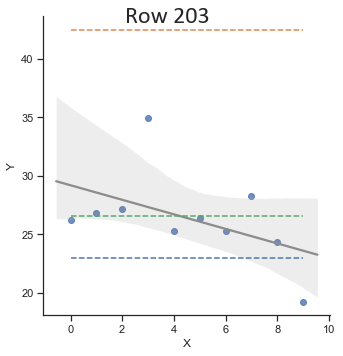

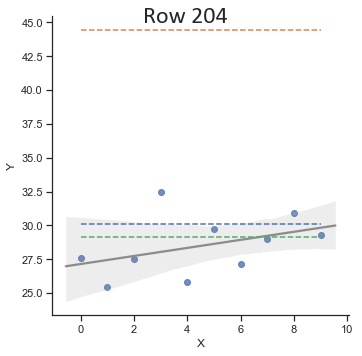

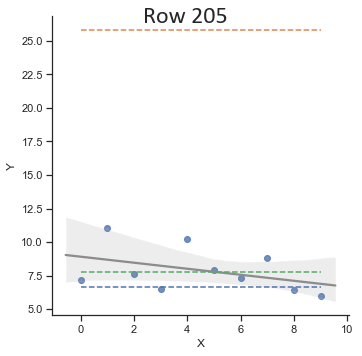

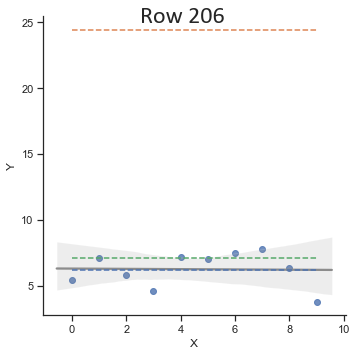

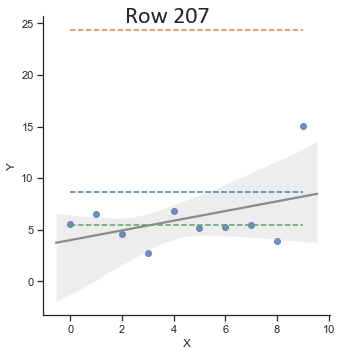

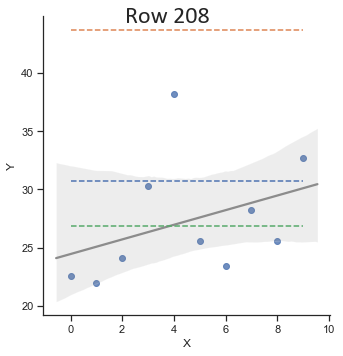

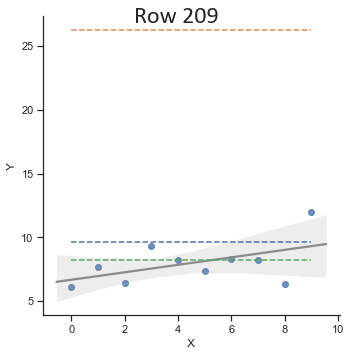

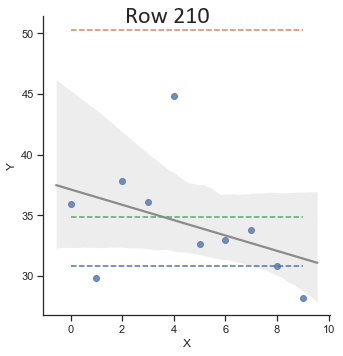

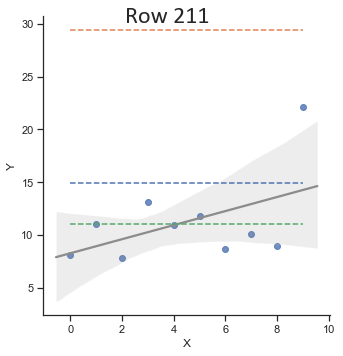

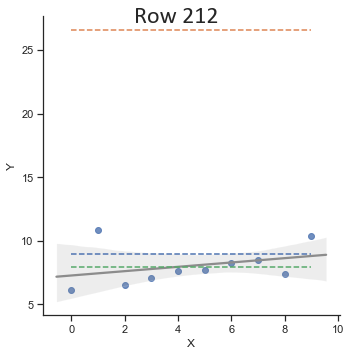

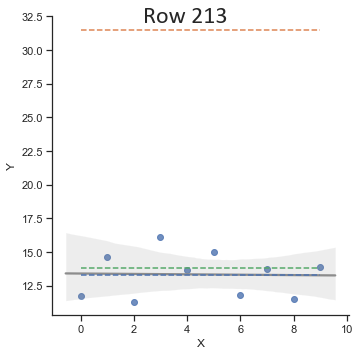

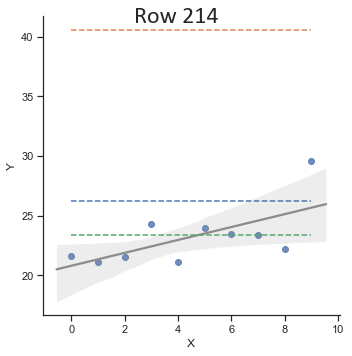

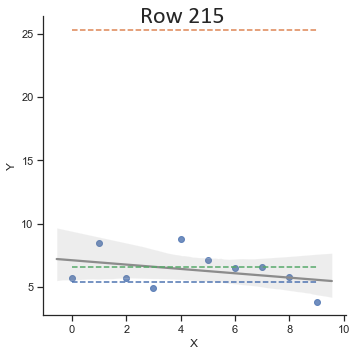

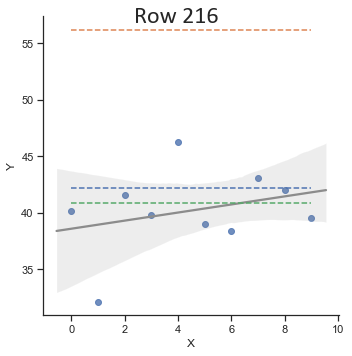

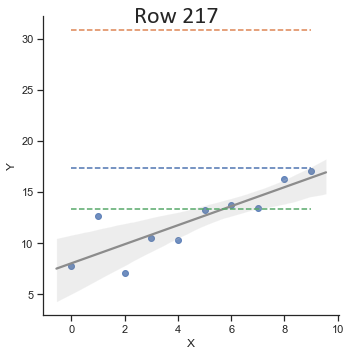

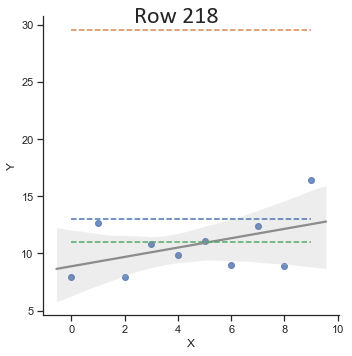

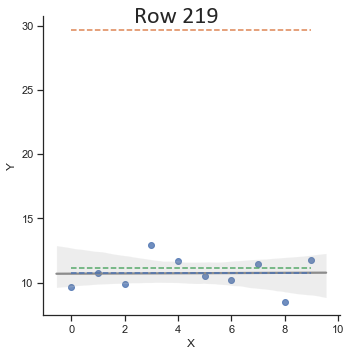

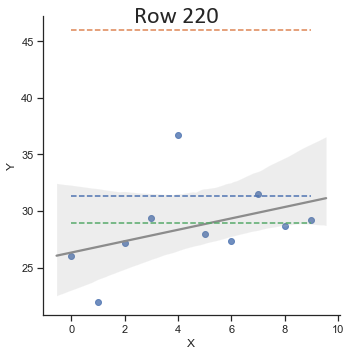

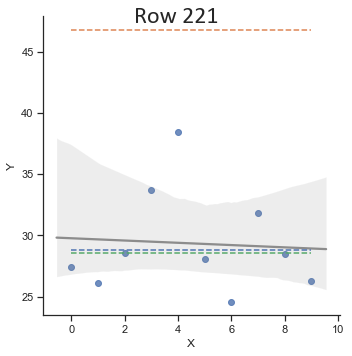

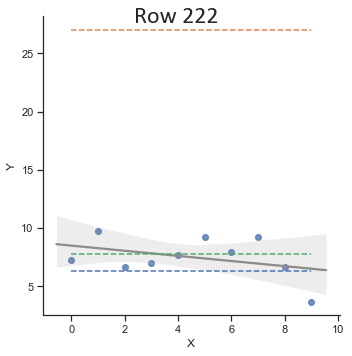

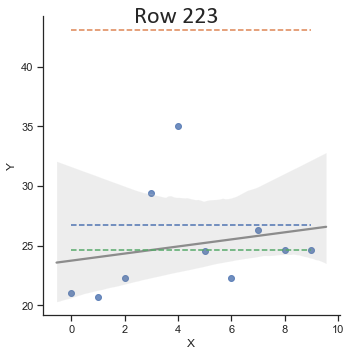

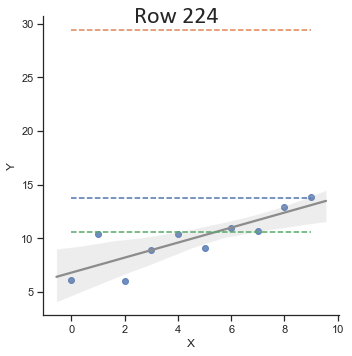

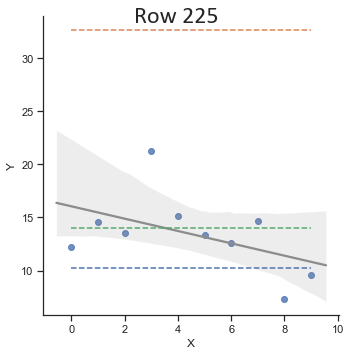

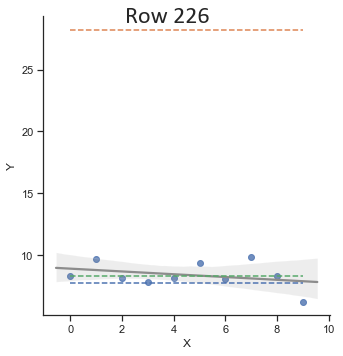

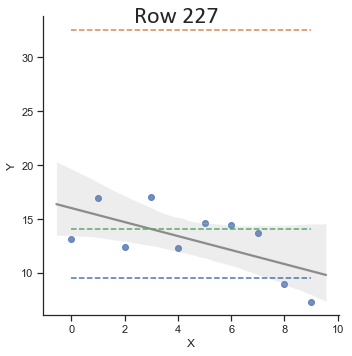

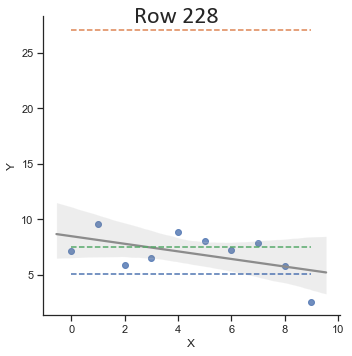

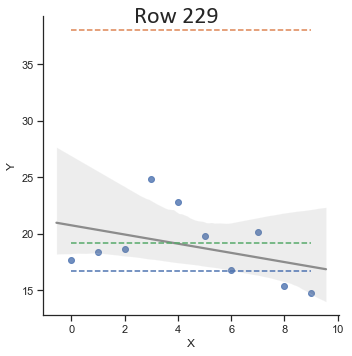

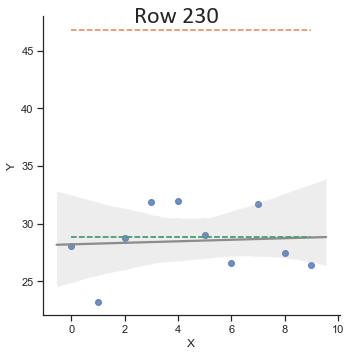

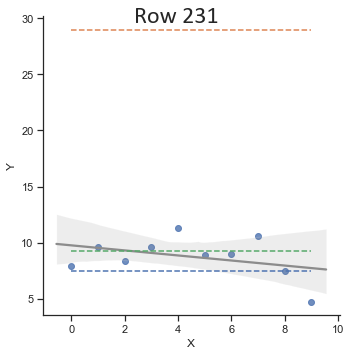

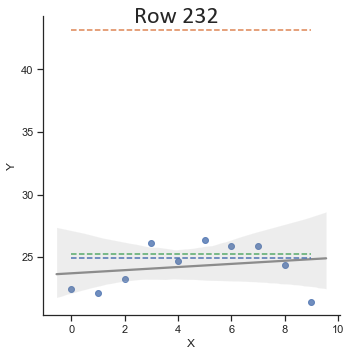

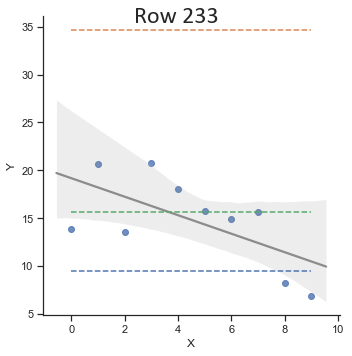

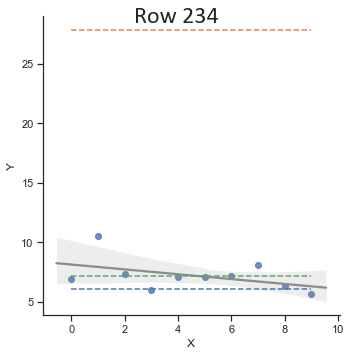

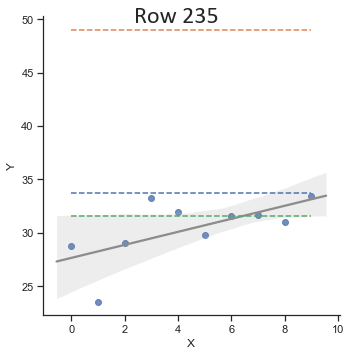

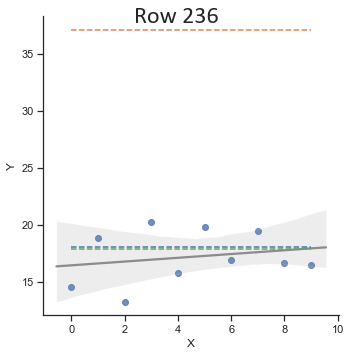

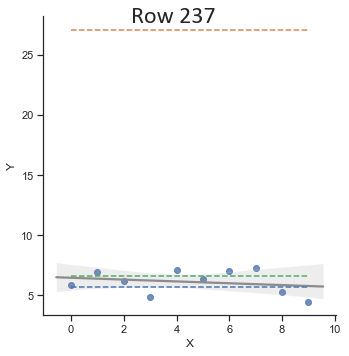

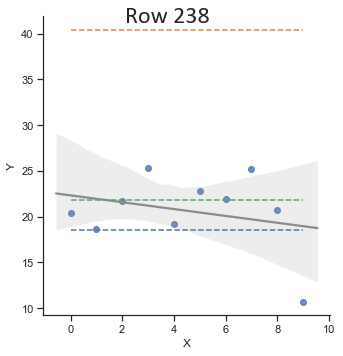

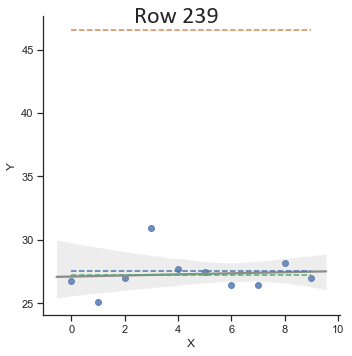

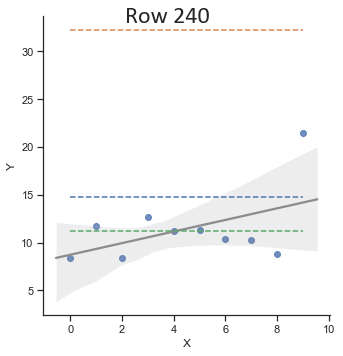

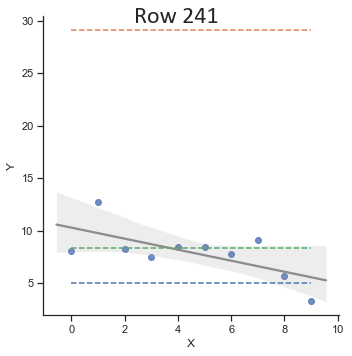

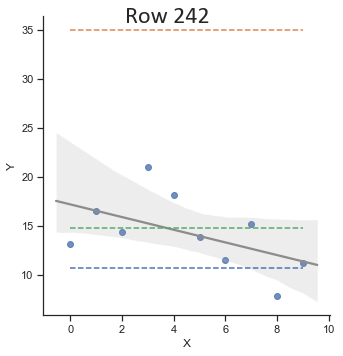

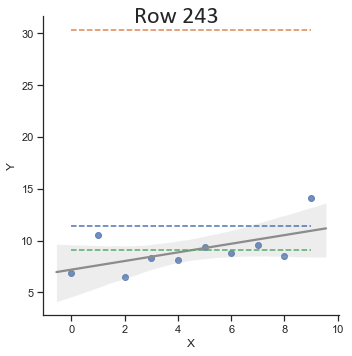

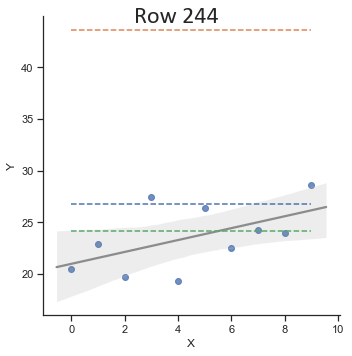

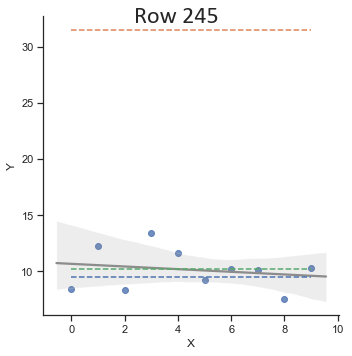

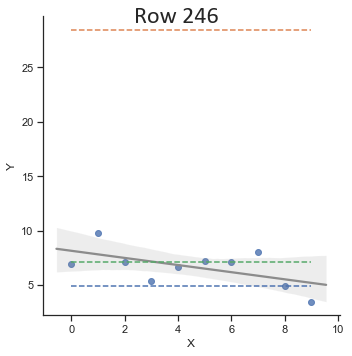

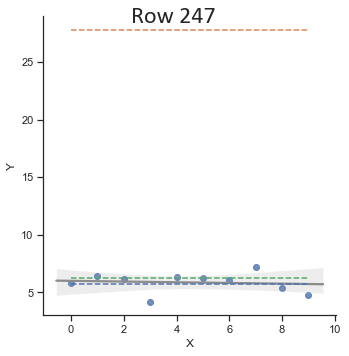

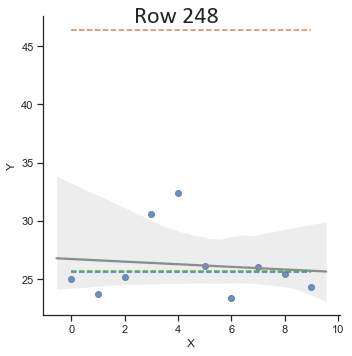

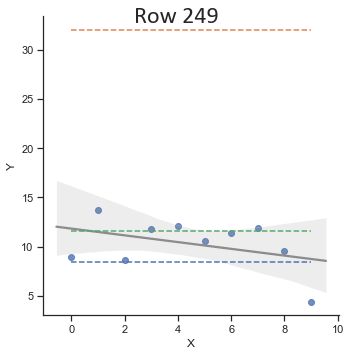

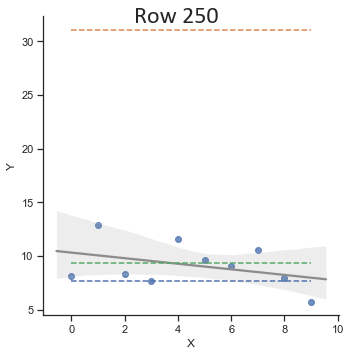

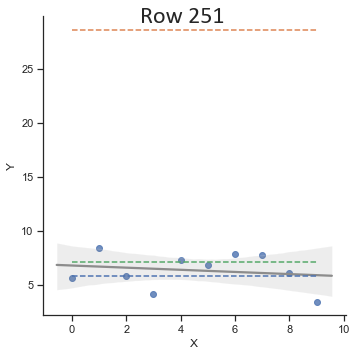

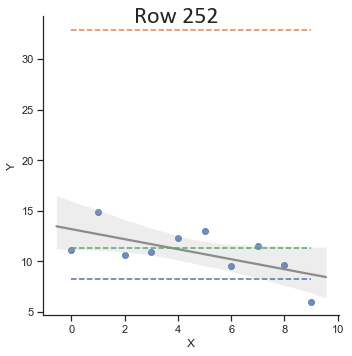

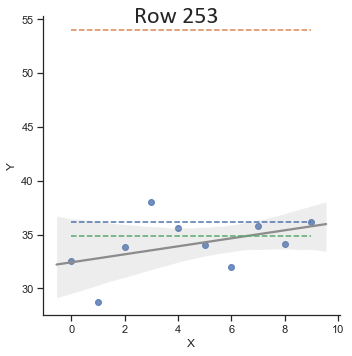

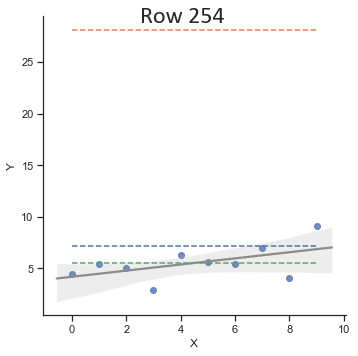

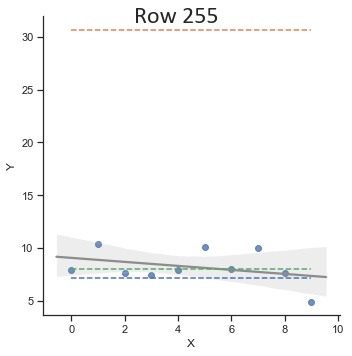

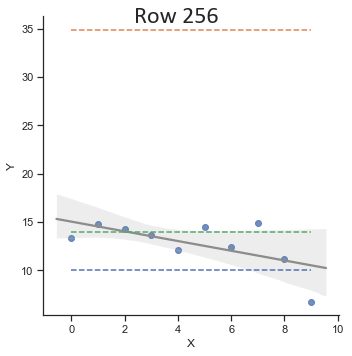

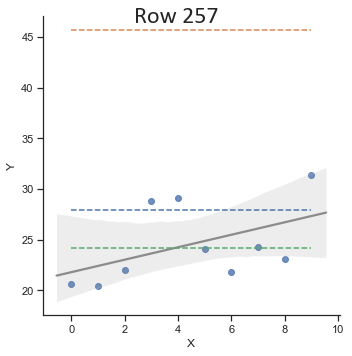

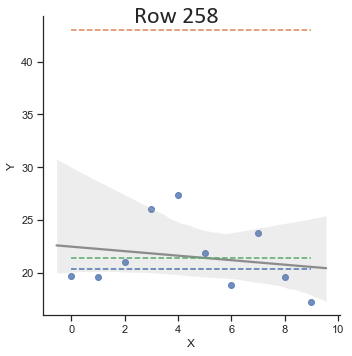

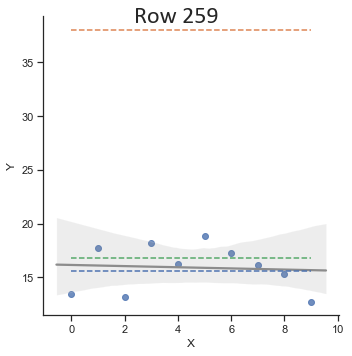

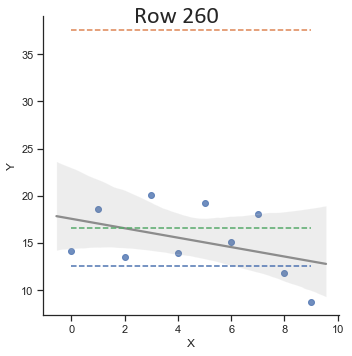

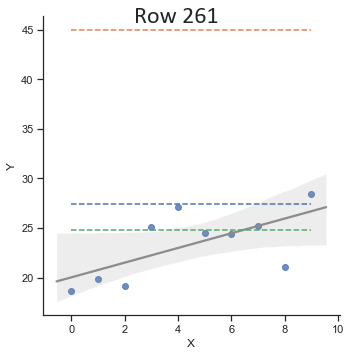

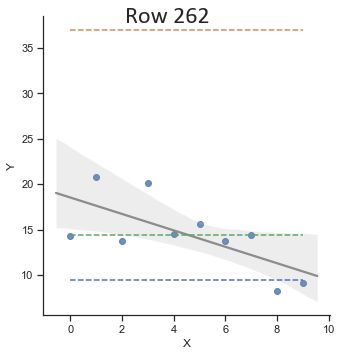

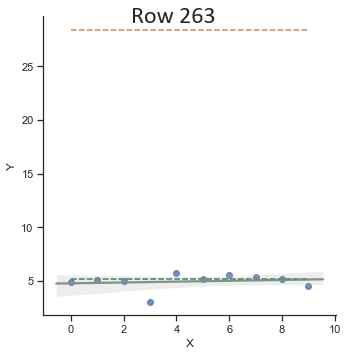

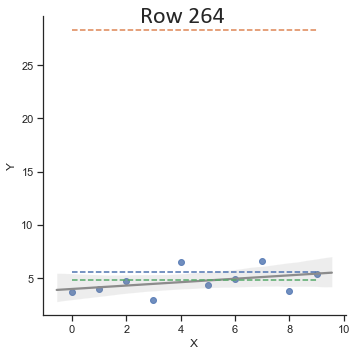

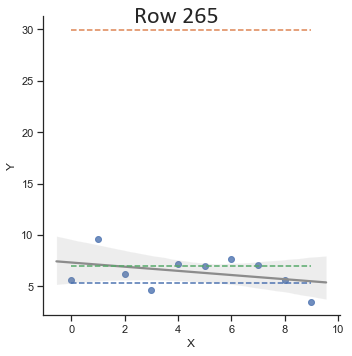

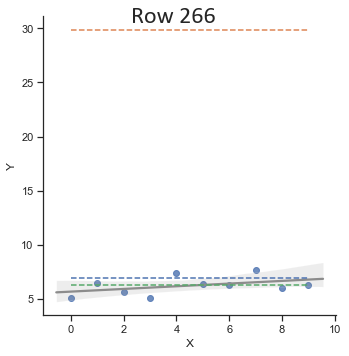

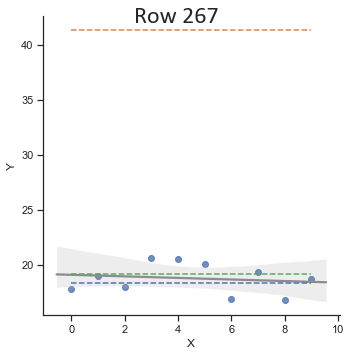

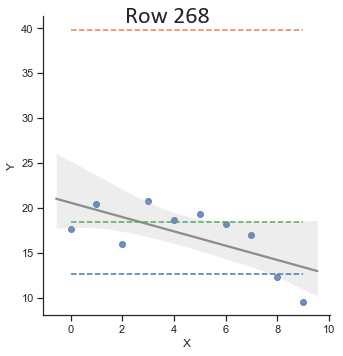

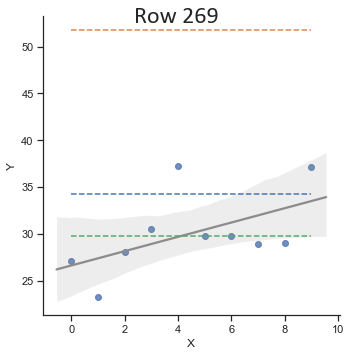

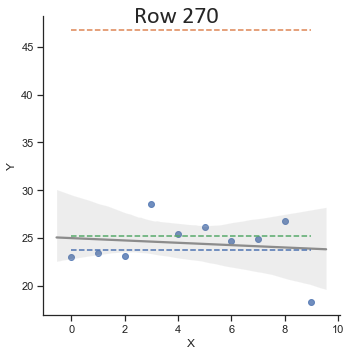

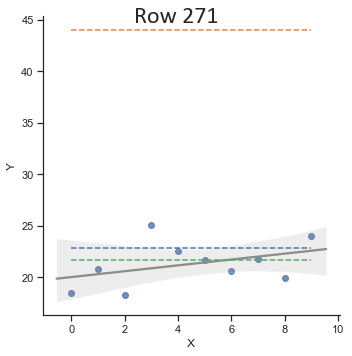

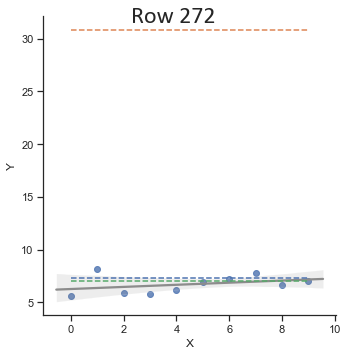

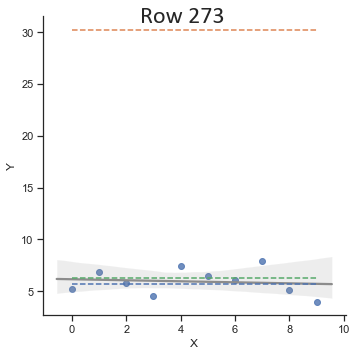

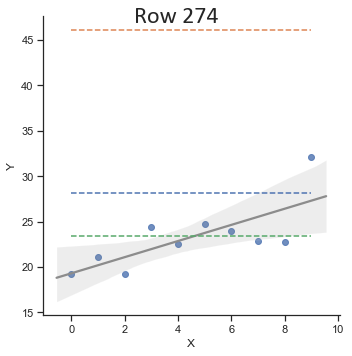

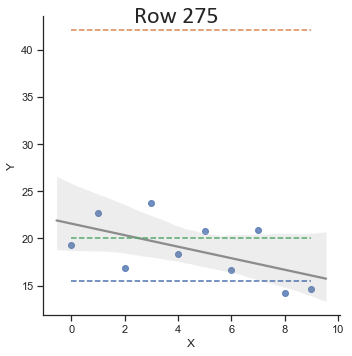

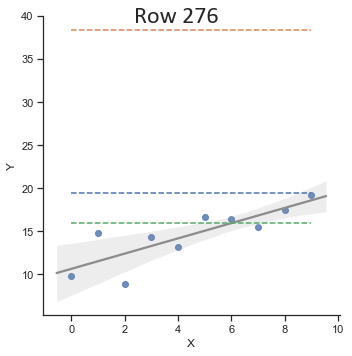

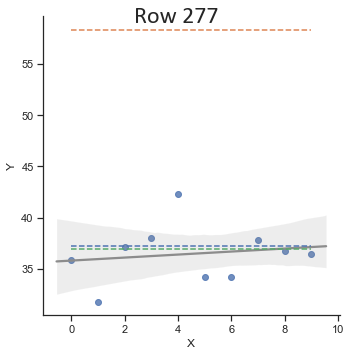

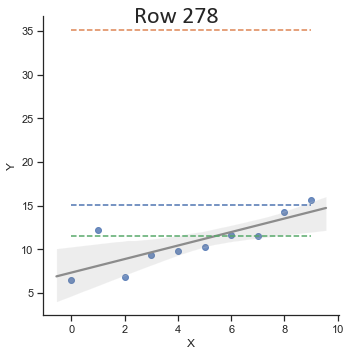

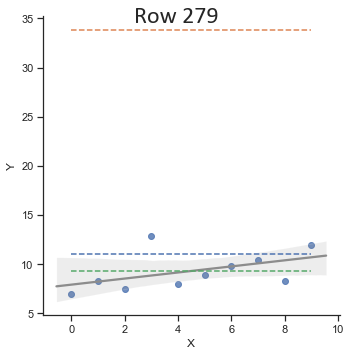

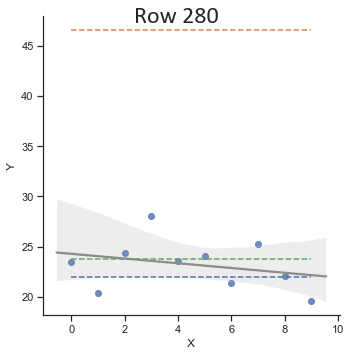

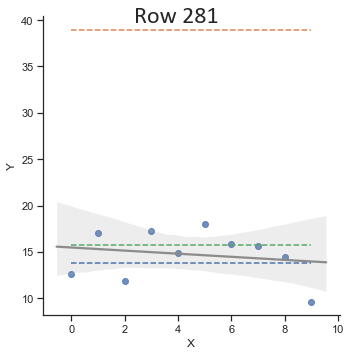

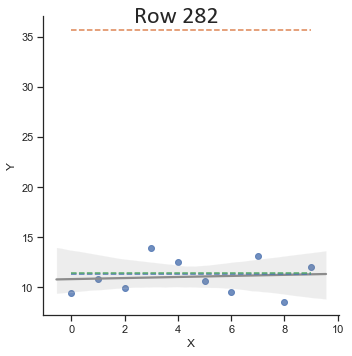

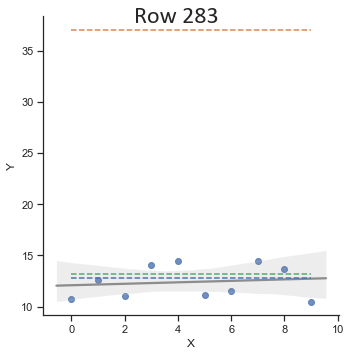

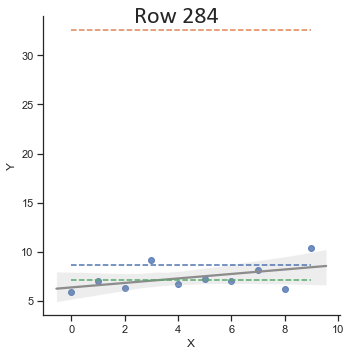

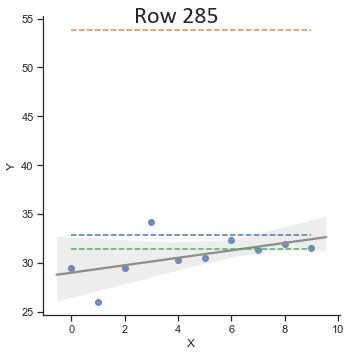

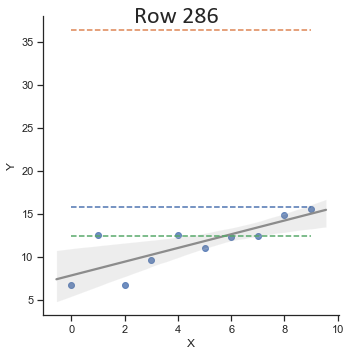

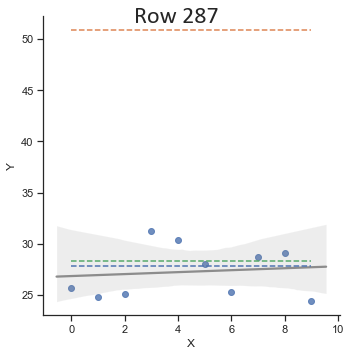

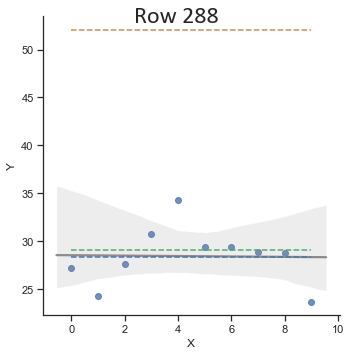

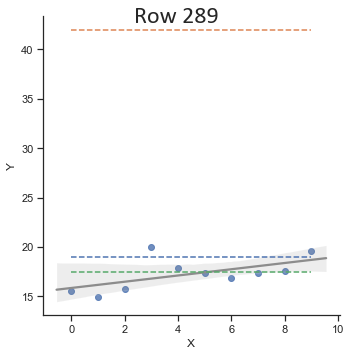

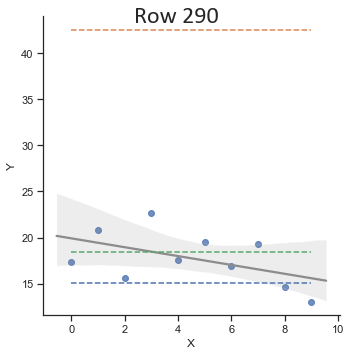

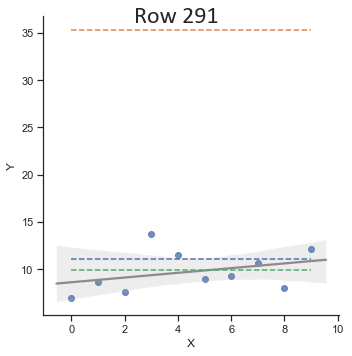

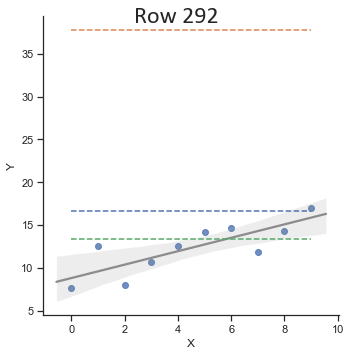

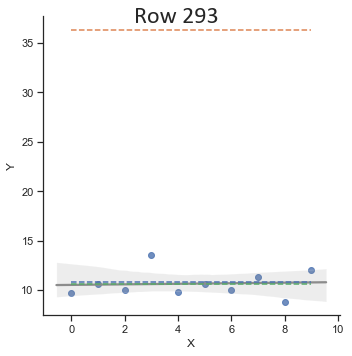

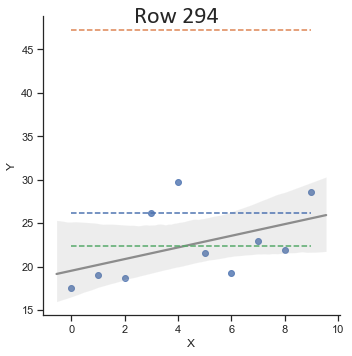

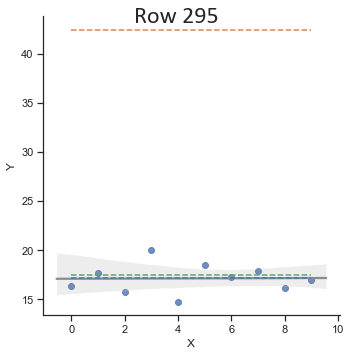

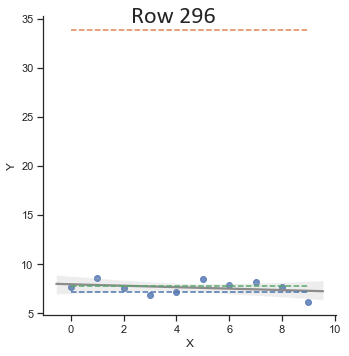

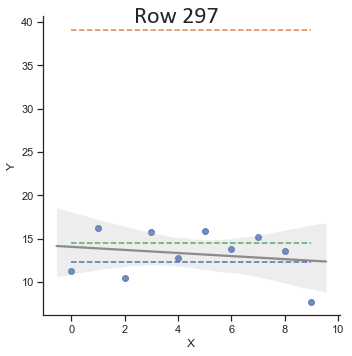

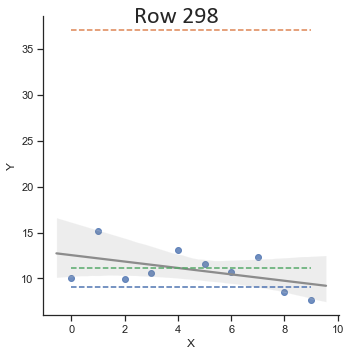

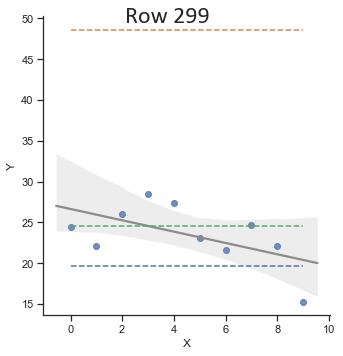

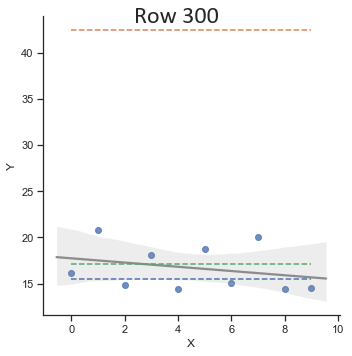

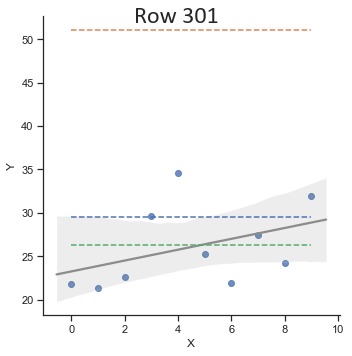

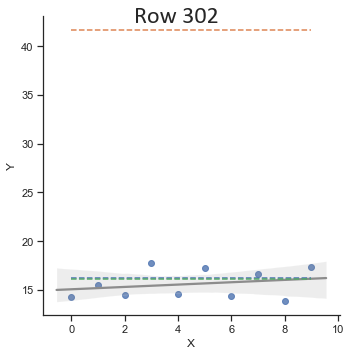

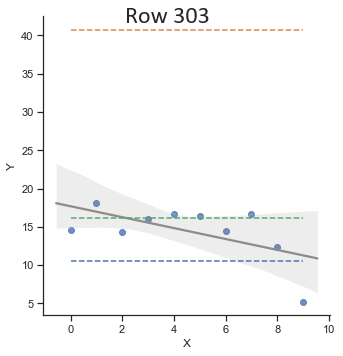

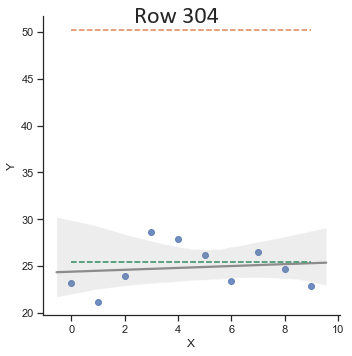

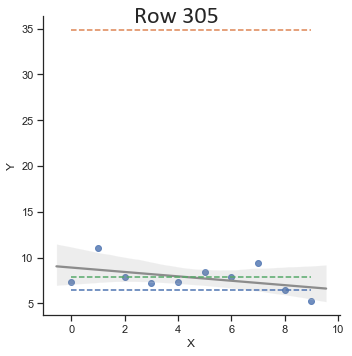

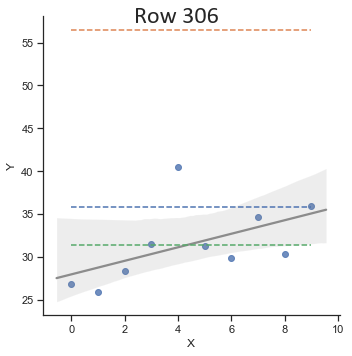

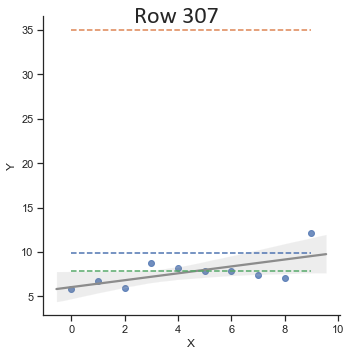

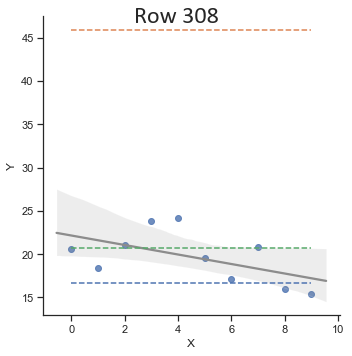

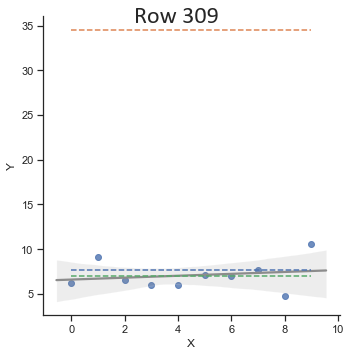

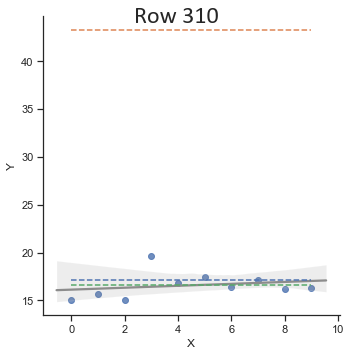

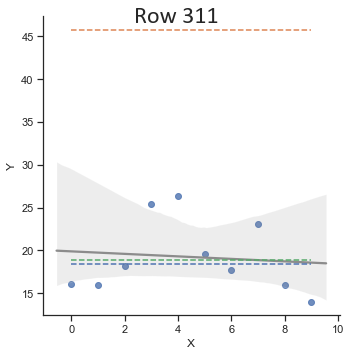

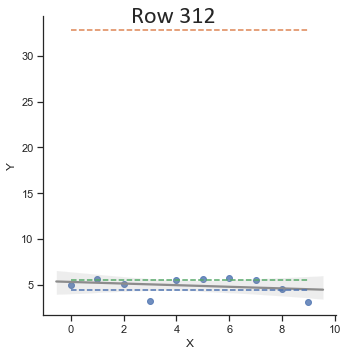

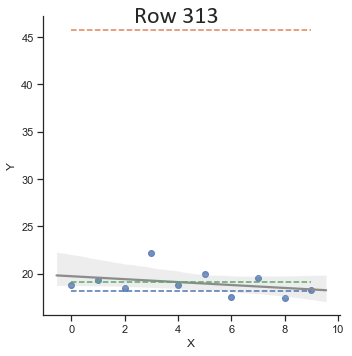

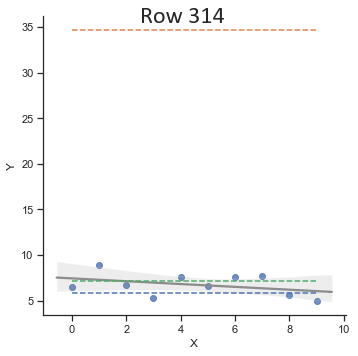

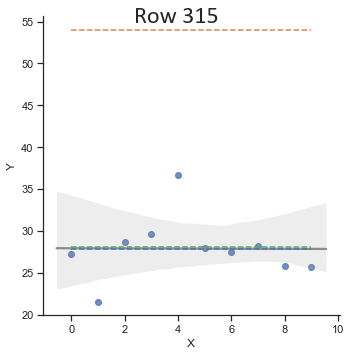

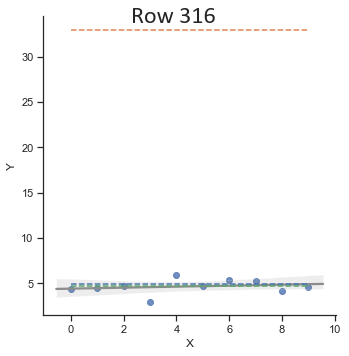

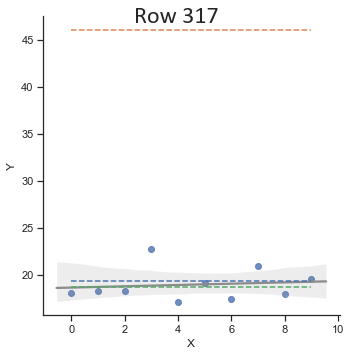

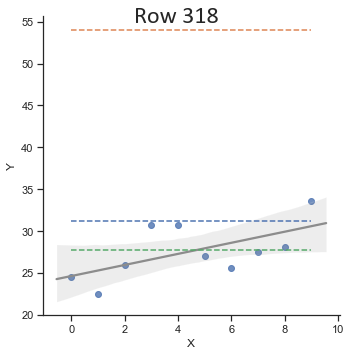

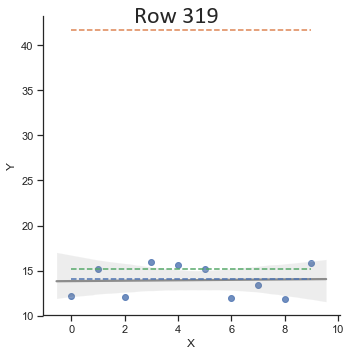

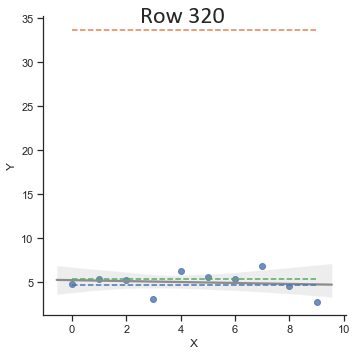

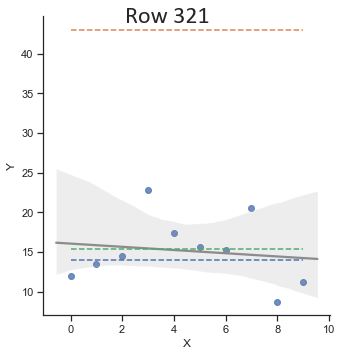

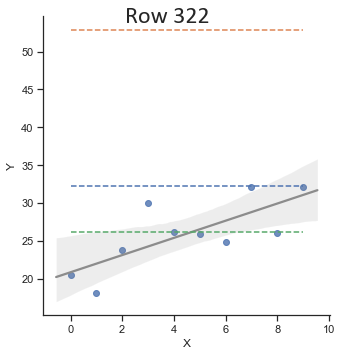

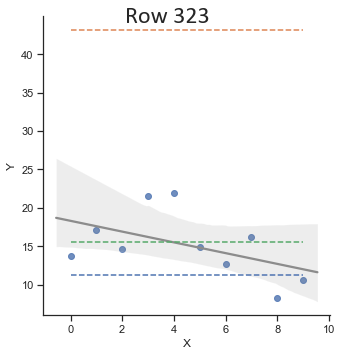

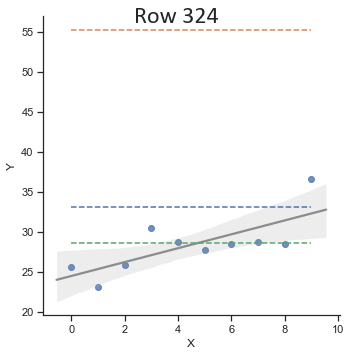

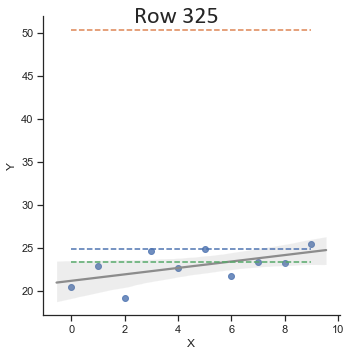

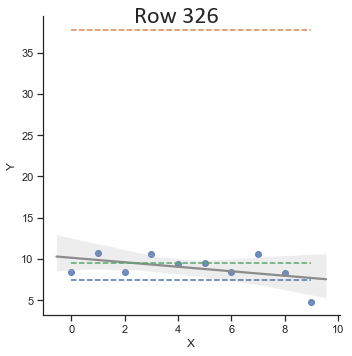

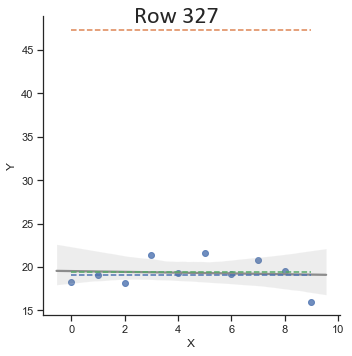

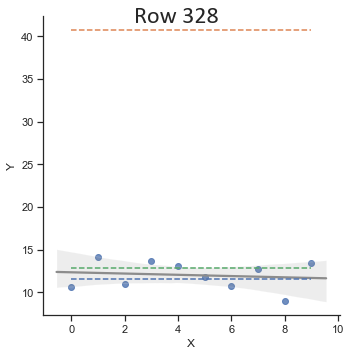

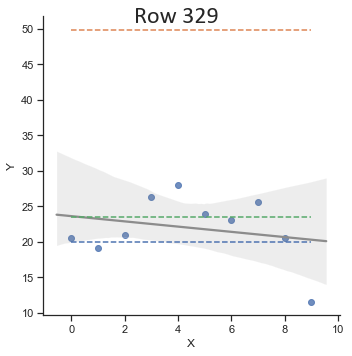

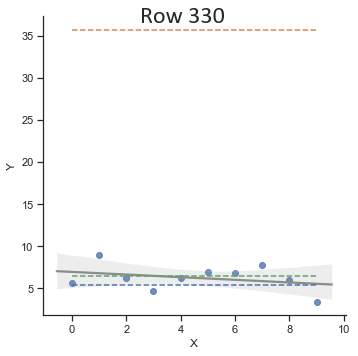

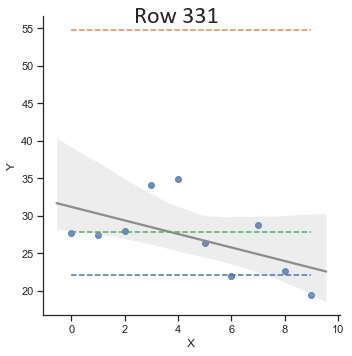

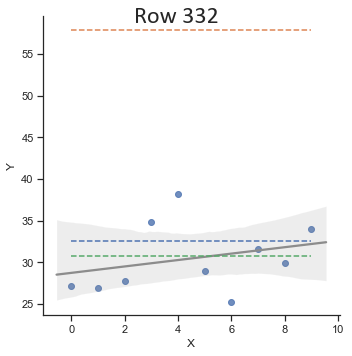

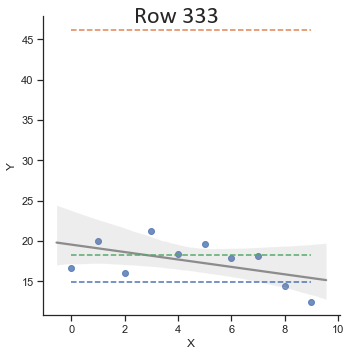

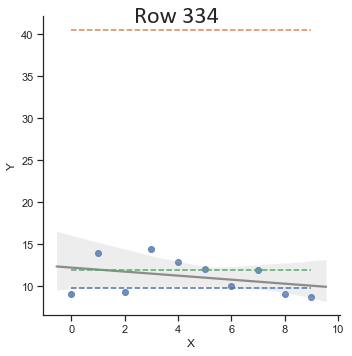

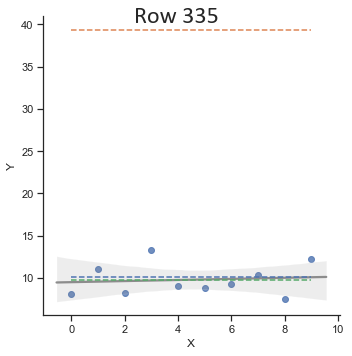

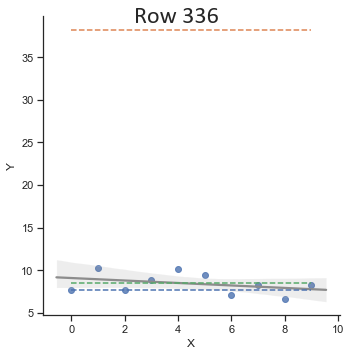

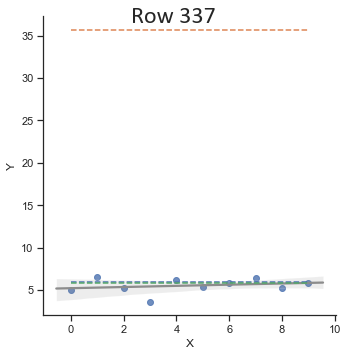

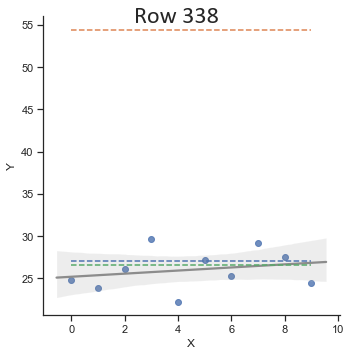

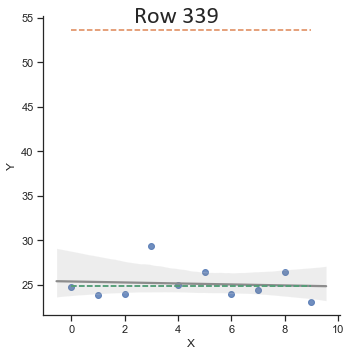

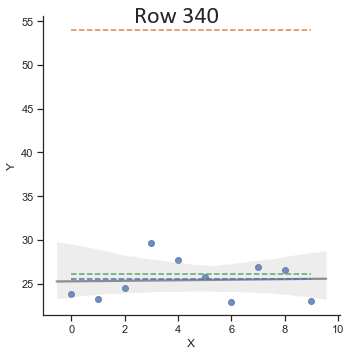

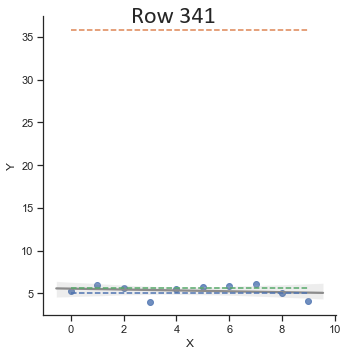

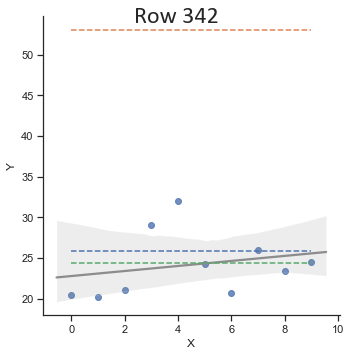

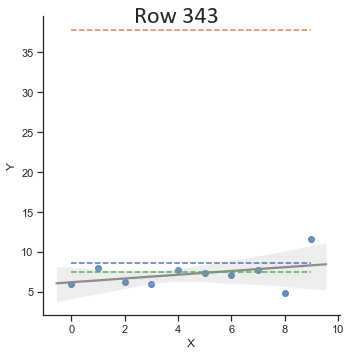

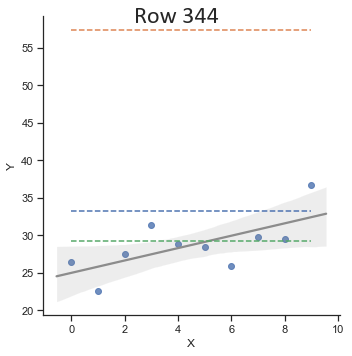

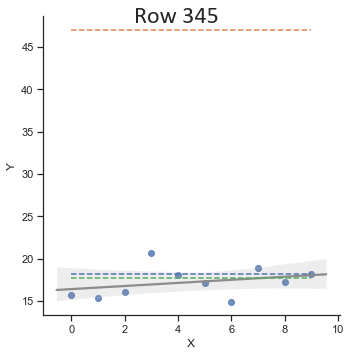

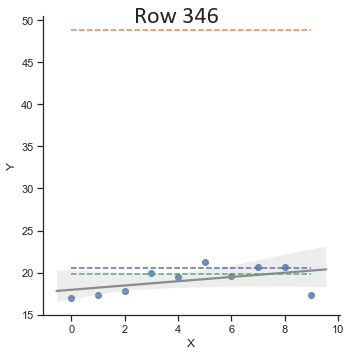

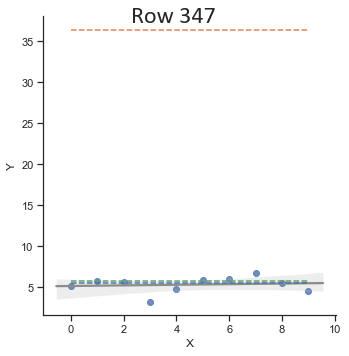

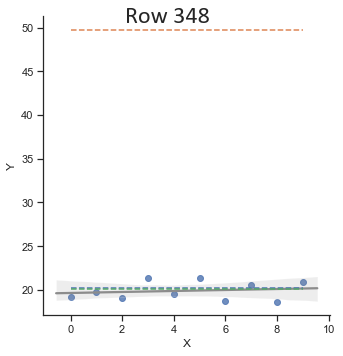

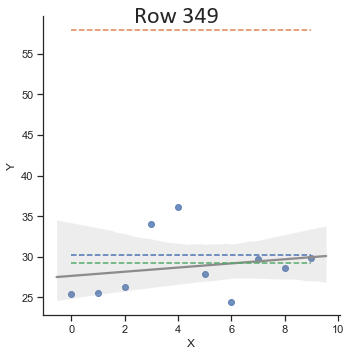

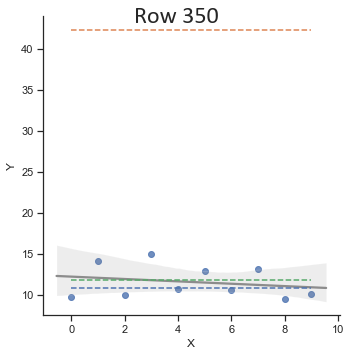

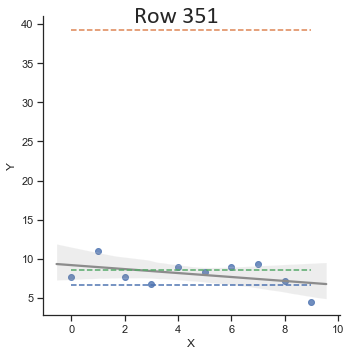

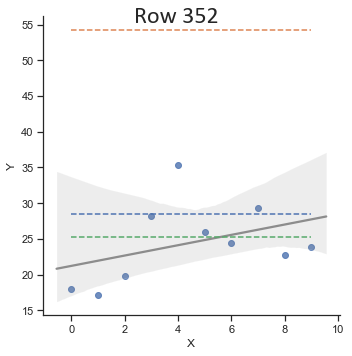

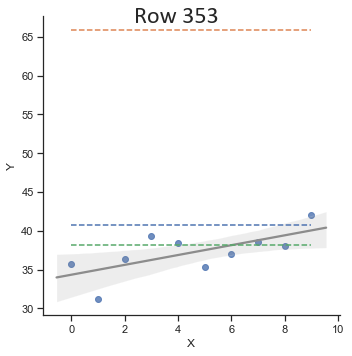

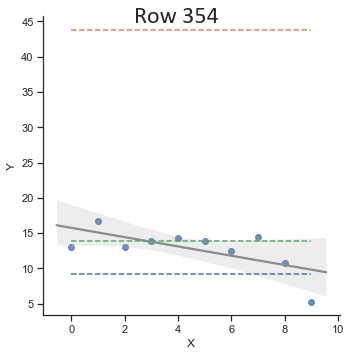

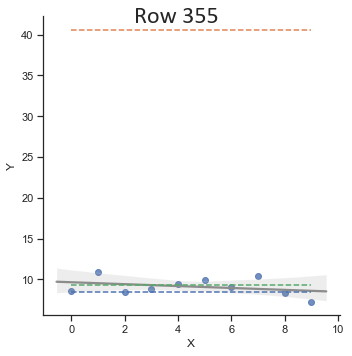

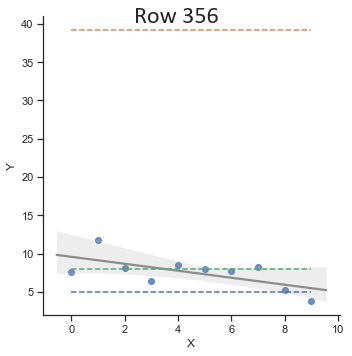

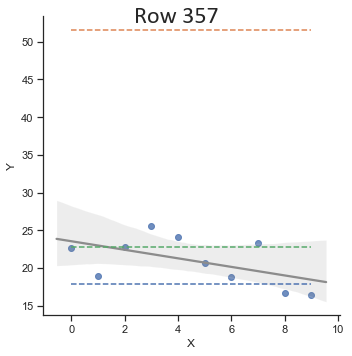

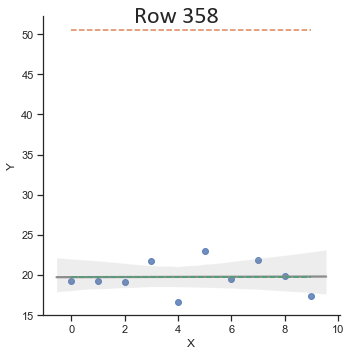

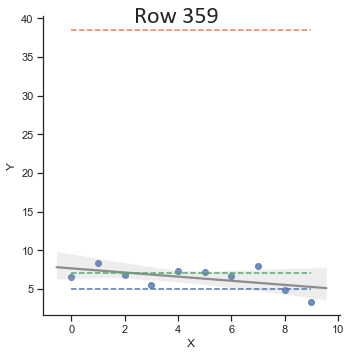

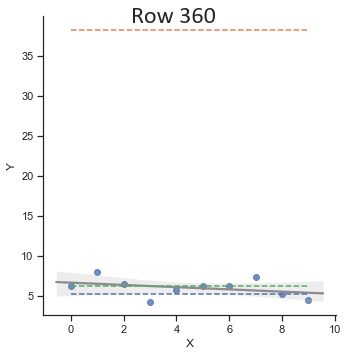

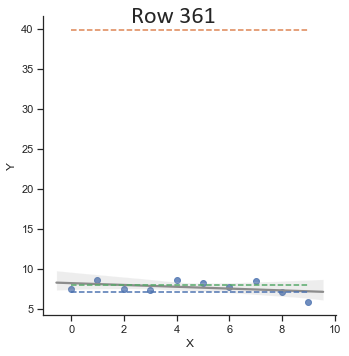

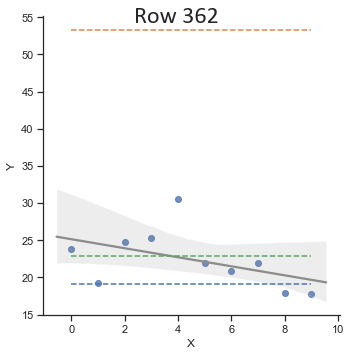

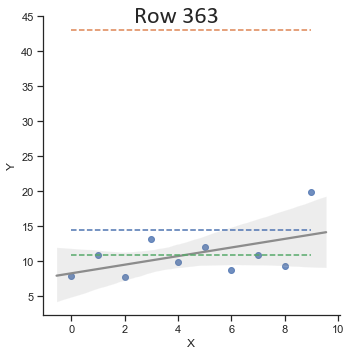

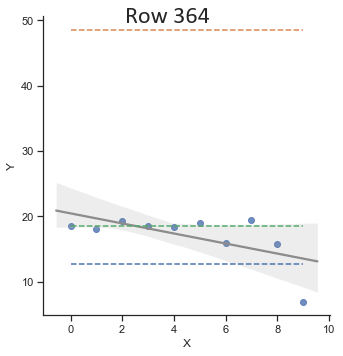

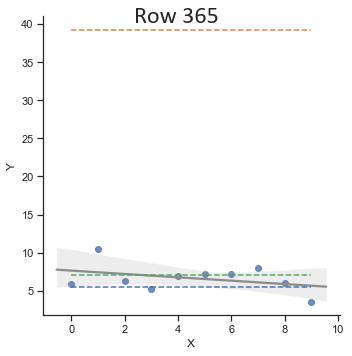

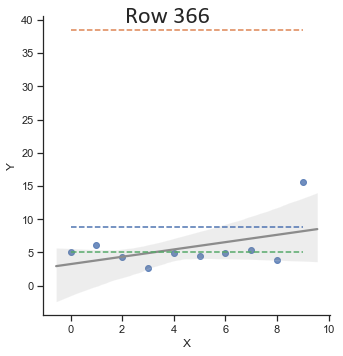

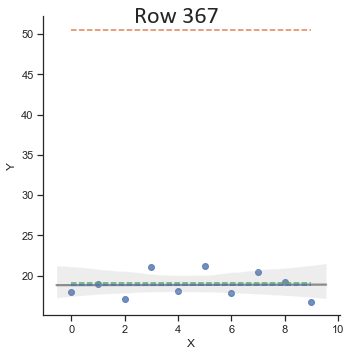

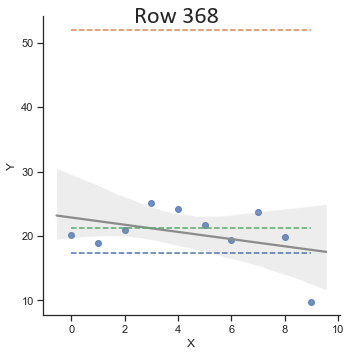

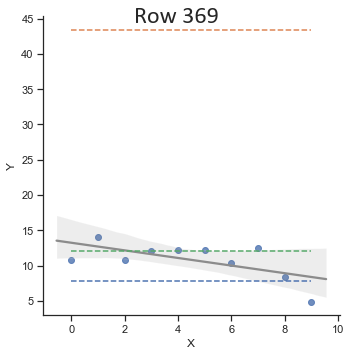

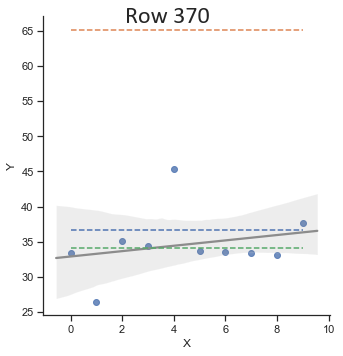

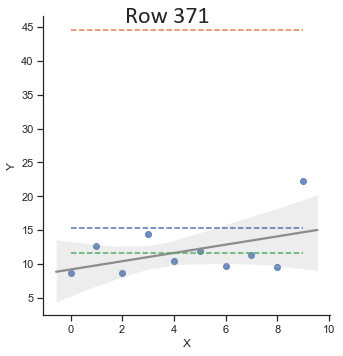

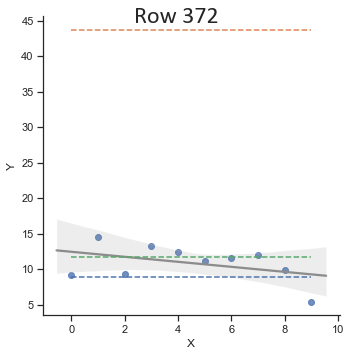

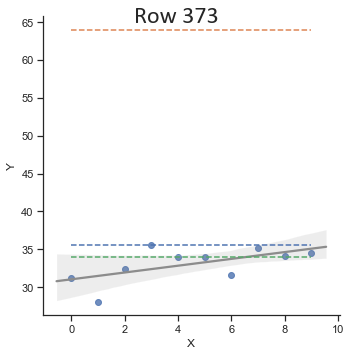

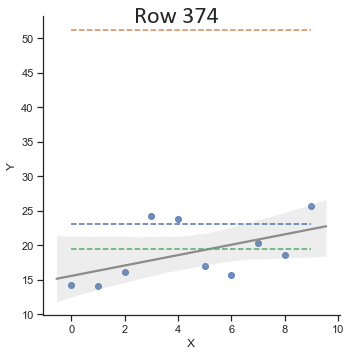

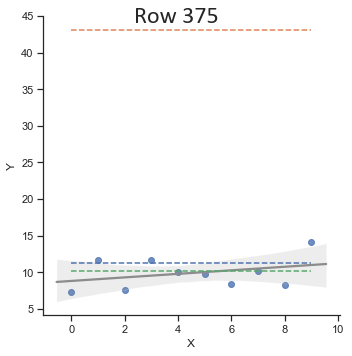

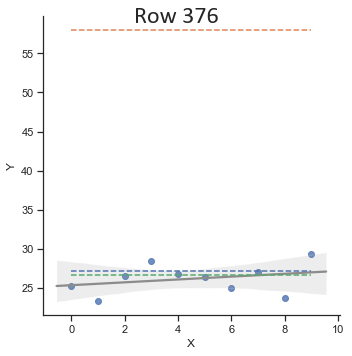

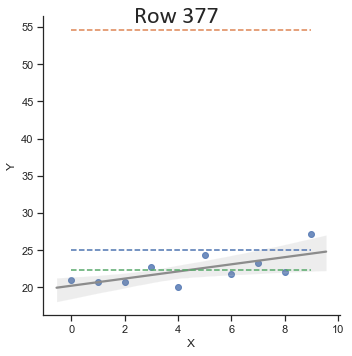

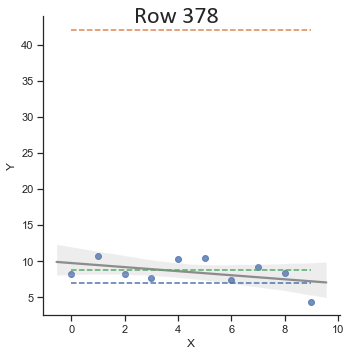

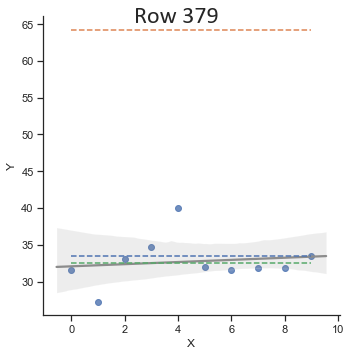

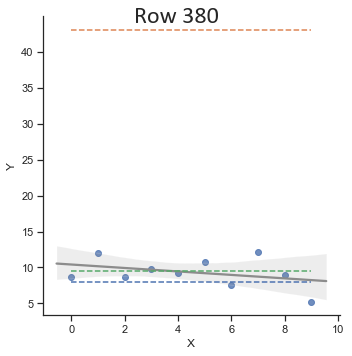

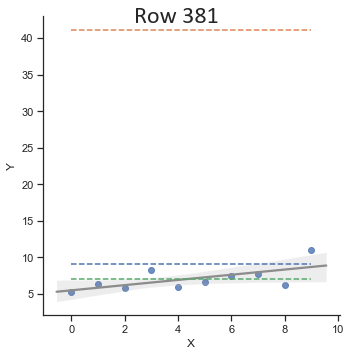

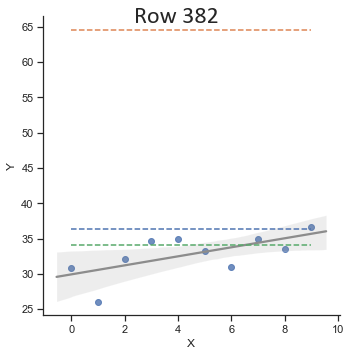

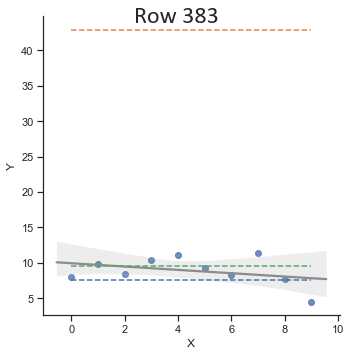

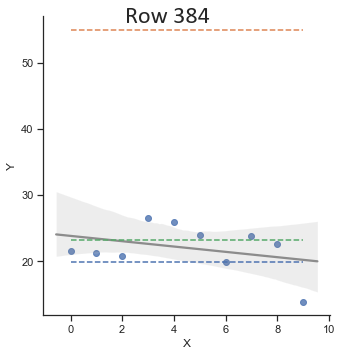

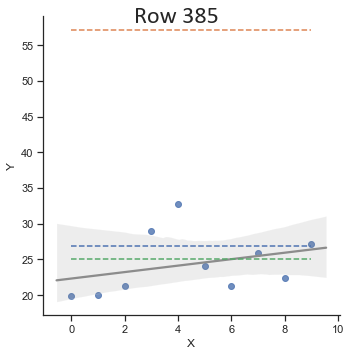

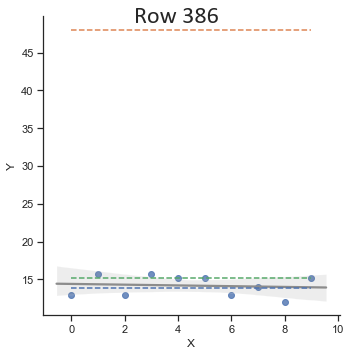

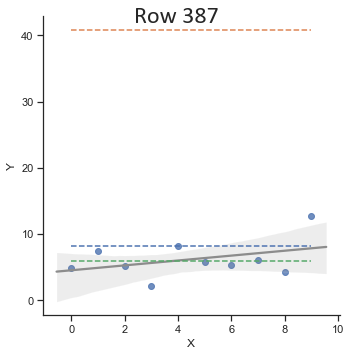

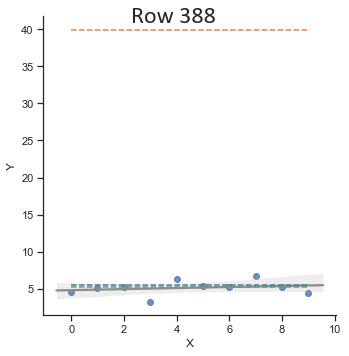

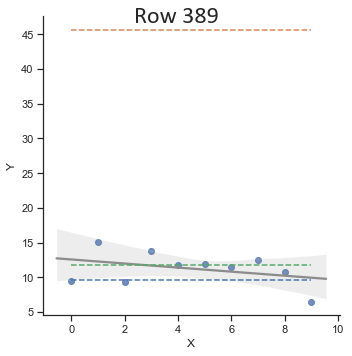

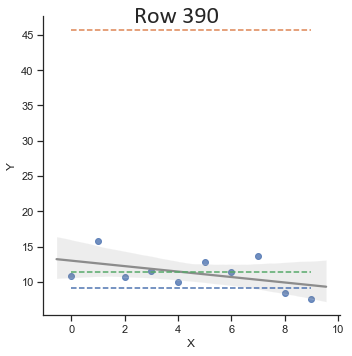

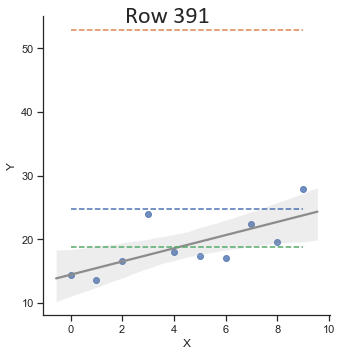

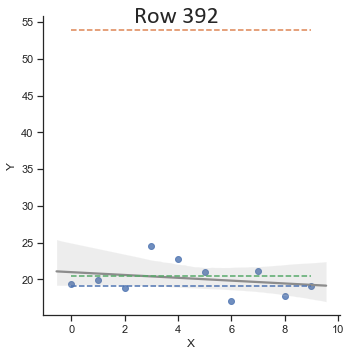

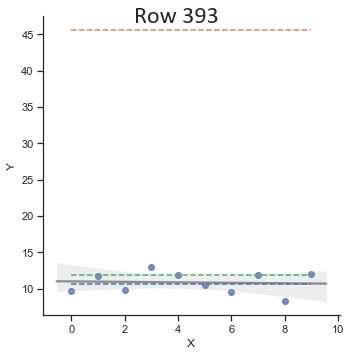

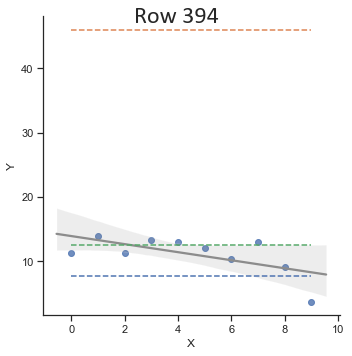

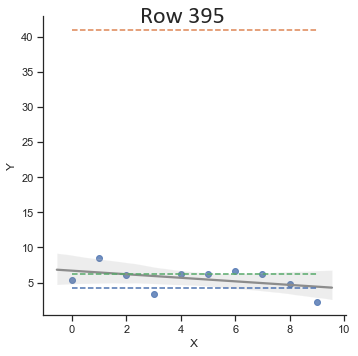

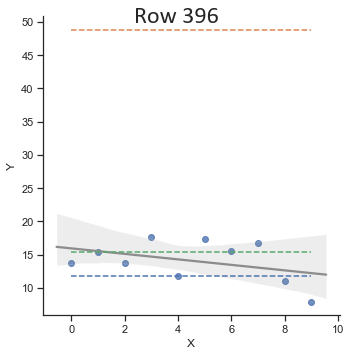

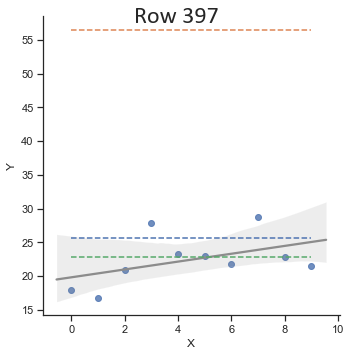

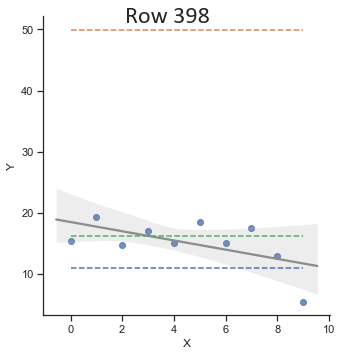

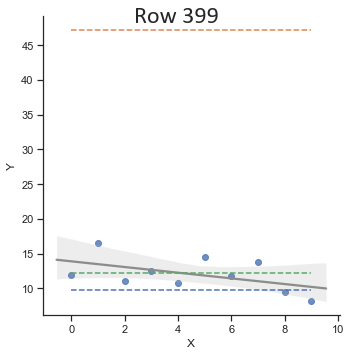

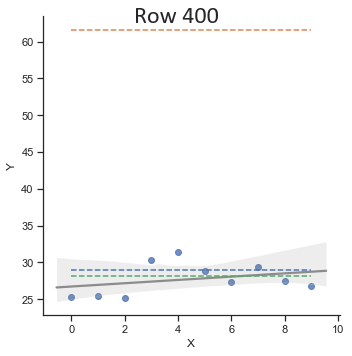

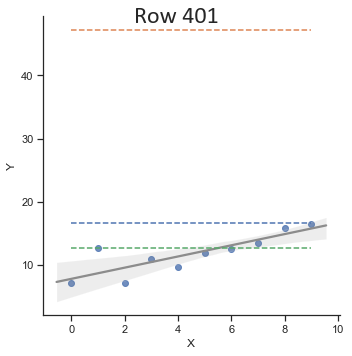

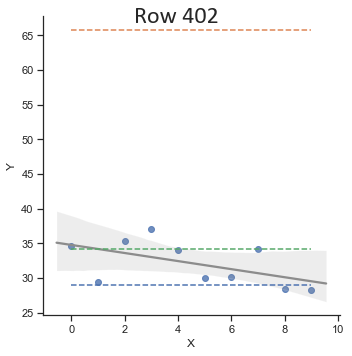

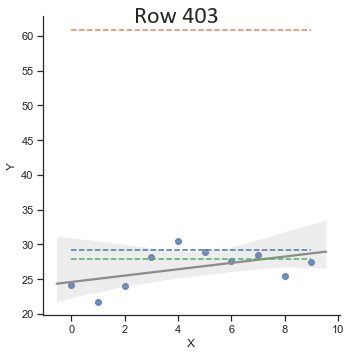

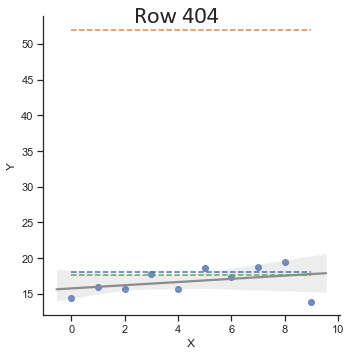

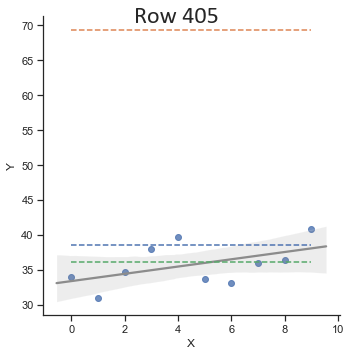

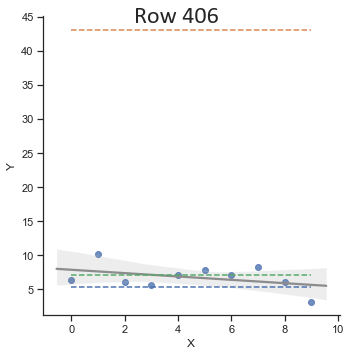

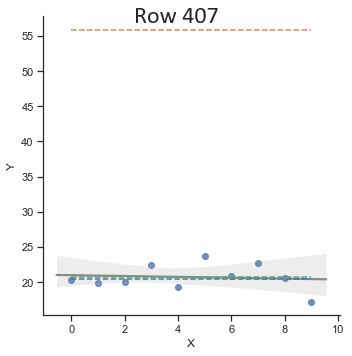

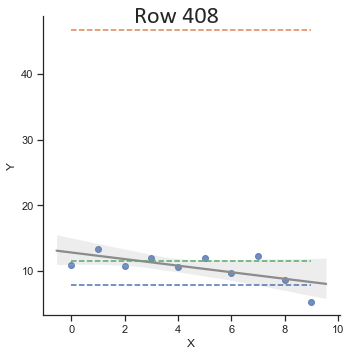

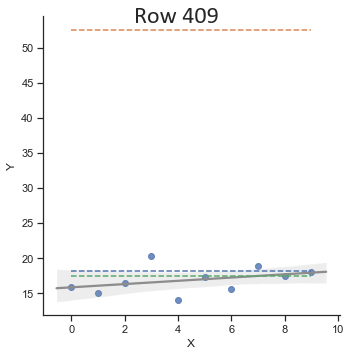

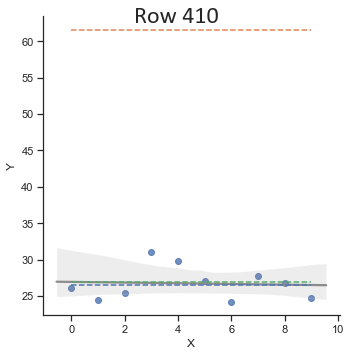

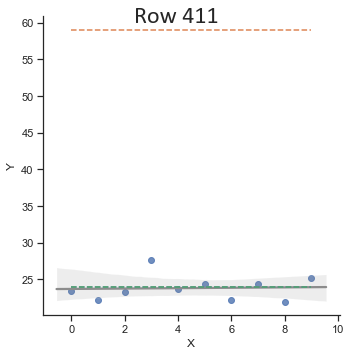

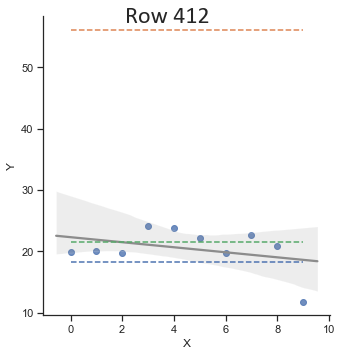

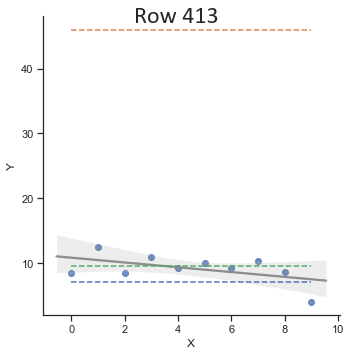

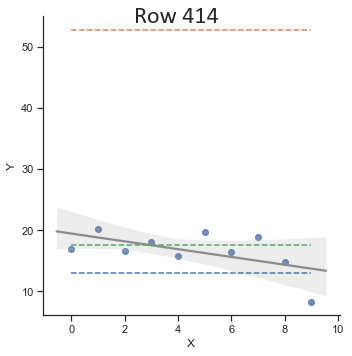

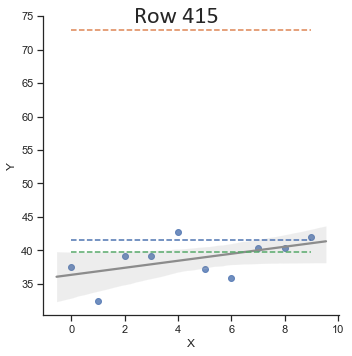

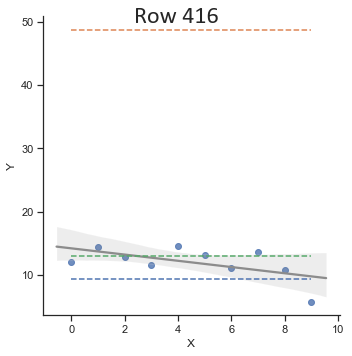

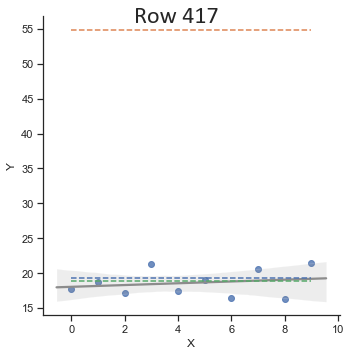

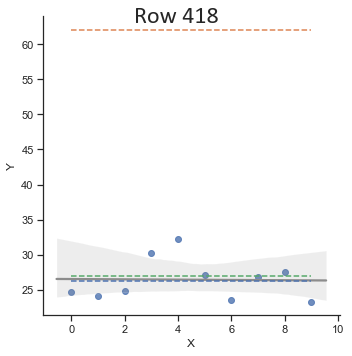

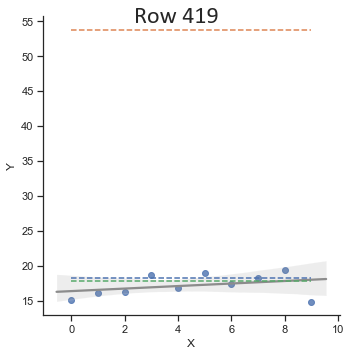

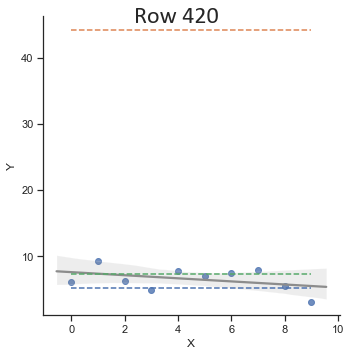

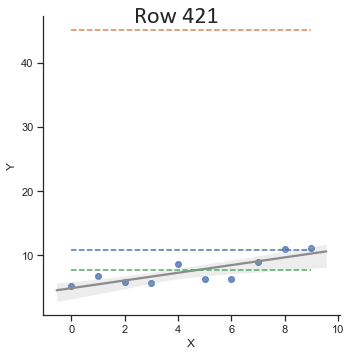

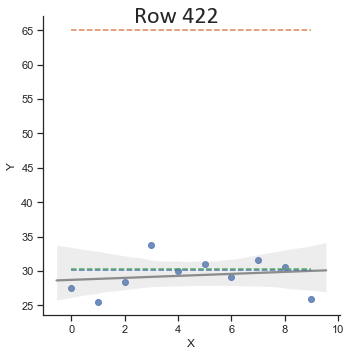

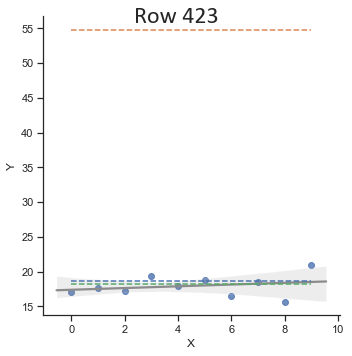

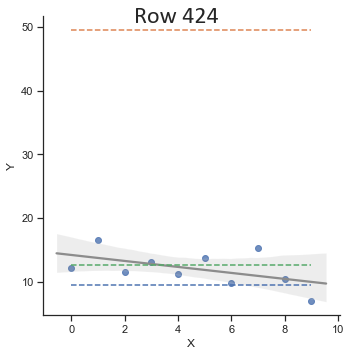

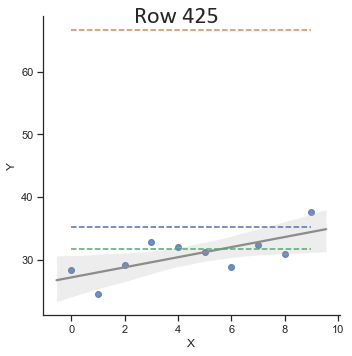

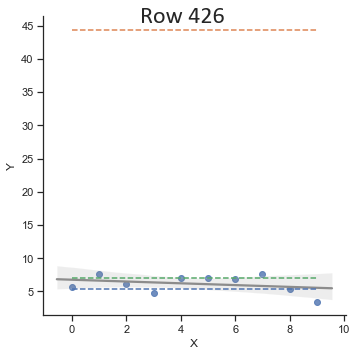

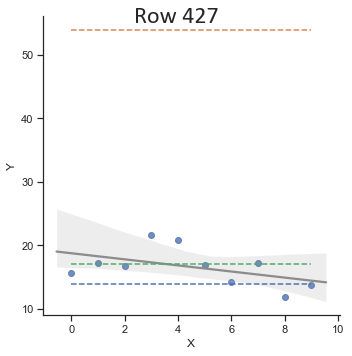

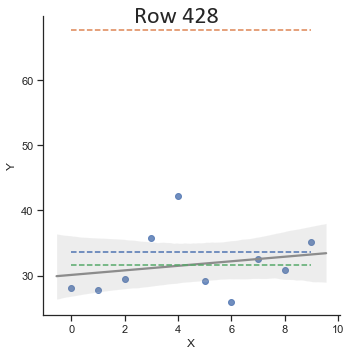

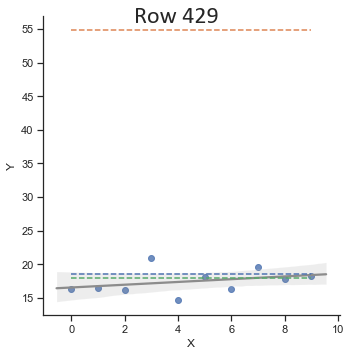

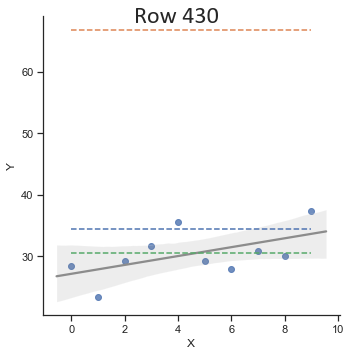

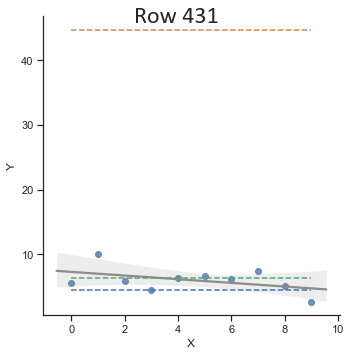

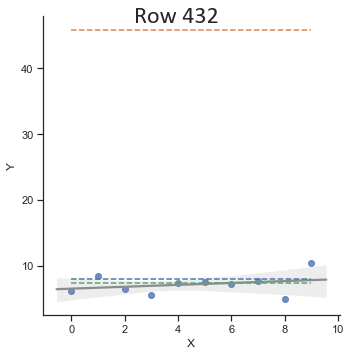

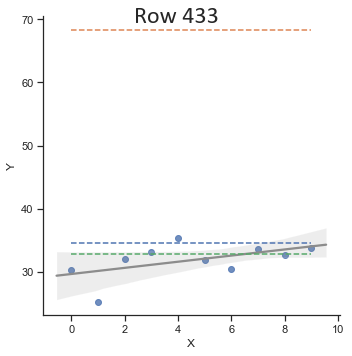

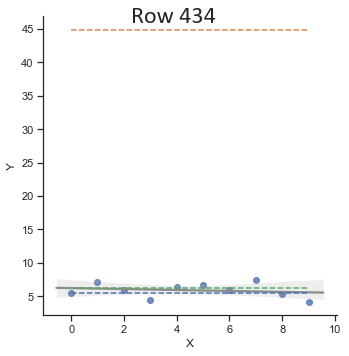

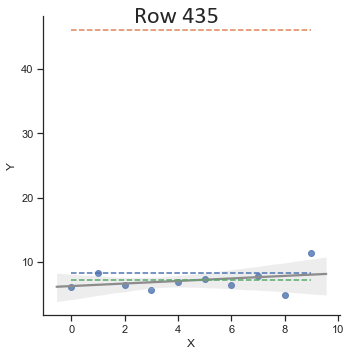

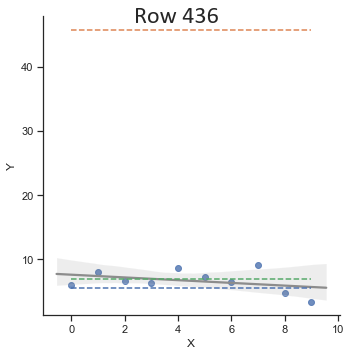

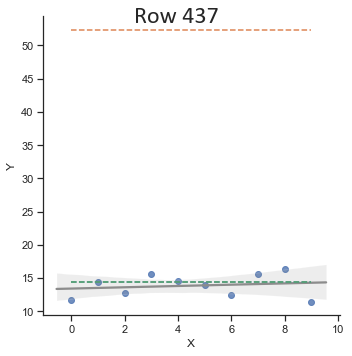

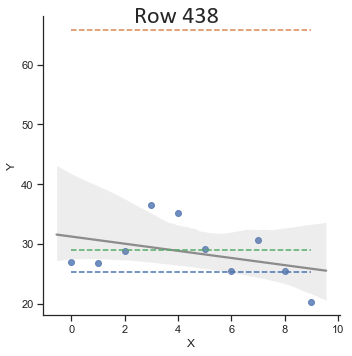

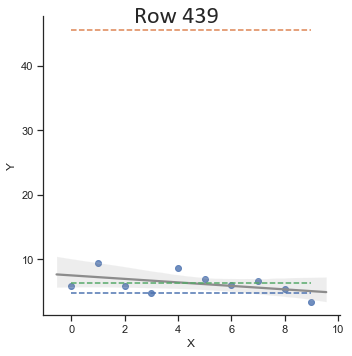

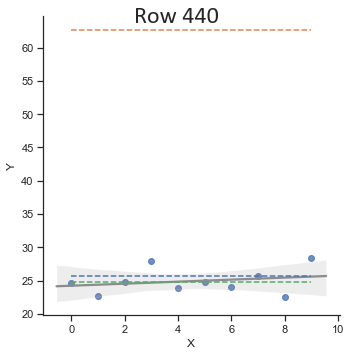

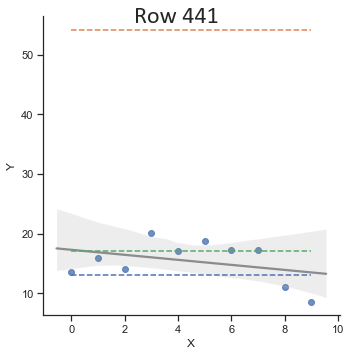

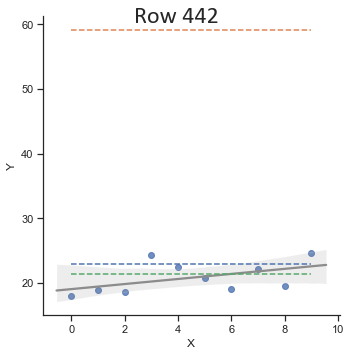

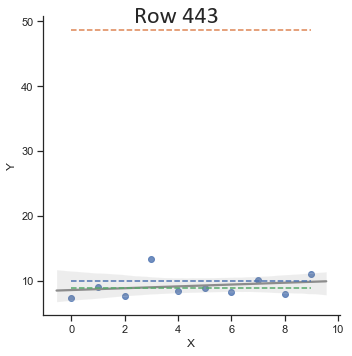

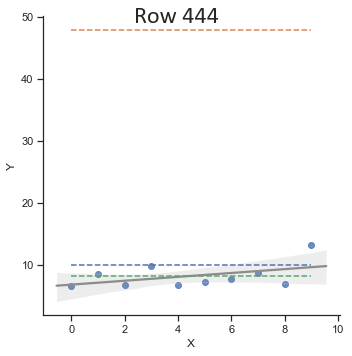

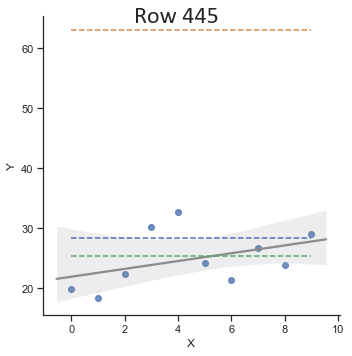

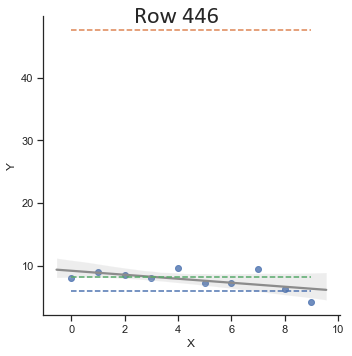

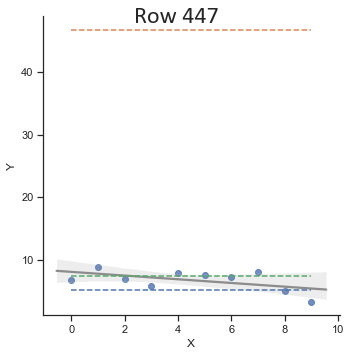

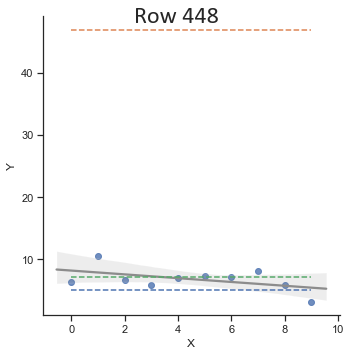

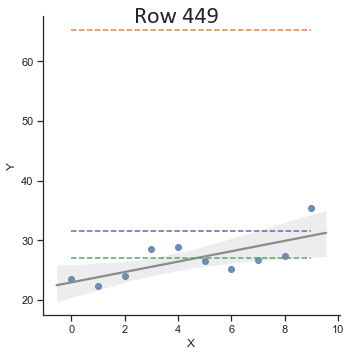

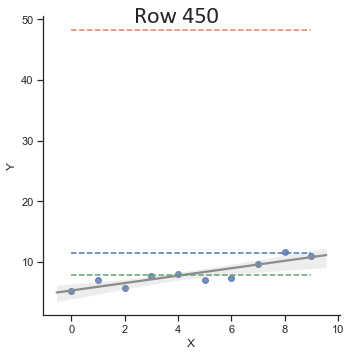

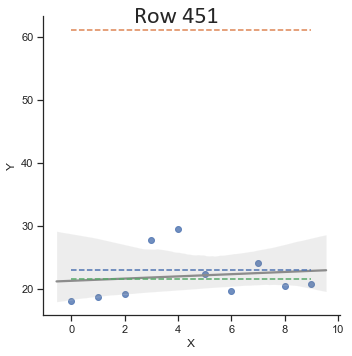

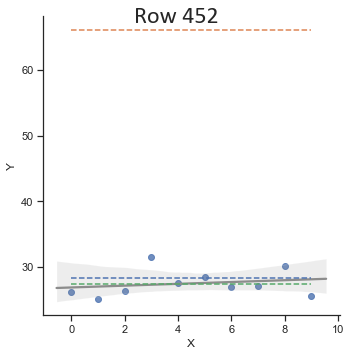

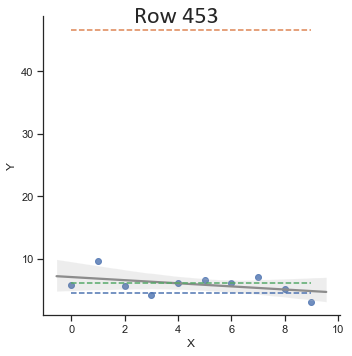

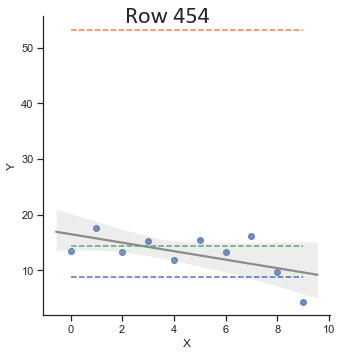

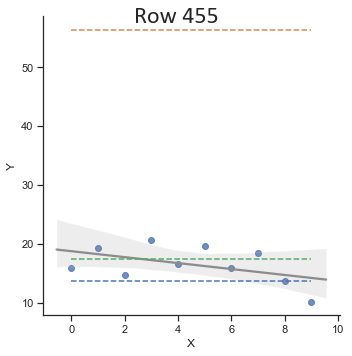

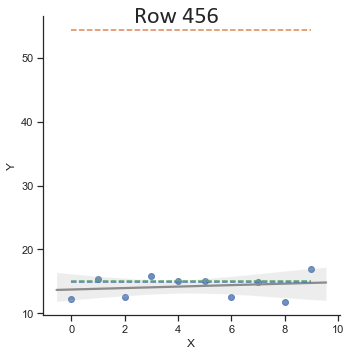

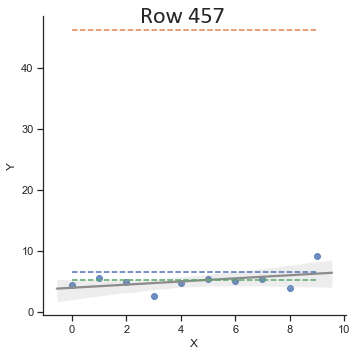

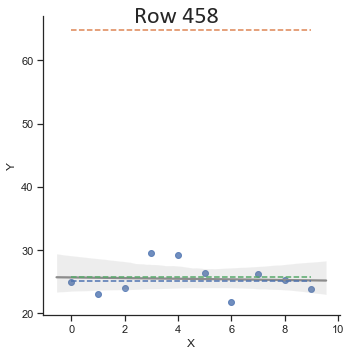

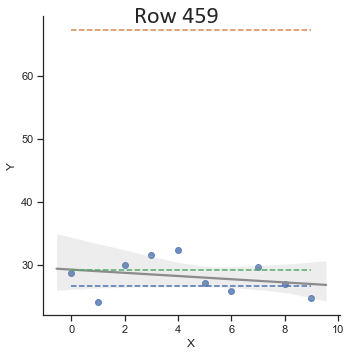

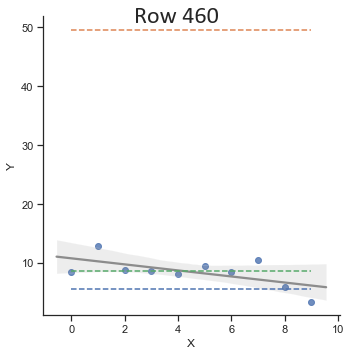

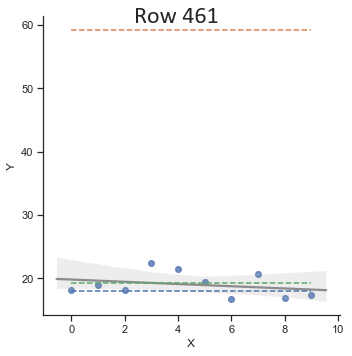

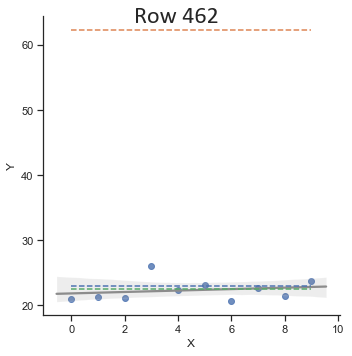

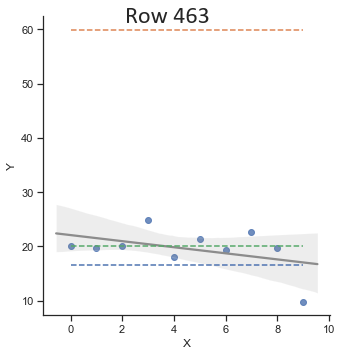

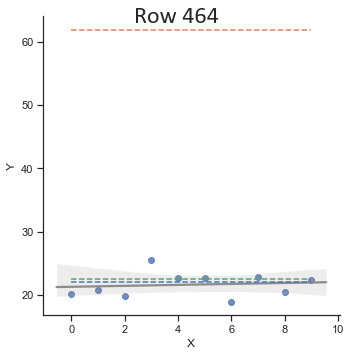

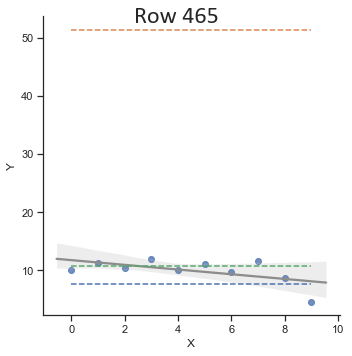

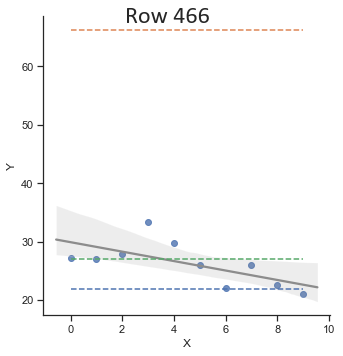

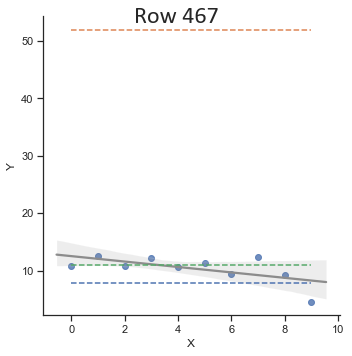

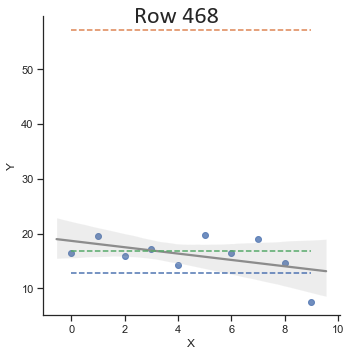

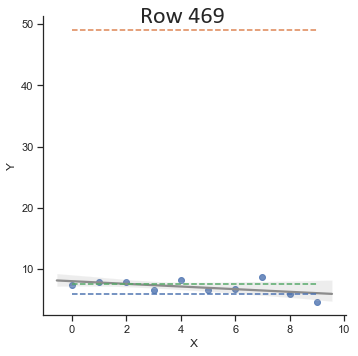

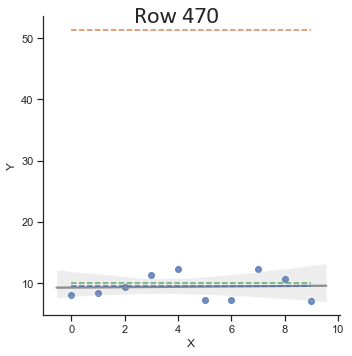

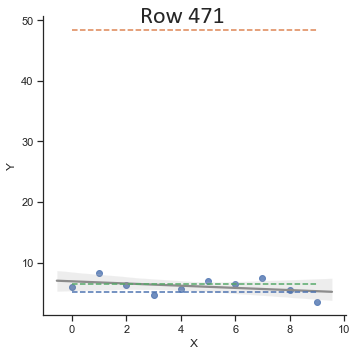

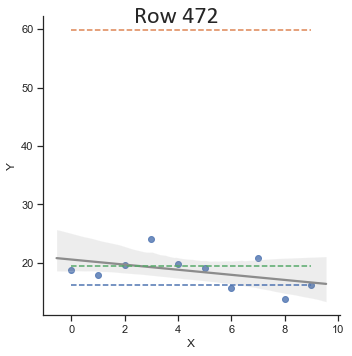

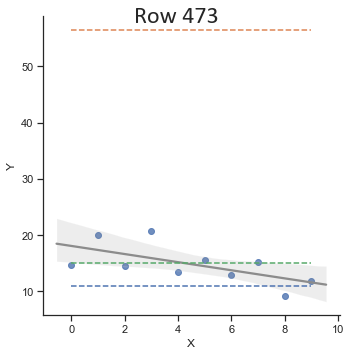

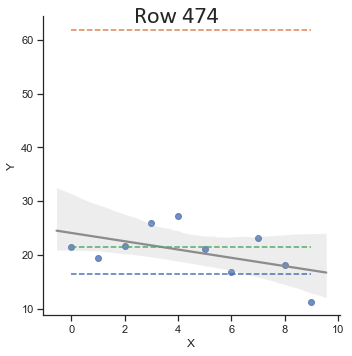

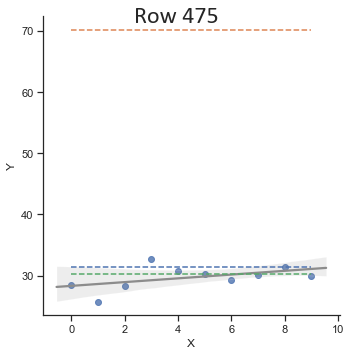

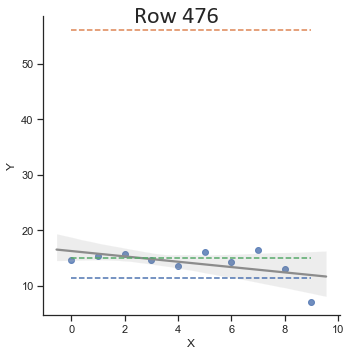

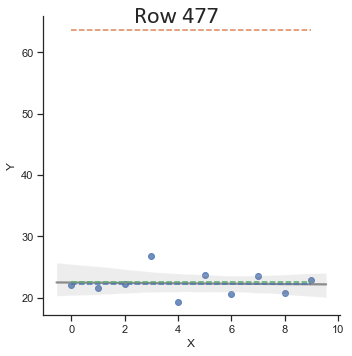

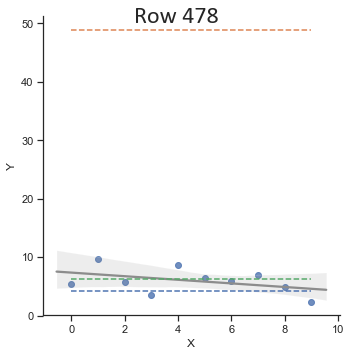

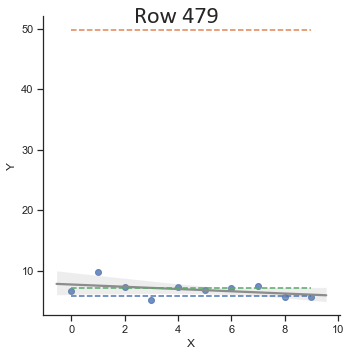

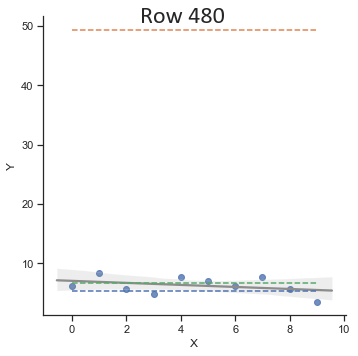

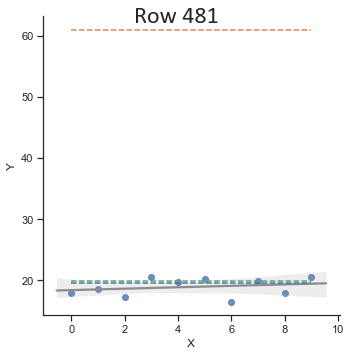

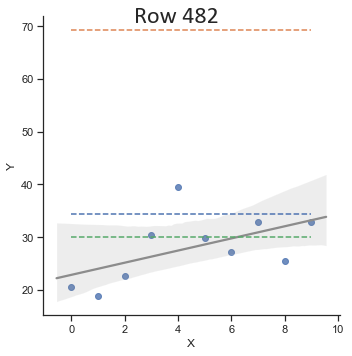

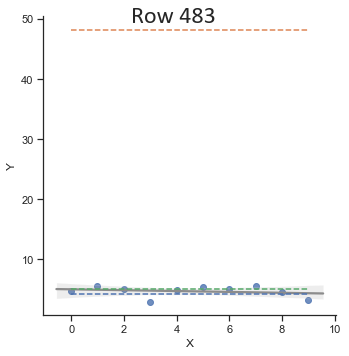

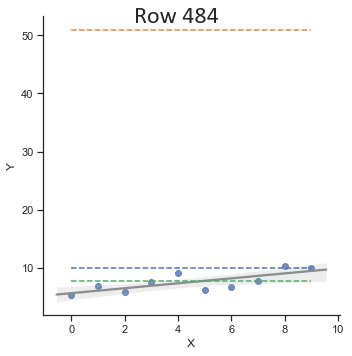

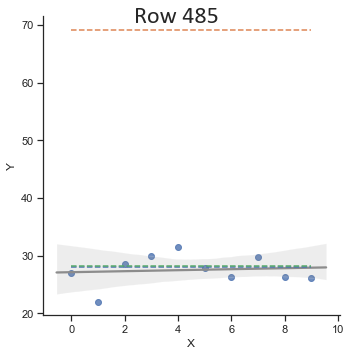

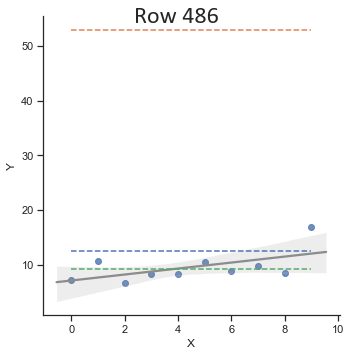

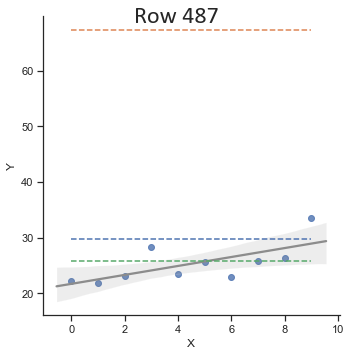

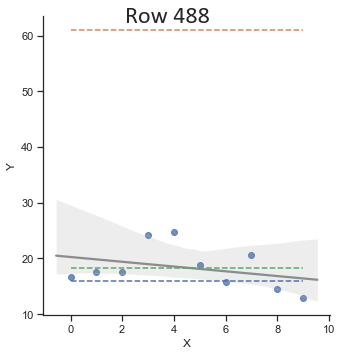

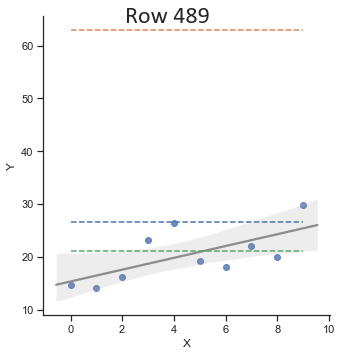

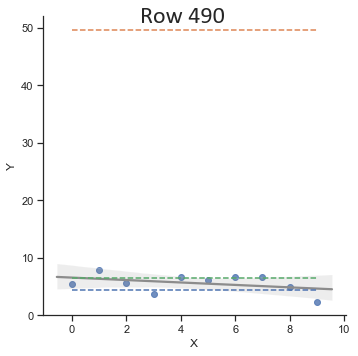

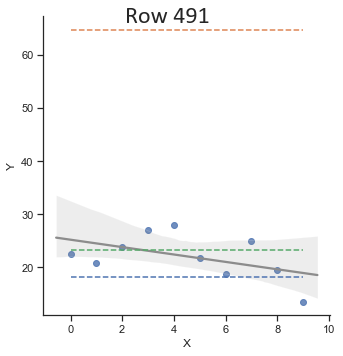

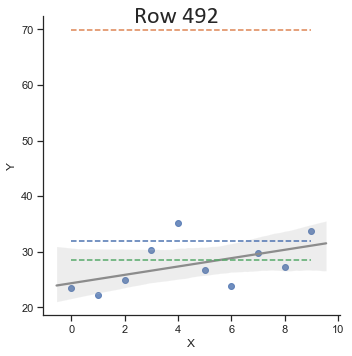

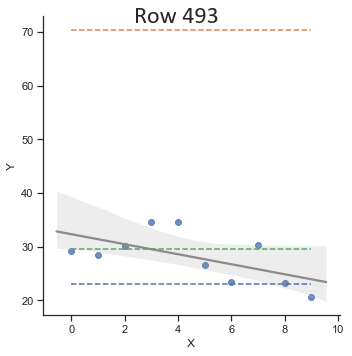

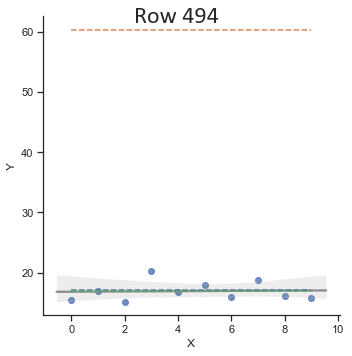

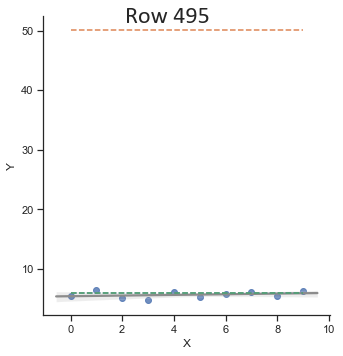

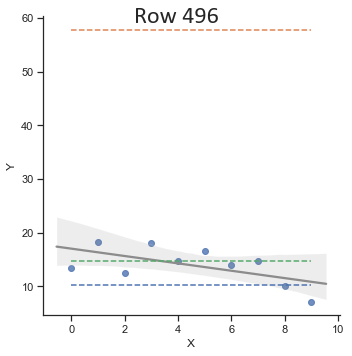

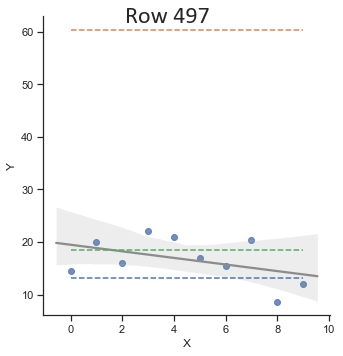

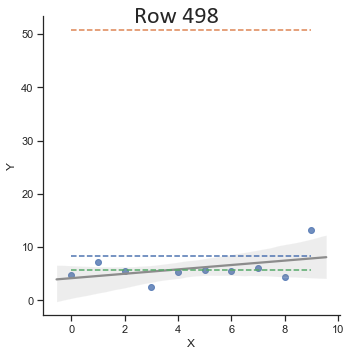

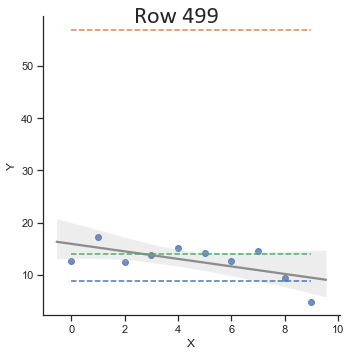

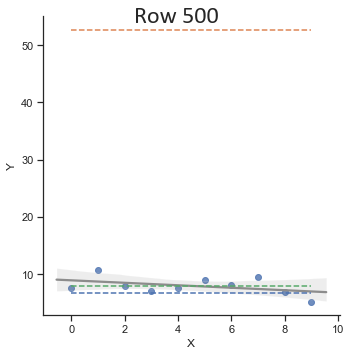

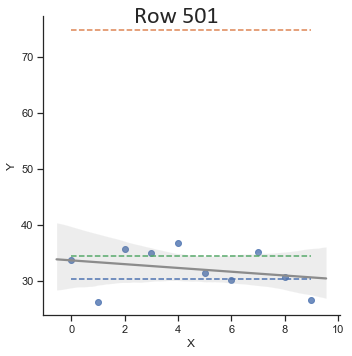

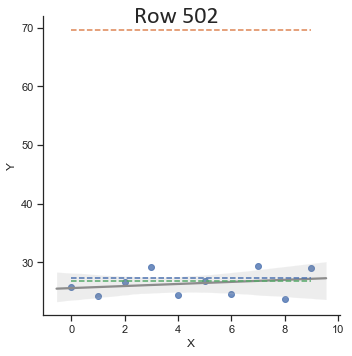

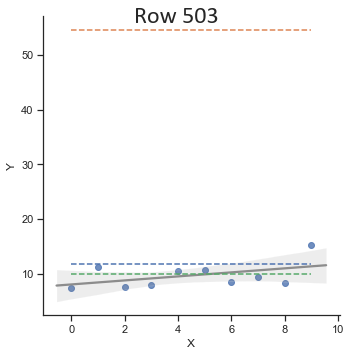

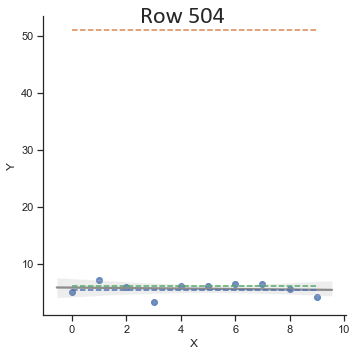

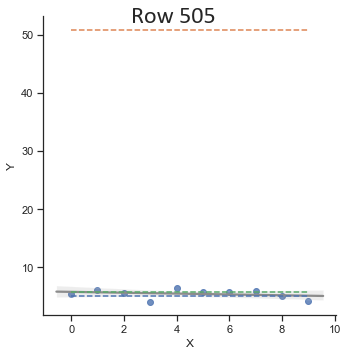

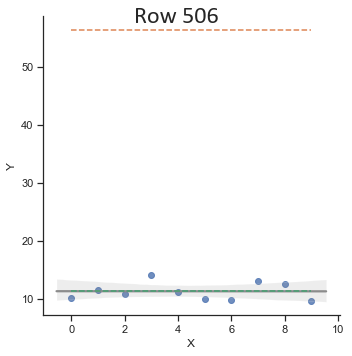

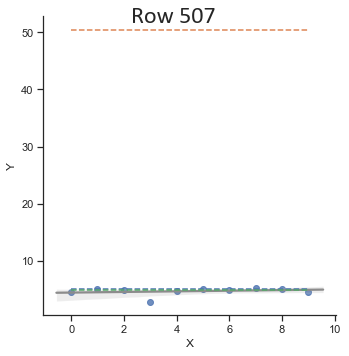

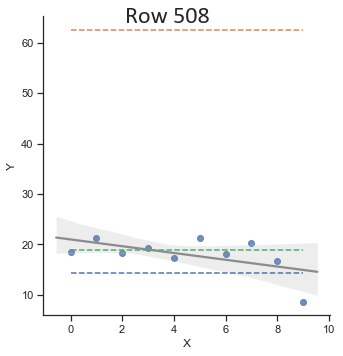

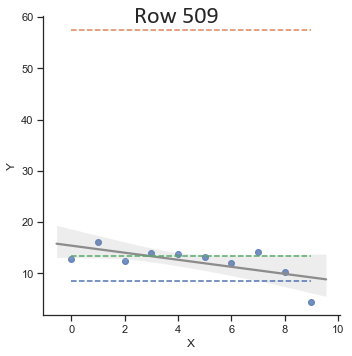

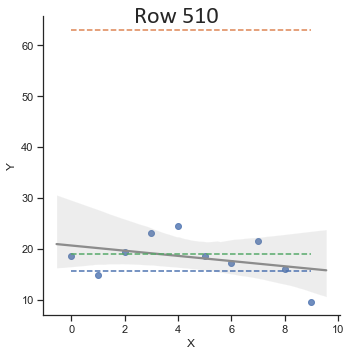

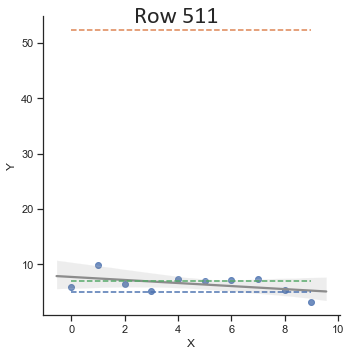

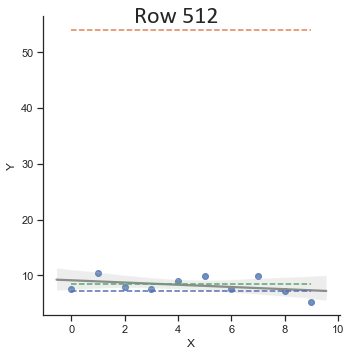

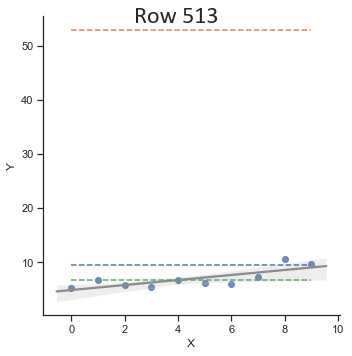

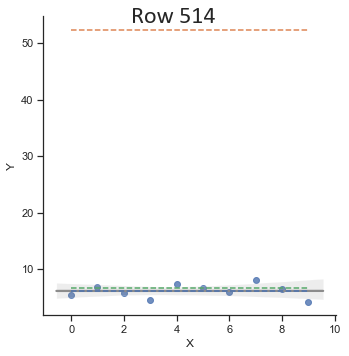

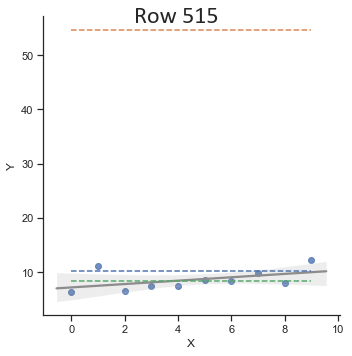

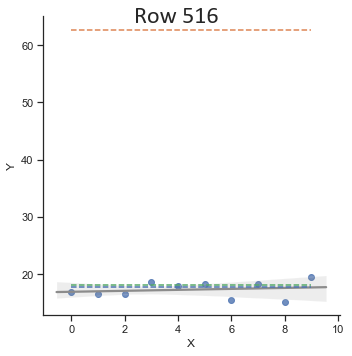

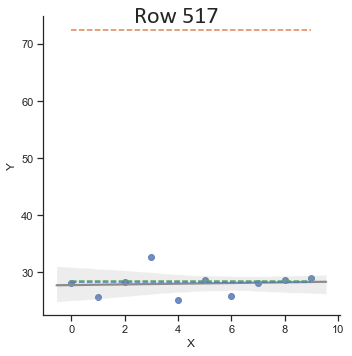

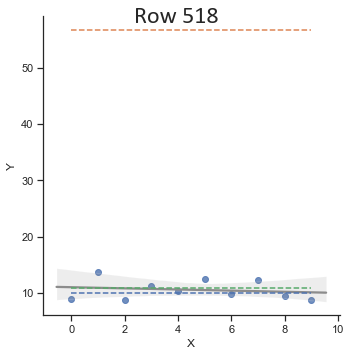

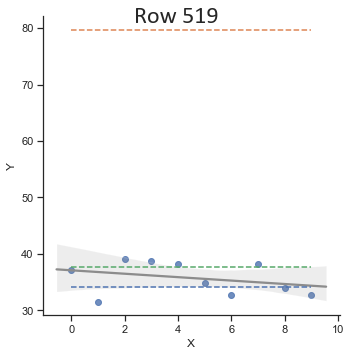

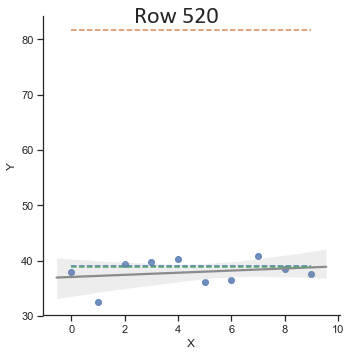

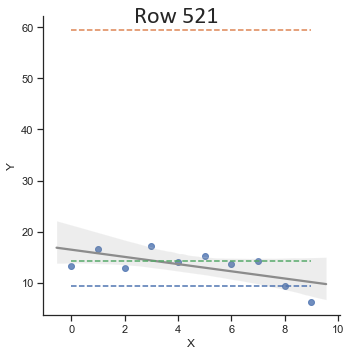

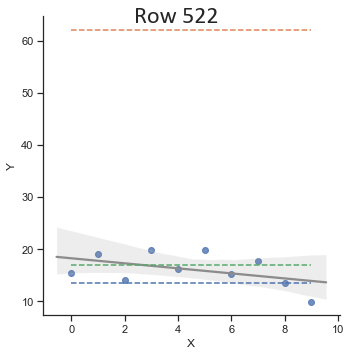

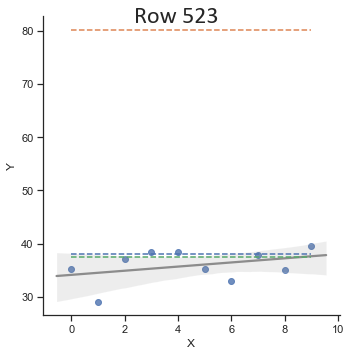

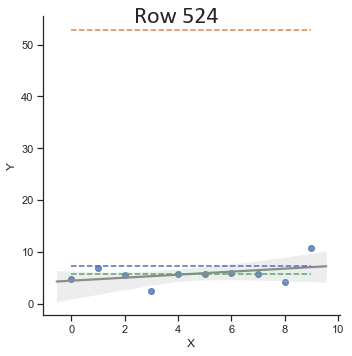

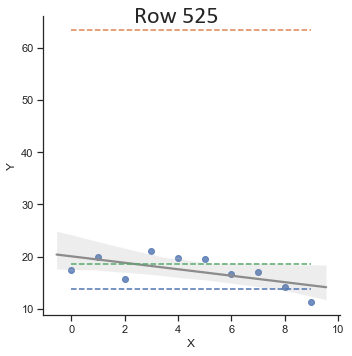

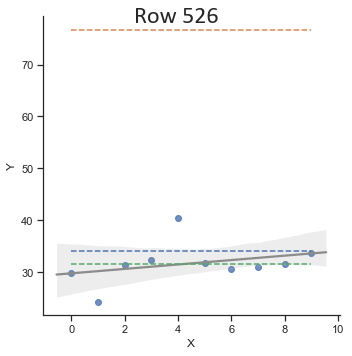

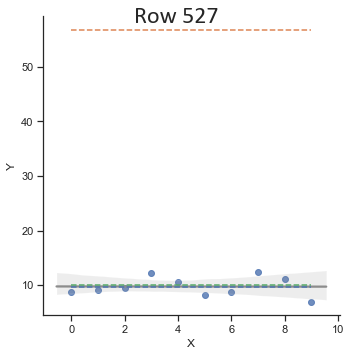

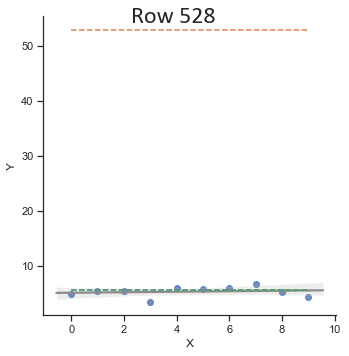

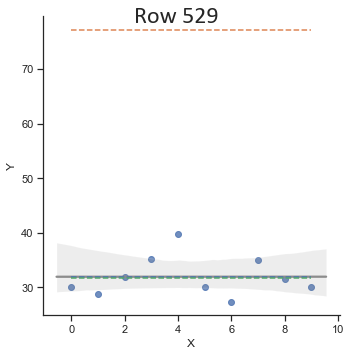

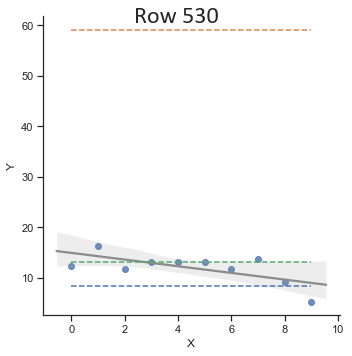

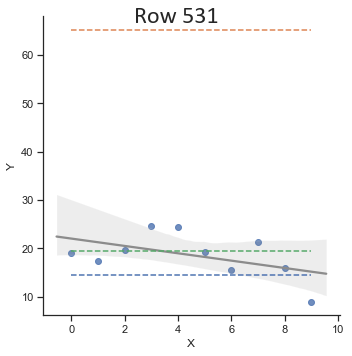

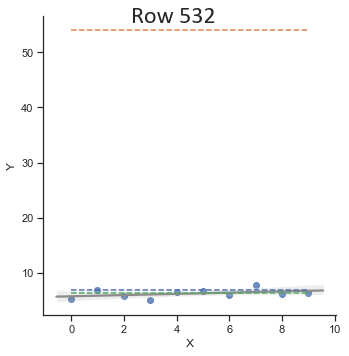

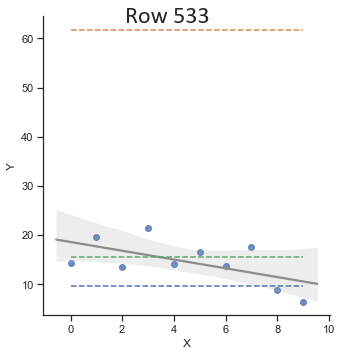

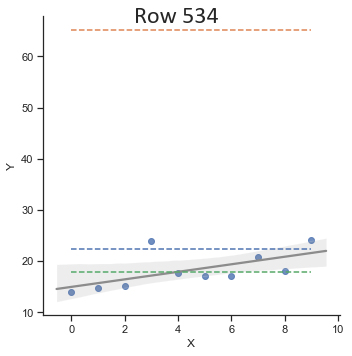

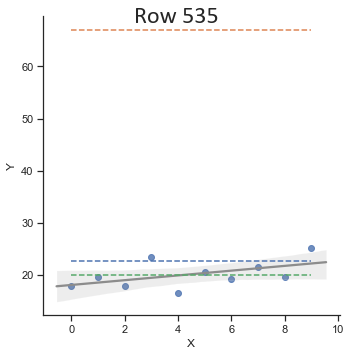

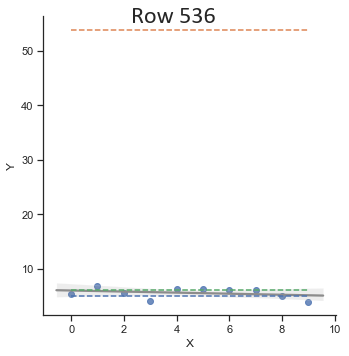

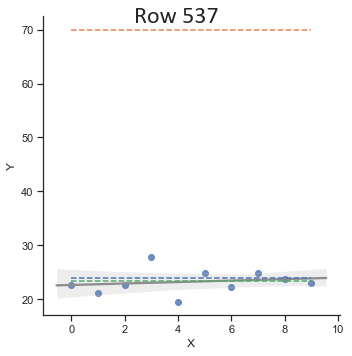

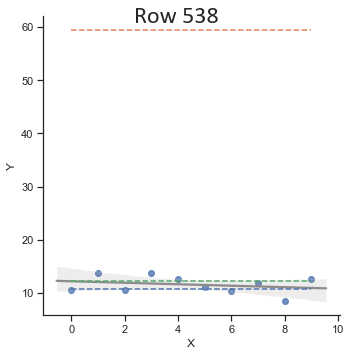

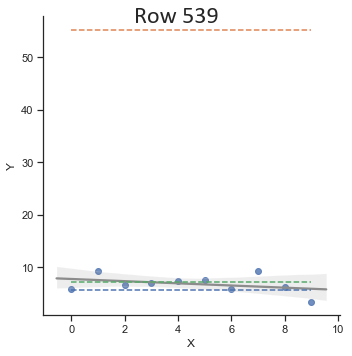

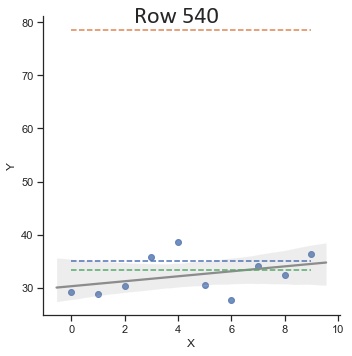

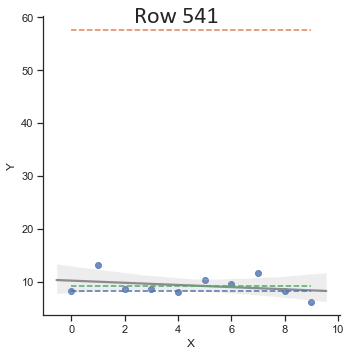

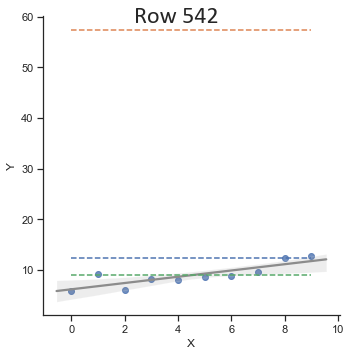

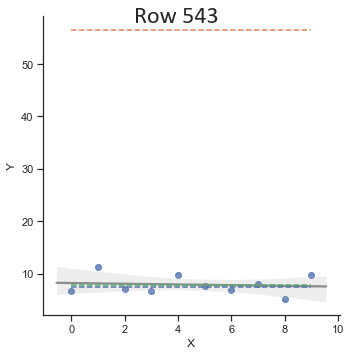

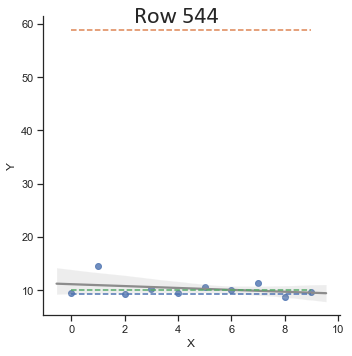

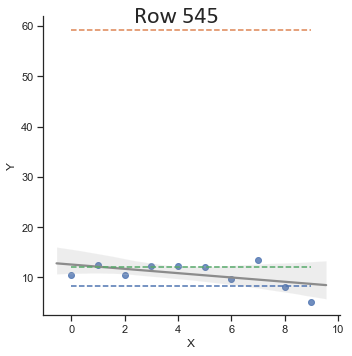

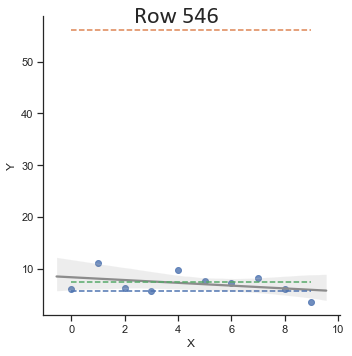

In [ ]:
colors = sns.color_palette("deep", 10)
for i in range(len(df.index)):
    obs = df.iloc[i:i+1,1:11].T
    obs.rename({i:'y'}, axis='columns', inplace=True)
    obs.rename({fname01:0,
                fname02:1,
                fname03:2,
                fname04:3,
                fname05:4,
                fname06:5,
                fname07:6,
                fname08:7,
                fname09:8,
                fname10:9}, axis='index', inplace=True)
    obs['x'] = obs.index

    mean = df.iloc[i:i+1,df.columns.get_loc('mean')][i]
    median = df.iloc[i:i+1,df.columns.get_loc('median')][i]
    linear = df.iloc[i:i+1,df.columns.get_loc('linear')][i]
    
    # Make the plot
    g0 = sns.lmplot(x='x', y='y', data=obs, line_kws={'color': colors[7]})
    g0.fig.suptitle("Row {:3}".format(i), fontsize=24, fontname='Calibri')
    g0.set_axis_labels('X', 'Y')
    # Add the various metrics
    plt.plot(np.linspace(0,9,1000), [linear]*1000, linestyle='--')
    plt.plot(np.linspace(0,9,1000), [mean]*1000, color=colors[1], linestyle='--')
    plt.plot(np.linspace(0,9,1000), [median]*1000, color=colors[2], linestyle='--')
    #, xy=(.5, .95), xycoords=g0.ax.transAxes)

    # Show, then close figure
    plt.show()
    plt.close()

    #  color=colors[0], 


## Create 3x preditions based on this
The first is the mean, the second the median, and the third the Linear extrapolated value.

In [ ]:
dfMean = df[['row_id', 'mean']].copy()
dfMedian = df[['row_id', 'median']].copy()
dfLinear = df[['row_id', 'linear']].copy()
print(dfMean.head())
print(dfMedian.head())
print(dfLinear.head())

dfMean.rename({'mean':'prevalence_of_undernourishment'}, axis='columns', inplace=True)
dfMedian.rename({'median':'prevalence_of_undernourishment'}, axis='columns', inplace=True)
dfLinear.rename({'linear':'prevalence_of_undernourishment'}, axis='columns', inplace=True)
print(dfMean.head())
print(dfMedian.head())
print(dfLinear.head())


## Export them to CSV for evaluation

In [ ]:
dfMean.to_csv('prediction-20181027-01-mean-of-best-10.csv', index=False)
dfMedian.to_csv('prediction-20181027-02-median-of-best-10.csv', index=False)
dfLinear.to_csv('prediction-20181027-03-linear-of-best-10.csv', index=False)

## Conclusions
The mean based prediction gave a score of 30.9530, the median 8.3415, and the linear extrapolation a score of 9.6902

None of these were an improvement and hence was an interesting but ultimately wasted attempt at reverse engineerign the test dataset.